In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from collections import defaultdict

# --- Funciones de Procesamiento ---

ORDERED_SUB_LATENCY_COMPONENTS = {
    # "nombre_columna_csv": "Etiqueta para Leyenda"
    # Para un gráfico de barras apiladas con sentido, considera usar solo los componentes aditivos
    # que suman lat_total_e2e_ms, por ejemplo:
    # "lat_imgpub_to_cb_ms", "lat_cb_to_batch_start_ms", 
    # "lat_batch_start_to_res_pub_ms", "lat_res_pub_to_res_recv_ms".
    # Incluir lat_total_e2e_ms o lat_segnode_cb_to_segsub_recv_ms (que es una suma parcial)
    # en el apilamiento junto con sus partes constituyentes puede ser redundante o confuso.
    
    # "lat_imgpub_to_cb_ms": "ImgPub to Callback (T1-T0)",
    # "lat_cb_to_batch_start_ms": "CB to Batch Start (T2-T1)",
    # "lat_batch_start_to_res_pub_ms": "Batch Start to ResultsPub (T3-T2)",
    # "lat_res_pub_to_res_recv_ms": "ResultsPub to ResultsRecv (T4-T3)",
    # "lat_segnode_cb_to_segsub_recv_ms": "SegNode: CB to ResultsRecv (T4-T1)", # Suma de (T2-T1)+(T3-T2)+(T4-T3)
    # "lat_total_e2e_ms": "Total End-to-End (T4-T0)" # Suma de los primeros cuatro componentes




    "lat_imgpub_to_cb_ms": "(T0 -> T1)",
    "lat_cb_to_batch_start_ms": "(T1 -> T2)",
    "lat_batch_start_to_res_pub_ms": "(T2 -> T3)",
    "lat_res_pub_to_res_recv_ms": "(T3 -> T4)",
    "lat_segnode_cb_to_segsub_recv_ms": "(T1 -> T4)", # Suma de (T2-T1)+(T3-T2)+(T4-T3)
    "lat_total_e2e_ms": "(T0 -> T4)" # Suma de los primeros cuatro componentes
    # Añade o modifica según las columnas presentes en tus archivos de latencia.
    # Estas son las partes que se apilarán para mostrar la latencia total desglosada.
}
def parse_latency_filename(filename):
    """Extrae configuración del nombre de archivo de latencia."""
    basename = os.path.basename(filename)
    # Prioriza archivos con _car_ y _POST.csv, case-insensitive para compression/raw y DDS
    match = re.search(r'latency_log_car_(\d+P)_(CCC|FFF)_(compressed|raw)_POST\.csv', basename, re.IGNORECASE)
    if match:
        arch = match.group(1).upper()
        dds = match.group(2).upper()
        compression = match.group(3).lower()
        return {"arch": arch, "dds": dds, "compression": compression, "type": "latency"}
    
    # Podrías añadir más patrones aquí si hay otros formatos de latencia válidos que quieras parsear
    # Por ejemplo, para archivos sin "_POST" o con diferentes prefijos, pero asegúrate de que
    # los datos que extraen son consistentes con lo que esperan las funciones de ploteo.
    return None

def parse_system_filename(filename):
    """Extrae configuración del nombre de archivo de métricas del sistema."""
    basename = os.path.basename(filename)
    
    patterns = [
        # system_metrics_log_system_metrics_log_1p_local_C_compressed_1.csv
        r'system_metrics_log_system_metrics_log_(\d+p)_local_(C|F)_(compressed|raw)_?\d*\.csv',
        # system_metrics_log_1p_local_C_compressed_1.csv
        r'system_metrics_log_(\d+p)_local_(C|F)_(compressed|raw)_?\d*\.csv',
        # system_metrics_1p_local_C_compressed_2.csv
        r'system_metrics_(\d+p)_local_(C|F)_(compressed|raw)_?\d*\.csv',
        # 3p_local_c_raw.csv (más genérico, tener cuidado con falsos positivos)
        r'(\d+p)_local_(C|F)_(compressed|raw)\.csv',
    ]

    for pattern in patterns:
        match = re.search(pattern, basename, re.IGNORECASE)
        if match:
            # Para el patrón genérico, asegúrate de que no es un archivo de latencia malinterpretado
            if pattern == r'(\d+p)_local_(C|F)_(compressed|raw)\.csv' and \
               ("latency_log" in basename.lower() or "system_metrics" in basename.lower()): # Podría ser más específico
                # Si el nombre genérico también contiene "latency_log" o "system_metrics",
                # es probable que los patrones más específicos ya lo hubieran capturado o
                # es un nombre ambiguo. Se podría añadir lógica para evitar doble conteo o error.
                # Por ahora, si los patrones específicos no lo capturan, este lo hará.
                pass

            arch = match.group(1).upper()
            dds_code = match.group(2).upper()
            dds = "CCC" if dds_code == "C" else "FFF"
            compression = match.group(3).lower()
            return {"arch": arch, "dds": dds, "compression": compression, "type": "system"}
            
    # Archivos como "latency_log_1p_local_C_compressed_1.csv" no serán parseados como system_metrics
    # por los patrones anteriores si contienen "latency_log". Si deben ser tratados como system_metrics,
    # se necesitaría un patrón específico o ajustar la lógica.
    return None

def process_latency_file(filepath):
    """Procesa un archivo CSV de latencia y devuelve métricas clave."""
    try:
        df = pd.read_csv(filepath)
    except FileNotFoundError:
        print(f"Error: Archivo no encontrado {filepath}")
        return None
    except Exception as e:
        print(f"Error leyendo {filepath}: {e}")
        return None

    if 'lat_total_e2e_ms' not in df.columns:
        print(f"Error: Columna 'lat_total_e2e_ms' no encontrada en {filepath}")
        return None

    latencies = df['lat_total_e2e_ms']
    
    # Calcular media y desviación estándar sobre todos los datos
    mean_latency = latencies.mean()
    std_latency = latencies.std()
    raw_latency_series = latencies.copy() # Store raw series

    # Para min y max, excluir las primeras 100 iteraciones si hay suficientes datos
    iterations_to_skip = 100
    if len(latencies) > iterations_to_skip:
        latencies_for_min_max = latencies.iloc[iterations_to_skip:]
    else:
        # Si hay menos de 100 (o 100 justas) filas, usar todos los datos para min/max
        # o podrías decidir devolver NaN si prefieres no calcularlos en este caso.
        print(f"Advertencia: Menos de {iterations_to_skip+1} puntos de datos en {filepath}. Min/Max se calcularán sobre todos los datos disponibles.")
        latencies_for_min_max = latencies

    if not latencies_for_min_max.empty:
        min_latency = latencies_for_min_max.min()
        max_latency = latencies_for_min_max.max()
    else:
        # Esto podría ocurrir si, por ejemplo, latencies tenía exactamente iterations_to_skip filas
        # y latencies_for_min_max quedó vacío, o si latencies original estaba vacío.
        min_latency = np.nan
        max_latency = np.nan
        print(f"Advertencia: No hay datos para calcular Min/Max después de omitir {iterations_to_skip} iteraciones en {filepath}.")


    total_packets_sent_overall = 0
    total_packets_lost_overall = 0

    if 'camera_id' in df.columns and 'packet_seq_num' in df.columns and 'total_lost_pkts_cam' in df.columns:
        for camera in df['camera_id'].unique():
            cam_df = df[df['camera_id'] == camera]
            if not cam_df.empty:
                min_seq = cam_df['packet_seq_num'].min()
                max_seq = cam_df['packet_seq_num'].max()
                
                packets_sent_cam = (max_seq - min_seq + 1) if not cam_df.empty else 0
                packets_lost_cam = cam_df['total_lost_pkts_cam'].max() if not cam_df.empty else 0
                
                total_packets_sent_overall += packets_sent_cam
                total_packets_lost_overall += packets_lost_cam
    else:
        print(f"Advertencia: Faltan columnas para el cálculo de pérdida de paquetes en {filepath}")


    loss_percentage = (total_packets_lost_overall / total_packets_sent_overall * 100) \
                      if total_packets_sent_overall > 0 else 0

    processed_data = {
        "mean_latency": mean_latency, # lat_total_e2e_ms
        "std_latency": std_latency,
        "min_latency": min_latency, 
        "max_latency": max_latency, 
        "loss_percentage": loss_percentage,
        "raw_latency_series": raw_latency_series
    }

    # Procesar sub-latencias definidas en ORDERED_SUB_LATENCY_COMPONENTS
    for col_name, _ in ORDERED_SUB_LATENCY_COMPONENTS.items():
        if col_name in df.columns:
            # Excluir las primeras 100 iteraciones también para las sub-latencias si hay suficientes datos
            if len(df[col_name]) > iterations_to_skip:
                sub_latency_series = df[col_name].iloc[iterations_to_skip:]
            else:
                sub_latency_series = df[col_name]
            
            if not sub_latency_series.empty:
                processed_data[f"mean_{col_name}"] = sub_latency_series.mean()
            else:
                processed_data[f"mean_{col_name}"] = np.nan
                print(f"Advertencia: No hay datos para la sub-latencia '{col_name}' después de omitir {iterations_to_skip} iteraciones en {filepath}.")
        else:
            processed_data[f"mean_{col_name}"] = np.nan
            print(f"Advertencia: Columna de sub-latencia '{col_name}' no encontrada en {filepath}. Se usará NaN.")
            
    return processed_data

descriptive_name_map = {
    "1P-CCC": "1Modelo_Cyclone",
    "1P-FFF": "1Modelo_FastDDS",
    "3P-CCC": "3ModelosParalelo_Cyclone",
    "3P-FFF": "3ModelosParalelo_FastDDS"
}

def process_system_file(filepath):
    """Procesa un archivo CSV de métricas del sistema, filtrando puntos de datos bajos antes de promediar."""
    try:
        df = pd.read_csv(filepath)
    except FileNotFoundError:
        print(f"Error: Archivo no encontrado {filepath}")
        return None
    except Exception as e:
        print(f"Error leyendo {filepath}: {e}")
        return None

    metrics = {}
    # Umbral para considerar un punto de dato individual como "activo" para CPU/GPU
    MIN_POINT_UTILIZATION_THRESHOLD = 3.0 

    # Columnas esperadas y sus claves para el diccionario de salida
    cols_to_process = {
        'cpu_total_percent': 'mean_cpu',
        'gpu0_util_percent': 'mean_gpu',
    }
    std_cols_to_process = {
        'cpu_total_percent': 'std_cpu',
        'gpu0_util_percent': 'std_gpu',
    }
    
    # Nombres de columna alternativos para fallback
    alt_col_map = {
        'mean_cpu': 'cpu_usage_percent',
        'std_cpu': 'cpu_usage_percent', 
        'mean_gpu': 'gpu_utilization_percent',
        'std_gpu': 'gpu_utilization_percent' 
    }

    for col_primary, key_mean in cols_to_process.items():
        key_std = std_cols_to_process[col_primary] # Clave para la desviación estándar correspondiente
        selected_col_name = None
        
        if col_primary in df.columns:
            selected_col_name = col_primary
        elif alt_col_map.get(key_mean) and alt_col_map[key_mean] in df.columns:
            selected_col_name = alt_col_map[key_mean]
            print(f"Advertencia: Usando columna alternativa '{selected_col_name}' para '{key_mean}'/'{key_std}' en {filepath}.")
        
        if selected_col_name:
            # Filtrar la serie para incluir solo puntos de datos por encima del umbral
            active_series = df[selected_col_name][df[selected_col_name] >= MIN_POINT_UTILIZATION_THRESHOLD]
            
            if not active_series.empty:
                metrics[key_mean] = active_series.mean()
                metrics[key_std] = active_series.std()
            else:
                # Si no hay datos después de filtrar, reportar NaN
                metrics[key_mean] = np.nan
                metrics[key_std] = np.nan
                print(f"Advertencia: No hay puntos de datos >= {MIN_POINT_UTILIZATION_THRESHOLD}% para '{selected_col_name}' en {filepath}. '{key_mean}' y '{key_std}' serán NaN.")
        else:
            # Si la columna (primaria o alternativa) no se encuentra
            metrics[key_mean] = np.nan
            metrics[key_std] = np.nan
            print(f"Advertencia: Columna '{col_primary}' (ni alternativa '{alt_col_map.get(key_mean)}') no encontrada en {filepath}. '{key_mean}' y '{key_std}' serán NaN.")

    # Lógica para el ancho de banda (sin filtrar puntos de datos individuales, a menos que se especifique)
    if 'net_recv_mbps' in df.columns and 'net_sent_mbps' in df.columns:
        df['total_bandwidth_mbps'] = df['net_recv_mbps'] + df['net_sent_mbps']
        metrics['mean_bandwidth'] = df['total_bandwidth_mbps'].mean()
        metrics['std_bandwidth'] = df['total_bandwidth_mbps'].std()
    elif 'network_receive_mbps' in df.columns and 'network_transmit_mbps' in df.columns:
        df['total_bandwidth_mbps'] = df['network_receive_mbps'] + df['network_transmit_mbps']
        metrics['mean_bandwidth'] = df['total_bandwidth_mbps'].mean()
        metrics['std_bandwidth'] = df['total_bandwidth_mbps'].std()
        print(f"Advertencia: Usando columnas de red alternativas ('network_receive_mbps', 'network_transmit_mbps') en {filepath}.")
    else:
        print(f"Advertencia: Columnas de red ('net_recv_mbps'/'net_sent_mbps' o alternativas) no encontradas en {filepath} para calcular ancho de banda. Se usará NaN.")
        metrics['mean_bandwidth'] = np.nan
        metrics['std_bandwidth'] = np.nan
        
    return metrics



# --- Funciones de Ploteo ---
def plot_stacked_latency_breakdown(all_data_latency, sub_latency_components_map):
    """
    Gráfico de barras agrupadas comparando PROMEDIOS de arquitecturas 1P vs 3P
    para cada componente de latencia.
    Ajusta los datos para configuraciones 3P: T1-T0 toma el valor de T2-T1 original, y T2-T1 se vuelve 0.
    El componente "SegNode: CB to ResRecv (T4-T1)" se excluye de este gráfico.
    """
    if not all_data_latency:
        print("No hay datos de latencia procesados para generar el gráfico de desglose.")
        return
    if not sub_latency_components_map:
        print("No se definieron componentes de sub-latencia para el gráfico de desglose.")
        return

    key_to_exclude = "lat_segnode_cb_to_segsub_recv_ms"
    filtered_sub_latency_components_map = {
        k: v for k, v in sub_latency_components_map.items() if k != key_to_exclude
    }

    if not filtered_sub_latency_components_map:
        print(f"No hay componentes de sub-latencia para graficar después de excluir '{key_to_exclude}'.")
        return

    component_display_labels = list(filtered_sub_latency_components_map.values())
    if not component_display_labels:
        print("No hay componentes de sub-latencia definidos para graficar (después del filtrado).")
        return

    architectures_to_parse = ["1P", "3P"] # Para iterar y recoger datos
    dds_types_parse = {"CCC": "Cyclone", "FFF": "FastDDS"}
    compressions_parse = {"raw": "Raw", "compressed": "Compressed"}

    # Almacenar datos para promediar: {"1P": {component_label: [valores]}, "3P": {component_label: [valores]}}
    data_for_averaging = {
        arch_group: {label: [] for label in component_display_labels}
        for arch_group in ["1P", "3P"]
    }
    
    configs_found_for_1P = False
    configs_found_for_3P = False
    
    csv_col_t1_t0_key = "lat_imgpub_to_cb_ms"
    csv_col_t2_t1_key = "lat_cb_to_batch_start_ms"

    for arch_iter in architectures_to_parse:
        for dds_code, _ in dds_types_parse.items():
            for comp_code, _ in compressions_parse.items():
                config_key = f"{arch_iter}-{dds_code}-{comp_code}"
                
                if config_key in all_data_latency:
                    data_entry = all_data_latency[config_key]
                    current_arch_group = "3P" if arch_iter == "3P" else "1P"

                    if current_arch_group == "1P": configs_found_for_1P = True
                    if current_arch_group == "3P": configs_found_for_3P = True

                    for csv_col_map_key, legend_label_from_map in filtered_sub_latency_components_map.items():
                        mean_val = np.nan # Default a NaN si no se encuentra o es irrelevante
                        original_val_for_component = data_entry.get(f"mean_{csv_col_map_key}", np.nan)

                        if arch_iter == "3P":
                            if csv_col_map_key == csv_col_t1_t0_key: # T1-T0 para 3P
                                mean_val = data_entry.get(f"mean_{csv_col_t2_t1_key}", np.nan)
                            elif csv_col_map_key == csv_col_t2_t1_key: # T2-T1 para 3P
                                mean_val = 0.0 # Se establece en 0 para 3P
                            else: # Otros componentes para 3P
                                mean_val = original_val_for_component
                        else: # Para 1P
                            mean_val = original_val_for_component
                        
                        if legend_label_from_map in data_for_averaging[current_arch_group]:
                             data_for_averaging[current_arch_group][legend_label_from_map].append(mean_val)
                        else:
                            # Esto no debería ocurrir si component_display_labels se deriva de filtered_sub_latency_components_map
                            print(f"Advertencia: Etiqueta de leyenda '{legend_label_from_map}' no encontrada en data_for_averaging para {current_arch_group}")


    # Calcular promedios y preparar datos para el gráfico
    averaged_plot_data_groups = [] # Lista de {"label": "Nombre Grupo", "means": [val1, val2,...]}
    legend_labels_for_plot = []

    if configs_found_for_1P:
        means_1P_avg = [np.nanmean(data_for_averaging["1P"][comp_label]) if data_for_averaging["1P"][comp_label] else np.nan 
                        for comp_label in component_display_labels]
        averaged_plot_data_groups.append({"label": "Promedio 1P", "means": np.nan_to_num(means_1P_avg)}) # Convertir NaNs a 0 para plotear
        legend_labels_for_plot.append("Promedio 1P")

    if configs_found_for_3P:
        means_3P_avg = [np.nanmean(data_for_averaging["3P"][comp_label]) if data_for_averaging["3P"][comp_label] else np.nan
                        for comp_label in component_display_labels]
        averaged_plot_data_groups.append({"label": "Promedio 3P", "means": np.nan_to_num(means_3P_avg)})
        legend_labels_for_plot.append("Promedio 3P")

    if not averaged_plot_data_groups:
        print("No hay datos promediados suficientes de 1P o 3P para generar el gráfico de desglose.")
        return
    
    x_indices = np.arange(len(component_display_labels)) 
    num_groups_to_plot = len(averaged_plot_data_groups) # Será 1 o 2

    bar_group_width_total = 0.35 # Más estrecho ya que solo hay 2 barras por grupo
    bar_width = bar_group_width_total / num_groups_to_plot
    
    color_palette = plt.cm.get_cmap('Pastel1') 

    fig, ax = plt.subplots(figsize=(18, 9)) # Ajustar tamaño si es necesario
    
    legend_handles_collected = []

    for i, data_group in enumerate(averaged_plot_data_groups):
        current_group_label = data_group["label"]
        means_for_current_group = np.array(data_group["means"])
        
        offset = (i - (num_groups_to_plot - 1) / 2.0) * bar_width
        current_bar_positions = x_indices + offset
        
        rects = ax.bar(current_bar_positions, means_for_current_group, width=bar_width, 
                       label=current_group_label, color=color_palette(i))
        if rects: 
            legend_handles_collected.append(rects[0])

    ax.set_ylabel('Latencia Media (ms)')
    ax.set_xlabel('Componentes de Latencia')
    ax.set_title('Desglose de Latencia: Promedios 1P vs 3P por Componente (3P Ajustado, T4-T1 Excluido)')
    ax.set_xticks(x_indices)
    ax.set_xticklabels(component_display_labels, rotation=0, ha="right", fontsize=10)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    if legend_handles_collected and legend_labels_for_plot:
        plt.subplots_adjust(left=0.08, right=0.85, bottom=0.2, top=0.9) 
        ax.legend(legend_handles_collected, legend_labels_for_plot,
                  title="Arquitectura Promediada",
                  loc='center left', bbox_to_anchor=(1.02, 0.5), 
                  fontsize=10)
    else:
        print("Advertencia: No se generaron manejadores o etiquetas para la leyenda del gráfico de desglose promediado.")
        fig.tight_layout()

    plt.savefig("latency_breakdown_averaged_1P_vs_3P.png", bbox_inches='tight')
    plt.show()

def plot_latency_vs_manual_loss_scatter(all_data_latency_input):
    """Gráfico de dispersión para latencia vs. pérdida de paquetes (datos de pérdida manuales) para todas las configuraciones."""
    
    manual_received_packets = {
        # Paquetes recibidos de 1500 enviados
        "1P-CCC-compressed": 1493,
        "1P-CCC-raw": 1490,
        "1P-FFF-compressed": 1499,
        "1P-FFF-raw": 1471,
        "3P-CCC-compressed": 1500,
        "3P-CCC-raw": 1498,
        "3P-FFF-compressed": 1499,
        "3P-FFF-raw": 1478,
    }
    total_packets_sent = 1500

    plt.figure(figsize=(12, 8)) # Ajustado para más puntos
    
    # Orden definido para consistencia en la leyenda y colores/marcadores
    expected_config_keys_ordered = [
        "1P-CCC-raw", "1P-CCC-compressed",
        "1P-FFF-raw", "1P-FFF-compressed",
        "3P-CCC-raw", "3P-CCC-compressed",
        "3P-FFF-raw", "3P-FFF-compressed",
    ]

    # Usar un colormap para distinguir más puntos si es necesario
    color_palette = plt.cm.get_cmap('tab10', len(expected_config_keys_ordered)) 
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p'] # 8 marcadores distintos

    plotted_anything = False
    
    for idx, config_key_full in enumerate(expected_config_keys_ordered):
        if config_key_full in all_data_latency_input and \
           'mean_latency' in all_data_latency_input[config_key_full] and \
           config_key_full in manual_received_packets:
            
            latency_metrics = all_data_latency_input[config_key_full]
            mean_latency = latency_metrics['mean_latency']
            
            received = manual_received_packets[config_key_full]
            lost_packets = total_packets_sent - received
            loss_percentage = (lost_packets / total_packets_sent * 100) if total_packets_sent > 0 else 0
            
            try:
                arch, dds, compression_str = config_key_full.split('-')
                simple_key_for_map = f"{arch}-{dds}" # e.g., "1P-CCC"
                descriptive_base = descriptive_name_map.get(simple_key_for_map, simple_key_for_map)
                label_for_plot = f"{descriptive_base} ({compression_str.capitalize()})"
            except ValueError:
                label_for_plot = config_key_full # Etiqueta de fallback

            plt.scatter(loss_percentage, mean_latency, 
                        label=label_for_plot, 
                        color=color_palette(idx), 
                        marker=markers[idx % len(markers)], s=120) # Tamaño de marcador un poco más grande
            plotted_anything = True
        else:
            # Imprimir advertencia si una configuración esperada no tiene datos completos
            if config_key_full in manual_received_packets : # Solo advertir si se esperaba la configuración
                if not config_key_full in all_data_latency_input or not 'mean_latency' in all_data_latency_input.get(config_key_full, {}):
                    print(f"Advertencia: Datos de latencia no encontrados o incompletos para '{config_key_full}' en plot_latency_vs_manual_loss_scatter.")
            # No es necesario advertir si la clave no está en manual_received_packets porque la iteración se basa en ella.
            
    if not plotted_anything:
        print(f"No hay datos suficientes para graficar latencia vs pérdida manual para todas las configuraciones.")
        plt.close()
        return

    plt.xlabel('Pérdida de Paquetes (%)')
    plt.ylabel('Latencia Media E2E (ms)')
    plt.title('Latencia E2E vs. Pérdida de Paquetes) - Todas las Configuraciones')
    plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize='small')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout(rect=[0, 0, 0.80, 1]) # Ajustar para la leyenda externa
    plt.savefig("latency_vs_manual_loss_scatter_all_configs.png", bbox_inches='tight')
    plt.show()
    
def plot_latency_over_time_cyclone(all_data_latency_dict):
    """Gráfico de líneas para latencia E2E a lo largo del tiempo para configuraciones Cyclone (CCC)."""
    plt.figure(figsize=(18, 10)) 
    
    color_palette = plt.cm.get_cmap('tab10', 8) # Suficientes colores para las posibles configs Cyclone

    line_idx = 0
    plotted_anything = False
    max_iterations_to_plot = 2500

    # Ordenar las claves para un orden consistente en la leyenda
    sorted_keys = sorted(all_data_latency_dict.keys()) 

    for key in sorted_keys:
        data_values = all_data_latency_dict[key]
        try:
            arch, dds_type, compression_type = key.split('-')
            # Filtrar para incluir solo configuraciones Cyclone (CCC)
            if dds_type.upper() != "CCC":
                continue
            arch_dds_key = f"{arch}-{dds_type}" 
        except ValueError:
            print(f"Skipping key {key} in plot_latency_over_time_cyclone due to unexpected format.")
            continue

        if arch_dds_key in descriptive_name_map and 'raw_latency_series' in data_values:
            series = data_values['raw_latency_series']
            if series is not None and not series.empty:
                
                series_to_plot = series.copy()
                if len(series_to_plot) > max_iterations_to_plot:
                    series_to_plot = series_to_plot.iloc[:max_iterations_to_plot]
                
                base_label = descriptive_name_map[arch_dds_key]
                current_linestyle = '-' 
                
                full_label = f"{base_label} ({compression_type.capitalize()})"
                
                plt.plot(series_to_plot.index, series_to_plot, 
                         label=full_label, 
                         linestyle=current_linestyle,
                         color=color_palette(line_idx % 8), 
                         alpha=0.8, linewidth=1.5)
                plotted_anything = True
                line_idx += 1
        else:
            print(f"Skipping {key} for Cyclone latency over time plot: missing data or unknown config.")

    if not plotted_anything:
        print("No data to plot for Cyclone latency over time.")
        plt.close()
        return

    plt.xlabel(f'Iteración de Medición (hasta {max_iterations_to_plot})')
    plt.ylabel('Latencia E2E Total (ms)')
    plt.title('Latencia E2E Total a lo Largo del Tiempo (Configuraciones Cyclone)')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small') 
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout(rect=[0, 0, 0.82, 1]) 
    plt.savefig("latency_over_time_cyclone_configs.png", bbox_inches='tight')
    plt.show()

def plot_latency_bars(all_data_latency):
    """Gráfico de barras comparando latencia E2E Raw vs. Compressed para cada configuración principal."""
    
    base_configs_ordered = [("1P", "CCC"), ("1P", "FFF"), ("3P", "CCC"), ("3P", "FFF")]
    
    x_labels = [] # Descriptive names for x-axis
    
    means_raw = []
    std_devs_raw = []
    max_values_raw = []
    
    means_compressed = []
    std_devs_compressed = []
    max_values_compressed = []

    found_any_data = False

    for arch, dds in base_configs_ordered:
        key_simple = f"{arch}-{dds}"
        descriptive_label = descriptive_name_map.get(key_simple, key_simple)
        x_labels.append(descriptive_label)

        # Data for RAW
        key_raw = f"{key_simple}-raw"
        if key_raw in all_data_latency and all_data_latency[key_raw]:
            data_raw = all_data_latency[key_raw]
            means_raw.append(data_raw.get('mean_latency', np.nan))
            std_devs_raw.append(data_raw.get('std_latency', np.nan))
            max_values_raw.append(data_raw.get('max_latency', np.nan))
            found_any_data = True
        else:
            means_raw.append(np.nan)
            std_devs_raw.append(np.nan)
            max_values_raw.append(np.nan)
            # print(f"Datos no encontrados para {key_raw} en plot_latency_bars")

        # Data for COMPRESSED
        key_compressed = f"{key_simple}-compressed"
        if key_compressed in all_data_latency and all_data_latency[key_compressed]:
            data_compressed = all_data_latency[key_compressed]
            means_compressed.append(data_compressed.get('mean_latency', np.nan))
            std_devs_compressed.append(data_compressed.get('std_latency', np.nan))
            max_values_compressed.append(data_compressed.get('max_latency', np.nan))
            found_any_data = True
        else:
            means_compressed.append(np.nan)
            std_devs_compressed.append(np.nan)
            max_values_compressed.append(np.nan)
            # print(f"Datos no encontrados para {key_compressed} en plot_latency_bars")

    if not found_any_data:
        print("No hay datos suficientes de latencia para generar el gráfico de barras comparativo Raw vs. Compressed.")
        return

    x = np.arange(len(x_labels))
    width = 0.35  # Width of a single bar

    fig, ax = plt.subplots(figsize=(16, 9))
    
    rects_raw = ax.bar(x - width/2, means_raw, width, label='Latencia Media E2E (Raw)', 
                       yerr=std_devs_raw, capsize=5, color='skyblue', zorder=2)
    rects_compressed = ax.bar(x + width/2, means_compressed, width, label='Latencia Media E2E (Compressed)', 
                              yerr=std_devs_compressed, capsize=5, color='lightcoral', zorder=2)

    # Plotting Max values
    ax.scatter(x - width/2, max_values_raw, color='blue', marker='_', s=400, linewidths=2, label='Latencia Máxima (Raw)', zorder=3)
    ax.scatter(x + width/2, max_values_compressed, color='darkred', marker='_', s=400, linewidths=2, label='Latencia Máxima (Compressed)', zorder=3)

    ax.set_ylabel('Latencia Media E2E (ms)')
    ax.set_title('Latencia Media E2E: Raw vs. Compressed por Configuración')
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation=15, ha="right")
    
    ax.legend(loc='upper left')

    ax.bar_label(rects_raw, padding=3, fmt='%.2f')
    ax.bar_label(rects_compressed, padding=3, fmt='%.2f')
    
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    fig.tight_layout() 
    plt.savefig("latency_e2e_bars_raw_vs_compressed.png")
    plt.show()

def plot_latency_vs_loss_scatter(data, compression_type):
    """Gráfico de dispersión para latencia vs. pérdida de paquetes."""
    plt.figure(figsize=(10, 6))
    
    configs_ordered = [("1P", "CCC"), ("1P", "FFF"), ("3P", "CCC"), ("3P", "FFF")]
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray'] # More colors if needed
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p'] # More markers

    idx = 0
    plotted_anything = False
    for arch, dds in configs_ordered:
        key_simple = f"{arch}-{dds}"
        key_full = f"{arch}-{dds}-{compression_type}"
        if key_full in data and 'mean_latency' in data[key_full] and 'loss_percentage' in data[key_full]:
            descriptive_label = descriptive_name_map.get(key_simple, key_simple)
            plt.scatter(data[key_full]['loss_percentage'], data[key_full]['mean_latency'], 
                        label=descriptive_label, color=colors[idx % len(colors)], marker=markers[idx % len(markers)], s=100)
            plotted_anything = True
        else:
            print(f"Datos no encontrados para {key_full} en plot_latency_vs_loss_scatter")
        idx += 1
            
    if not plotted_anything:
        print(f"No hay datos para graficar latencia vs pérdida para {compression_type}.")
        plt.close()
        return

    plt.xlabel('Pérdida de Paquetes (%)')
    plt.ylabel('Latencia Media E2E (ms)')
    plt.title(f'Latencia E2E vs. Pérdida de Paquetes ({compression_type.capitalize()})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"latency_vs_loss_scatter_{compression_type}.png")
    plt.show()

def plot_system_metrics_bars(data, compression_type):
    """Gráfico de barras para métricas del sistema (CPU, GPU, Bandwidth) comparando 1P vs 3P."""
    labels = ['Uso CPU (%)', 'Uso GPU (%)', 'Ancho de Banda (MB/s)']
    archs = ['1P', '3P']
    
    metrics_1P = []
    errors_1P = []
    metrics_3P = []
    errors_3P = []

    # Asumimos que para system metrics, el DDS no es el factor principal de agrupación para este plot específico
    # Agruparemos todos los 1P y todos los 3P para la compresión dada.
    
    data_1P_cpu, data_1P_gpu, data_1P_bw = [], [], []
    data_3P_cpu, data_3P_gpu, data_3P_bw = [], [], []

    for key, values in data.items():
        if key.endswith(compression_type): # Filtra por compresión
            if key.startswith("1P"):
                if 'mean_cpu' in values and not np.isnan(values['mean_cpu']): data_1P_cpu.append(values['mean_cpu'])
                if 'mean_gpu' in values and not np.isnan(values['mean_gpu']): data_1P_gpu.append(values['mean_gpu'])
                if 'mean_bandwidth' in values and not np.isnan(values['mean_bandwidth']): data_1P_bw.append(values['mean_bandwidth'])
            elif key.startswith("3P"):
                if 'mean_cpu' in values and not np.isnan(values['mean_cpu']): data_3P_cpu.append(values['mean_cpu'])
                if 'mean_gpu' in values and not np.isnan(values['mean_gpu']): data_3P_gpu.append(values['mean_gpu'])
                if 'mean_bandwidth' in values and not np.isnan(values['mean_bandwidth']): data_3P_bw.append(values['mean_bandwidth'])

    if not data_1P_cpu and not data_3P_cpu : # Si no hay datos de CPU para ninguna arquitectura
        print(f"No hay datos de métricas de sistema para graficar para {compression_type}.")
        return

    metrics_1P = [np.mean(data_1P_cpu) if data_1P_cpu else np.nan, 
                  np.mean(data_1P_gpu) if data_1P_gpu else np.nan, 
                  np.mean(data_1P_bw) if data_1P_bw else np.nan]
    errors_1P = [np.std(data_1P_cpu) if data_1P_cpu else np.nan, 
                 np.std(data_1P_gpu) if data_1P_gpu else np.nan, 
                 np.std(data_1P_bw) if data_1P_bw else np.nan]

    metrics_3P = [np.mean(data_3P_cpu) if data_3P_cpu else np.nan, 
                  np.mean(data_3P_gpu) if data_3P_gpu else np.nan, 
                  np.mean(data_3P_bw) if data_3P_bw else np.nan]
    errors_3P = [np.std(data_3P_cpu) if data_3P_cpu else np.nan, 
                 np.std(data_3P_gpu) if data_3P_gpu else np.nan, 
                 np.std(data_3P_bw) if data_3P_bw else np.nan]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 7))
    rects1 = ax.bar(x - width/2, metrics_1P, width, label='1P', yerr=errors_1P, capsize=5, color='deepskyblue')
    rects2 = ax.bar(x + width/2, metrics_3P, width, label='3P', yerr=errors_3P, capsize=5, color='sandybrown')

    ax.set_ylabel('Valor Medio')
    ax.set_title(f'Métricas Medias del Sistema (1P vs 3P) ({compression_type.capitalize()})')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    ax.bar_label(rects1, padding=3, fmt='%.2f')
    ax.bar_label(rects2, padding=3, fmt='%.2f')
    
    fig.tight_layout()
    plt.savefig(f"system_metrics_bars_{compression_type}.png")
    plt.show()

def plot_latency_over_time(all_data_latency_dict):
    """Gráfico de líneas para latencia E2E a lo largo del tiempo para todas las configuraciones."""
    plt.figure(figsize=(18, 10)) # Larger figure for 8 lines

    # descriptive_name_map is already defined globally and used for labels
    # config_plot_params can be simplified or bypassed if only linestyle needs to be fixed
    
    color_palette = plt.cm.get_cmap('tab10', 8) 

    line_idx = 0
    plotted_anything = False
    max_iterations_to_plot = 2500

    sorted_keys = sorted(all_data_latency_dict.keys()) 

    for key in sorted_keys:
        data_values = all_data_latency_dict[key]
        try:
            arch, dds_type, compression_type = key.split('-')
            arch_dds_key = f"{arch}-{dds_type}" 
        except ValueError:
            print(f"Skipping key {key} in plot_latency_over_time due to unexpected format.")
            continue

        if arch_dds_key in descriptive_name_map and 'raw_latency_series' in data_values:
            series = data_values['raw_latency_series']
            if series is not None and not series.empty:
                
                series_to_plot = series.copy()
                if len(series_to_plot) > max_iterations_to_plot:
                    series_to_plot = series_to_plot.iloc[:max_iterations_to_plot]
                
                base_label = descriptive_name_map[arch_dds_key]
                # All lines will be solid
                current_linestyle = '-' 
                
                full_label = f"{base_label} ({compression_type.capitalize()})"
                
                # Use the index of the (potentially sliced) series for x-values
                plt.plot(series_to_plot.index, series_to_plot, 
                         label=full_label, 
                         linestyle=current_linestyle, # Changed to solid line for all
                         color=color_palette(line_idx % 8), 
                         alpha=0.8, linewidth=1.5) # You can change linewidth to 2.5 if preferred
                plotted_anything = True
                line_idx += 1
        else:
            print(f"Skipping {key} for latency over time plot: missing data or unknown config in descriptive_name_map.")

    if not plotted_anything:
        print("No data to plot for latency over time.")
        plt.close()
        return

    plt.xlabel(f'Iteración de Medición (hasta {max_iterations_to_plot})')
    plt.ylabel('Latencia E2E Total (ms)')
    plt.title('Latencia E2E Total a lo Largo del Tiempo por Configuración')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small') 
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout(rect=[0, 0, 0.82, 1]) 
    plt.savefig("latency_over_time_all_configs.png", bbox_inches='tight')
    plt.show()

def plot_latency_over_time_smoothed(all_data_latency_dict, window_size=10):
    """Gráfico de líneas para latencia E2E SUAVIZADA a lo largo del tiempo."""
    plt.figure(figsize=(18, 10))
    
    color_palette = plt.cm.get_cmap('tab10', 8)
    line_idx = 0
    plotted_anything = False
    max_iterations_to_plot = 2500 # Consistent with the original plot

    sorted_keys = sorted(all_data_latency_dict.keys())

    for key in sorted_keys:
        data_values = all_data_latency_dict[key]
        try:
            arch, dds_type, compression_type = key.split('-')
            arch_dds_key = f"{arch}-{dds_type}"
        except ValueError:
            print(f"Skipping key {key} in smoothed latency plot due to unexpected format.")
            continue

        if arch_dds_key in descriptive_name_map and 'raw_latency_series' in data_values:
            series = data_values['raw_latency_series']
            if series is not None and not series.empty:
                series_to_plot = series.copy()
                if len(series_to_plot) > max_iterations_to_plot:
                    series_to_plot = series_to_plot.iloc[:max_iterations_to_plot]
                
                # Apply smoothing
                if len(series_to_plot) >= window_size:
                    smoothed_series = series_to_plot.rolling(window=window_size, min_periods=1).mean()
                else:
                    # If series is shorter than window, use a smaller window or just plot raw
                    # For simplicity, plot raw if too short to smooth meaningfully or skip
                    print(f"  Serie para {key} es demasiado corta ({len(series_to_plot)}) para suavizar con ventana {window_size}. Usando datos originales.")
                    smoothed_series = series_to_plot 


                base_label = descriptive_name_map[arch_dds_key]
                current_linestyle = '-'
                full_label = f"{base_label} ({compression_type.capitalize()}) - Suavizado"
                
                plt.plot(smoothed_series.index, smoothed_series,
                         label=full_label,
                         linestyle=current_linestyle,
                         color=color_palette(line_idx % 8),
                         alpha=0.8, linewidth=1.5)
                plotted_anything = True
                line_idx += 1
        else:
            print(f"Skipping {key} for smoothed latency plot: missing data or unknown config.")

    if not plotted_anything:
        print(f"No data to plot for smoothed latency over time (window {window_size}).")
        plt.close()
        return

    plt.xlabel(f'Iteración de Medición (hasta {max_iterations_to_plot})')
    plt.ylabel(f'Latencia E2E Total Suavizada (ms, ventana={window_size})')
    plt.title(f'Latencia E2E Total Suavizada a lo Largo del Tiempo (Ventana={window_size})')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout(rect=[0, 0, 0.82, 1])
    plt.savefig(f"latency_over_time_smoothed_w{window_size}_all_configs.png", bbox_inches='tight')
    plt.show()

def plot_aggregated_system_metrics(all_data_system):
    """Gráfico de barras comparando CPU/GPU (1P vs 3P) y Bandwidth (Compressed vs Raw) con filtro."""
    if not all_data_system:
        print("No hay datos de métricas de sistema para generar el gráfico agregado.")
        return

    cpu_1P_values, cpu_3P_values = [], []
    gpu_1P_values, gpu_3P_values = [], []
    bw_compressed_values, bw_raw_values = [], []

    min_value_threshold = 3.0

    for key, metrics in all_data_system.items():
        try:
            arch, dds, compression = key.split('-') 
        except ValueError:
            print(f"Skipping key {key} in plot_aggregated_system_metrics due to unexpected format.")
            continue

        if 'mean_cpu' in metrics and metrics['mean_cpu'] is not None and not np.isnan(metrics['mean_cpu']) and metrics['mean_cpu'] >= min_value_threshold:
            if arch == "1P":
                cpu_1P_values.append(metrics['mean_cpu'])
            elif arch == "3P":
                cpu_3P_values.append(metrics['mean_cpu'])
        
        if 'mean_gpu' in metrics and metrics['mean_gpu'] is not None and not np.isnan(metrics['mean_gpu']) and metrics['mean_gpu'] >= min_value_threshold:
            if arch == "1P":
                gpu_1P_values.append(metrics['mean_gpu'])
            elif arch == "3P":
                gpu_3P_values.append(metrics['mean_gpu'])

        if 'mean_bandwidth' in metrics and metrics['mean_bandwidth'] is not None and not np.isnan(metrics['mean_bandwidth']) and metrics['mean_bandwidth'] >= min_value_threshold:
            if compression == "compressed":
                bw_compressed_values.append(metrics['mean_bandwidth'])
            elif compression == "raw":
                bw_raw_values.append(metrics['mean_bandwidth'])

    data_to_plot = {
        "CPU 1P (%)": {"values": cpu_1P_values},
        "CPU 3P (%)": {"values": cpu_3P_values},
        "GPU 1P (%)": {"values": gpu_1P_values},
        "GPU 3P (%)": {"values": gpu_3P_values},
        "BW Compressed (MB/s)": {"values": bw_compressed_values},
        "BW Raw (MB/s)": {"values": bw_raw_values},
    }

    labels = list(data_to_plot.keys())
    means = []
    stds = []
    
    plotted_anything = False
    for label in labels:
        values = data_to_plot[label]["values"]
        if values:
            means.append(np.mean(values))
            stds.append(np.std(values))
            plotted_anything = True
        else:
            means.append(np.nan) 
            stds.append(np.nan)
            print(f"Advertencia: No hay datos válidos (>= {min_value_threshold}) para '{label}' en el gráfico agregado.")

    if not plotted_anything:
        print(f"No hay datos suficientes (>= {min_value_threshold}) para generar el gráfico agregado de métricas del sistema.")
        return

    x = np.arange(len(labels))
    
    fig, ax = plt.subplots(figsize=(14, 8))
    rects = ax.bar(x, means, yerr=stds, capsize=5, color=['#1f77b4', '#1f77b4', '#ff7f0e', '#ff7f0e', '#2ca02c', '#2ca02c'], alpha=0.7)
    
    rects[1].set_alpha(0.5) 
    rects[3].set_alpha(0.5) 
    rects[5].set_alpha(0.5) 


    ax.set_ylabel('Valor Medio')
    ax.set_title(f'Métricas Agregadas del Sistema (valores < {min_value_threshold} excluidos de la media)')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=30, ha="right")
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    ax.bar_label(rects, padding=3, fmt='%.2f', label_type='edge')

    # Añadir segundo eje Y para la desviación estándar
    ax2 = ax.twinx()
    ax2.set_ylabel('Desviación Estándar (unidades según categoría)')
        
    fig.tight_layout()
    
    ax2.set_ylim(ax.get_ylim())
    ax2.tick_params(axis='y', labelright=True)
    
    plt.savefig("aggregated_system_metrics_comparison.png")
    plt.show()

def plot_aggregated_cpu_gpu_metrics(all_data_system):
    """Gráfico de barras comparando CPU/GPU (1P vs 3P) con filtro."""
    if not all_data_system:
        print("No hay datos de métricas de sistema para generar el gráfico agregado de CPU/GPU.")
        return

    cpu_1P_values, cpu_3P_values = [], []
    gpu_1P_values, gpu_3P_values = [], []
    min_value_threshold = 3.0

    for key, metrics in all_data_system.items():
        try:
            arch, _, _ = key.split('-') 
        except ValueError:
            print(f"Skipping key {key} in plot_aggregated_cpu_gpu_metrics due to unexpected format.")
            continue

        if 'mean_cpu' in metrics and metrics['mean_cpu'] is not None and not np.isnan(metrics['mean_cpu']) and metrics['mean_cpu'] >= min_value_threshold:
            if arch == "1P":
                cpu_1P_values.append(metrics['mean_cpu'])
            elif arch == "3P":
                cpu_3P_values.append(metrics['mean_cpu'])
        
        if 'mean_gpu' in metrics and metrics['mean_gpu'] is not None and not np.isnan(metrics['mean_gpu']) and metrics['mean_gpu'] >= min_value_threshold:
            if arch == "1P":
                gpu_1P_values.append(metrics['mean_gpu'])
            elif arch == "3P":
                gpu_3P_values.append(metrics['mean_gpu'])

    data_to_plot = {
        "CPU 1P (%)": {"values": cpu_1P_values},
        "CPU 3P (%)": {"values": cpu_3P_values},
        "GPU 1P (%)": {"values": gpu_1P_values},
        "GPU 3P (%)": {"values": gpu_3P_values},
    }

    labels = list(data_to_plot.keys())
    means = []
    stds = []
    plotted_anything = False

    for label in labels:
        values = data_to_plot[label]["values"]
        if values:
            means.append(np.mean(values))
            stds.append(np.std(values))
            plotted_anything = True
        else:
            means.append(np.nan)
            stds.append(np.nan)
            print(f"Advertencia: No hay datos válidos (>= {min_value_threshold}) para '{label}' en el gráfico agregado de CPU/GPU.")

    if not plotted_anything:
        print(f"No hay datos suficientes (>= {min_value_threshold}) para generar el gráfico agregado de CPU/GPU.")
        return

    x = np.arange(len(labels))
    fig, ax = plt.subplots(figsize=(10, 7))
    colors = ['#1f77b4', '#1f77b4', '#ff7f0e', '#ff7f0e']
    rects = ax.bar(x, means, yerr=stds, capsize=5, color=colors, alpha=0.7)
    
    rects[1].set_alpha(0.5) 
    rects[3].set_alpha(0.5) 

    ax.set_ylabel('Valor Medio (%)')
    ax.set_title(f'Uso Agregado de CPU y GPU (valores < {min_value_threshold} excluidos)')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=30, ha="right")
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    ax.bar_label(rects, padding=3, fmt='%.2f', label_type='edge')

    # Añadir segundo eje Y para la desviación estándar
    ax2 = ax.twinx()
    ax2.set_ylabel('Desviación Estándar (%)')
        
    fig.tight_layout()
    
    ax2.set_ylim(ax.get_ylim())
    ax2.tick_params(axis='y', labelright=True)
    
    plt.savefig("aggregated_cpu_gpu_metrics_comparison.png")
    plt.show()

def plot_aggregated_bandwidth_metrics(all_data_system):
    """Gráfico de barras comparando Bandwidth (Compressed vs Raw) con filtro."""
    if not all_data_system:
        print("No hay datos de métricas de sistema para generar el gráfico agregado de Ancho de Banda.")
        return

    bw_compressed_values, bw_raw_values = [], []
    min_value_threshold = 3.0

    for key, metrics in all_data_system.items():
        try:
            _, _, compression = key.split('-') 
        except ValueError:
            print(f"Skipping key {key} in plot_aggregated_bandwidth_metrics due to unexpected format.")
            continue

        if 'mean_bandwidth' in metrics and metrics['mean_bandwidth'] is not None and not np.isnan(metrics['mean_bandwidth']) and metrics['mean_bandwidth'] >= min_value_threshold:
            if compression == "compressed":
                bw_compressed_values.append(metrics['mean_bandwidth'])
            elif compression == "raw":
                bw_raw_values.append(metrics['mean_bandwidth'])

    data_to_plot = {
        "BW Compressed (MB/s)": {"values": bw_compressed_values},
        "BW Raw (MB/s)": {"values": bw_raw_values},
    }

    labels = list(data_to_plot.keys())
    means = []
    stds = []
    plotted_anything = False

    for label in labels:
        values = data_to_plot[label]["values"]
        if values:
            means.append(np.mean(values))
            stds.append(np.std(values))
            plotted_anything = True
        else:
            means.append(np.nan)
            stds.append(np.nan)
            print(f"Advertencia: No hay datos válidos (>= {min_value_threshold}) para '{label}' en el gráfico agregado de Ancho de Banda.")

    if not plotted_anything:
        print(f"No hay datos suficientes (>= {min_value_threshold}) para generar el gráfico agregado de Ancho de Banda.")
        return
        
    x = np.arange(len(labels))
    fig, ax = plt.subplots(figsize=(8, 7))
    colors = ['#2ca02c', '#2ca02c']
    rects = ax.bar(x, means, yerr=stds, capsize=5, color=colors, alpha=0.7)
    rects[1].set_alpha(0.5) 

    ax.set_ylabel('Valor Medio (MB/s)')
    ax.set_title(f'Ancho de Banda Agregado (valores < {min_value_threshold} excluidos)')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=30, ha="right")
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    ax.bar_label(rects, padding=3, fmt='%.2f', label_type='edge')

    # Añadir segundo eje Y para la desviación estándar
    ax2 = ax.twinx()
    ax2.set_ylabel('Desviación Estándar (MB/s)')
        
    fig.tight_layout()
    
    ax2.set_ylim(ax.get_ylim())
    ax2.tick_params(axis='y', labelright=True)
    
    plt.savefig("aggregated_bandwidth_metrics_comparison.png")
    plt.show()

def plot_cpu_gpu_usage_bars(data, compression_type):
    """Gráfico de barras para métricas de CPU y GPU (1P vs 3P) con filtro."""
    labels = ['Uso CPU (%)', 'Uso GPU (%)']
    
    metrics_1P = []
    errors_1P = []
    metrics_3P = []
    errors_3P = []
    
    data_1P_cpu, data_1P_gpu = [], []
    data_3P_cpu, data_3P_gpu = [], []
    min_value_threshold = 3.0

    for key, values in data.items():
        if key.endswith(compression_type): 
            if key.startswith("1P"):
                if 'mean_cpu' in values and not np.isnan(values['mean_cpu']) and values['mean_cpu'] >= min_value_threshold:
                    data_1P_cpu.append(values['mean_cpu'])
                if 'mean_gpu' in values and not np.isnan(values['mean_gpu']) and values['mean_gpu'] >= min_value_threshold:
                    data_1P_gpu.append(values['mean_gpu'])
            elif key.startswith("3P"):
                if 'mean_cpu' in values and not np.isnan(values['mean_cpu']) and values['mean_cpu'] >= min_value_threshold:
                    data_3P_cpu.append(values['mean_cpu'])
                if 'mean_gpu' in values and not np.isnan(values['mean_gpu']) and values['mean_gpu'] >= min_value_threshold:
                    data_3P_gpu.append(values['mean_gpu'])

    if not (data_1P_cpu or data_3P_cpu or data_1P_gpu or data_3P_gpu):
        print(f"No hay datos de CPU/GPU (>= {min_value_threshold}) para graficar para {compression_type}.")
        return

    metrics_1P = [np.mean(data_1P_cpu) if data_1P_cpu else np.nan, 
                  np.mean(data_1P_gpu) if data_1P_gpu else np.nan]
    errors_1P = [np.std(data_1P_cpu) if data_1P_cpu else np.nan, 
                 np.std(data_1P_gpu) if data_1P_gpu else np.nan]

    metrics_3P = [np.mean(data_3P_cpu) if data_3P_cpu else np.nan, 
                  np.mean(data_3P_gpu) if data_3P_gpu else np.nan]
    errors_3P = [np.std(data_3P_cpu) if data_3P_cpu else np.nan, 
                 np.std(data_3P_gpu) if data_3P_gpu else np.nan]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 7)) 
    rects1 = ax.bar(x - width/2, metrics_1P, width, label='1P', yerr=errors_1P, capsize=5, color='deepskyblue')
    rects2 = ax.bar(x + width/2, metrics_3P, width, label='3P', yerr=errors_3P, capsize=5, color='sandybrown')

    ax.set_ylabel('Valor Medio (%)')
    ax.set_title(f'Uso Medio de CPU y GPU (1P vs 3P, valores < {min_value_threshold} excluidos) ({compression_type.capitalize()})')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    ax.bar_label(rects1, padding=3, fmt='%.2f')
    ax.bar_label(rects2, padding=3, fmt='%.2f')

    # Añadir segundo eje Y para la desviación estándar
    ax2 = ax.twinx()
    ax2.set_ylabel('Desviación Estándar (%)')
        
    fig.tight_layout()
    
    ax2.set_ylim(ax.get_ylim())
    ax2.tick_params(axis='y', labelright=True)
    
    plt.savefig(f"cpu_gpu_usage_bars_{compression_type}_filtered.png")
    plt.show()

def plot_bandwidth_usage_bars(data, compression_type):
    """Gráfico de barras para métricas de Ancho de Banda (1P vs 3P) con filtro."""
    labels = ['Ancho de Banda (MB/s)']
    
    metrics_1P = []
    errors_1P = []
    metrics_3P = []
    errors_3P = []
    
    data_1P_bw = []
    data_3P_bw = []
    min_value_threshold = 3.0

    for key, values in data.items():
        if key.endswith(compression_type): 
            if key.startswith("1P"):
                if 'mean_bandwidth' in values and not np.isnan(values['mean_bandwidth']) and values['mean_bandwidth'] >= min_value_threshold:
                    data_1P_bw.append(values['mean_bandwidth'])
            elif key.startswith("3P"):
                if 'mean_bandwidth' in values and not np.isnan(values['mean_bandwidth']) and values['mean_bandwidth'] >= min_value_threshold:
                    data_3P_bw.append(values['mean_bandwidth'])

    if not (data_1P_bw or data_3P_bw):
        print(f"No hay datos de Ancho de Banda (>= {min_value_threshold}) para graficar para {compression_type}.")
        return

    metrics_1P = [np.mean(data_1P_bw) if data_1P_bw else np.nan]
    errors_1P = [np.std(data_1P_bw) if data_1P_bw else np.nan]

    metrics_3P = [np.mean(data_3P_bw) if data_3P_bw else np.nan]
    errors_3P = [np.std(data_3P_bw) if data_3P_bw else np.nan]

    x = np.arange(len(labels)) 
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 7)) 
    rects1 = ax.bar(x - width/2, metrics_1P, width, label='1P', yerr=errors_1P, capsize=5, color='mediumseagreen')
    rects2 = ax.bar(x + width/2, metrics_3P, width, label='3P', yerr=errors_3P, capsize=5, color='lightcoral')

    ax.set_ylabel('Valor Medio (MB/s)')
    ax.set_title(f'Ancho de Banda Medio (1P vs 3P, valores < {min_value_threshold} excluidos) ({compression_type.capitalize()})')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    ax.bar_label(rects1, padding=3, fmt='%.2f')
    ax.bar_label(rects2, padding=3, fmt='%.2f')

    # Añadir segundo eje Y para la desviación estándar
    ax2 = ax.twinx()
    ax2.set_ylabel('Desviación Estándar (MB/s)')
        
    fig.tight_layout()
    
    ax2.set_ylim(ax.get_ylim())
    ax2.tick_params(axis='y', labelright=True)
    
    plt.savefig(f"bandwidth_usage_bars_{compression_type}_filtered.png")
    plt.show()

/home/david/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Procesando archivos de latencia...
  Archivo: mediciones_car/latency_log_car_1P_CCC_compressed_POST.csv -> Config: 1P-CCC-compressed
  Archivo: mediciones_car/latency_log_car_1P_FFF_compressed_POST.csv -> Config: 1P-FFF-compressed
  Archivo: mediciones_car/latency_log_car_3P_CCC_COMPRESSED_POST.csv -> Config: 3P-CCC-compressed
  Archivo: mediciones_car/latency_log_car_3P_FFF_COMPRESSED_POST.csv -> Config: 3P-FFF-compressed
  Archivo: mediciones_car/latency_log_car_1P_CCC_raw_POST.csv -> Config: 1P-CCC-raw
  Archivo: mediciones_car/latency_log_car_1P_FFF_raw_POST.csv -> Config: 1P-FFF-raw
  Archivo: mediciones_car/latency_log_car_3P_CCC_RAW_POST.csv -> Config: 3P-CCC-raw
  Archivo: mediciones_car/latency_log_car_3P_FFF_RAW_POST.csv -> Config: 3P-FFF-raw
  No se pudo parsear el nombre del archivo de latencia: mediciones_car/latency_log_car_1P_CCC_compressed_2.csv
  No se pudo parsear el nombre del archivo de latencia: mediciones_car/latency_log_car_1P_CCC_compressed.csv
  No se pudo pars

/tmp/ipykernel_2702645/2282747007.py:442: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = plt.cm.get_cmap('tab10', len(expected_config_keys_ordered))


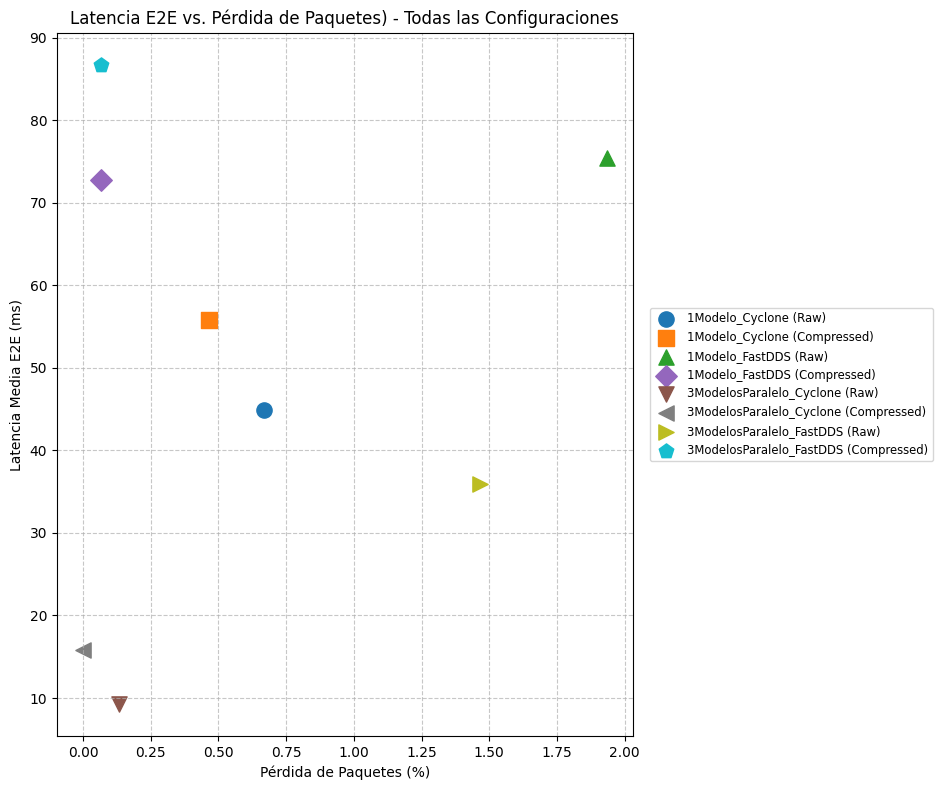


Generando gráfico de barras de latencia E2E (Raw vs. Compressed)...


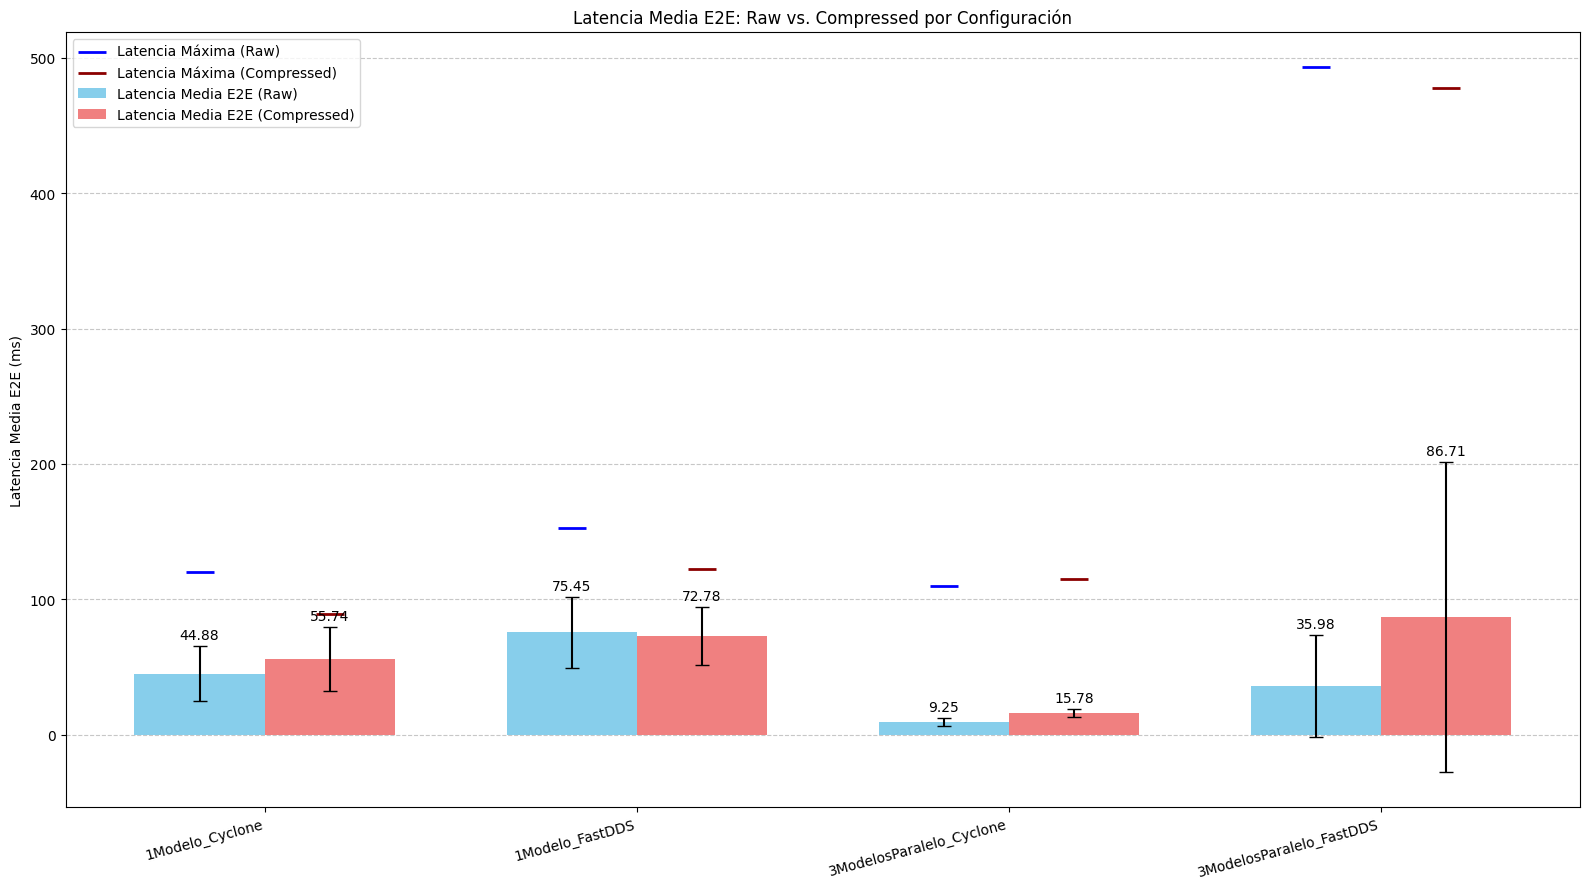


Generando gráfico de latencia vs. pérdida (calculada) para compresión: compressed


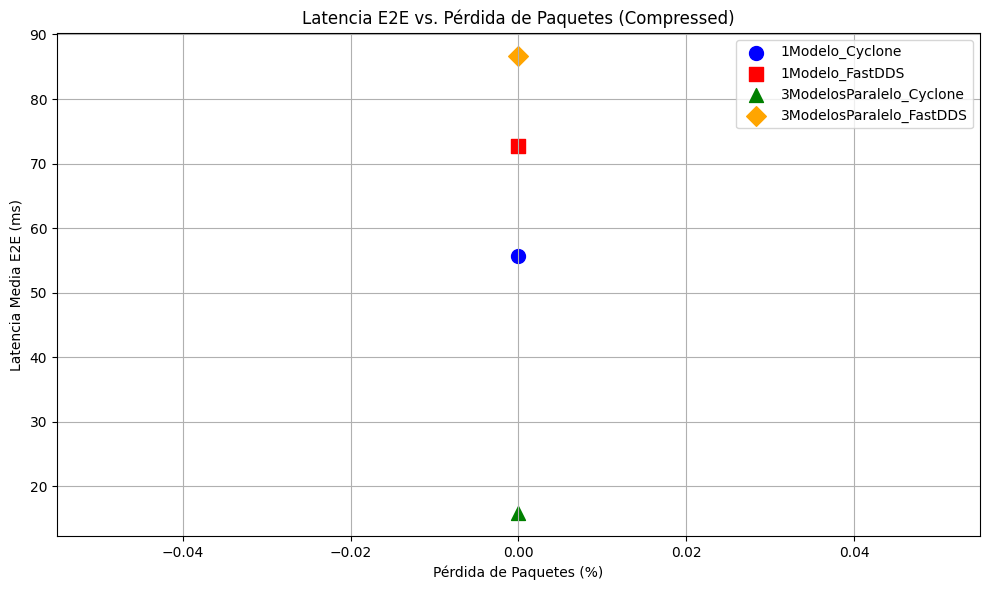


Generando gráfico de latencia vs. pérdida (calculada) para compresión: raw


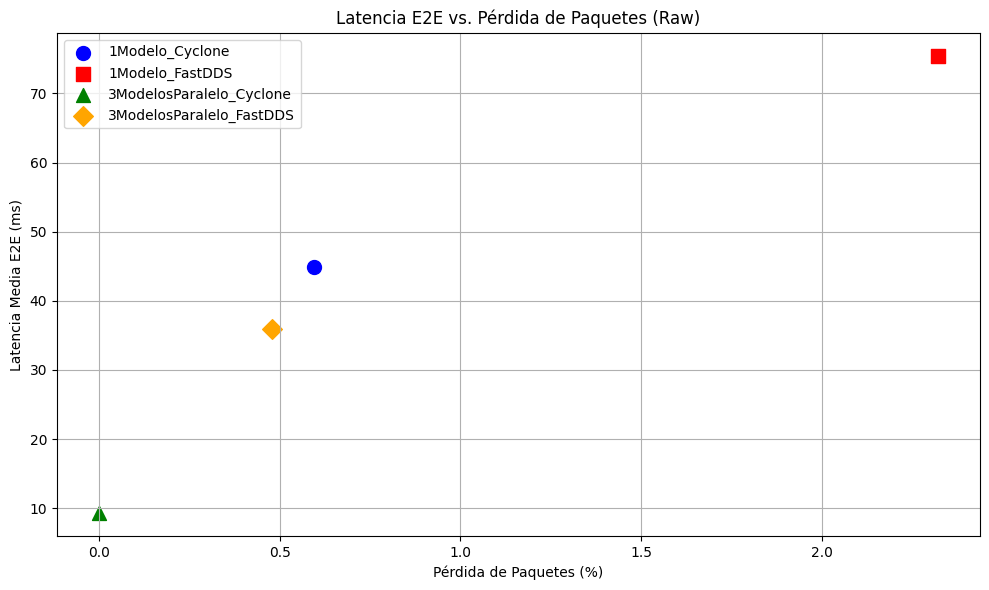


Generando gráfico agregado de métricas de CPU/GPU...


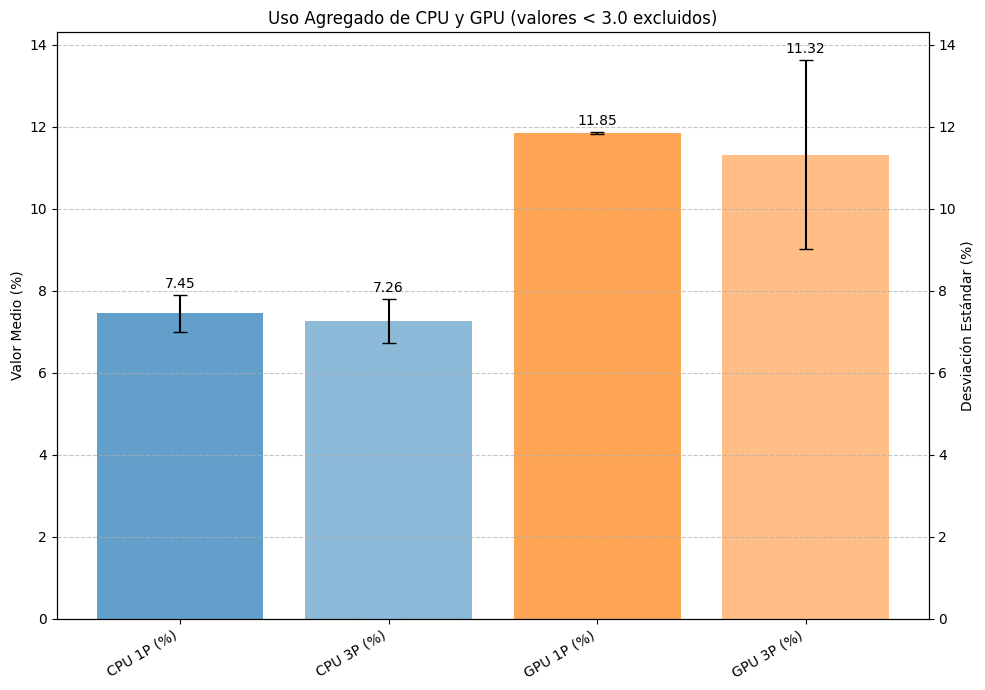


Generando gráfico agregado de métricas de Ancho de Banda...


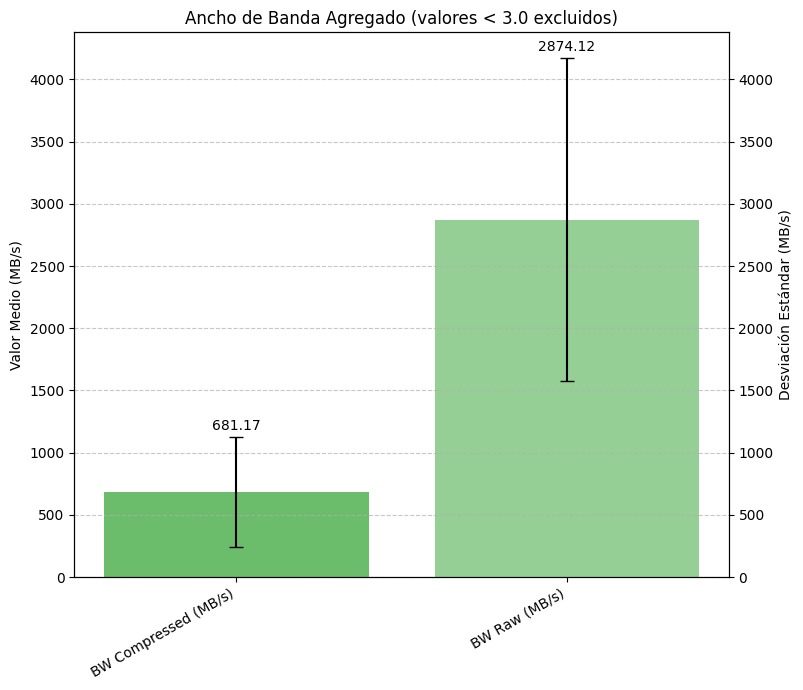


Generando gráficos de métricas de sistema para compresión: compressed


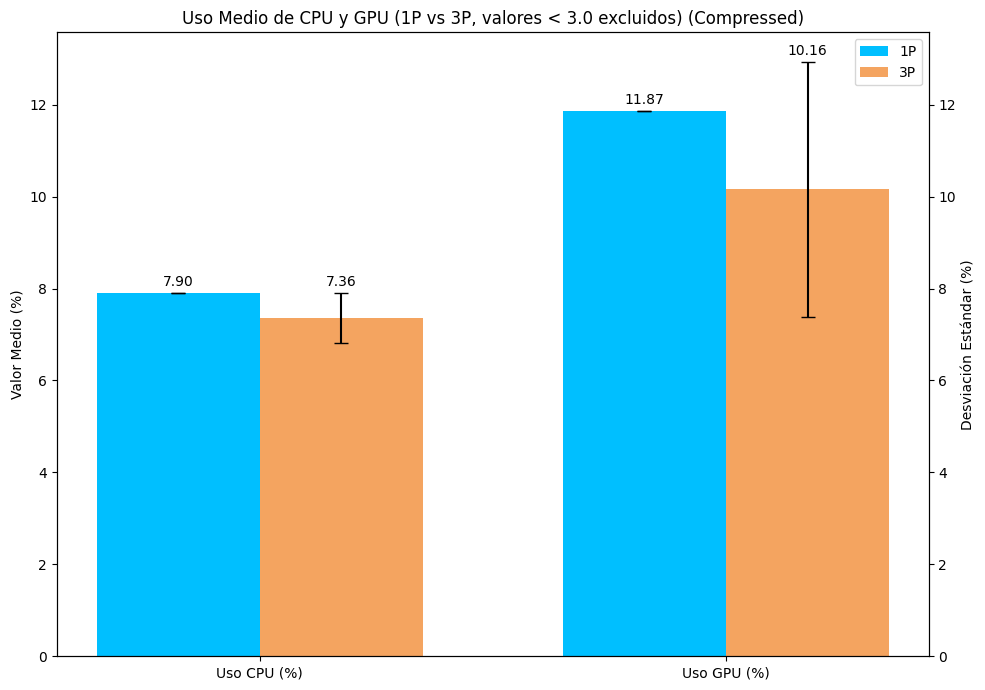

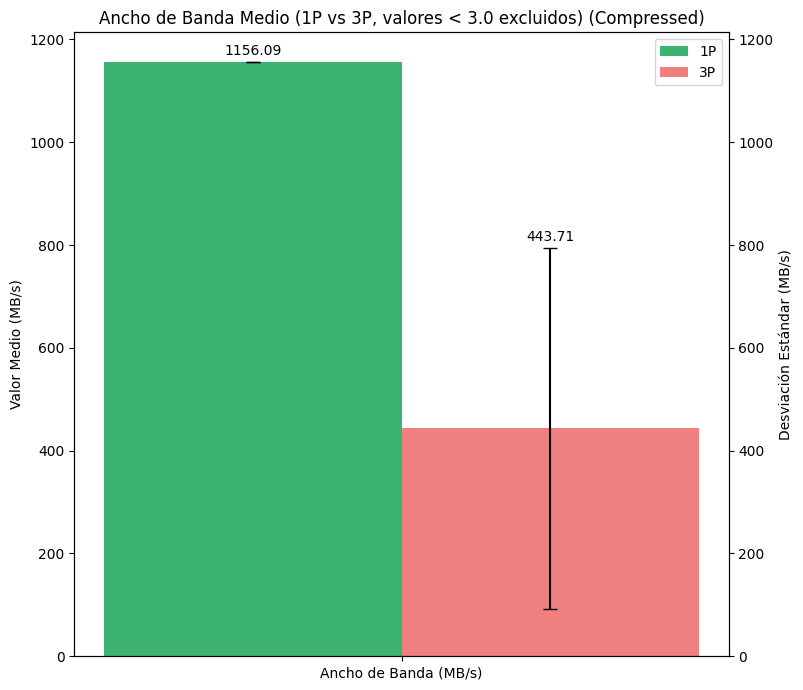


Generando gráficos de métricas de sistema para compresión: raw


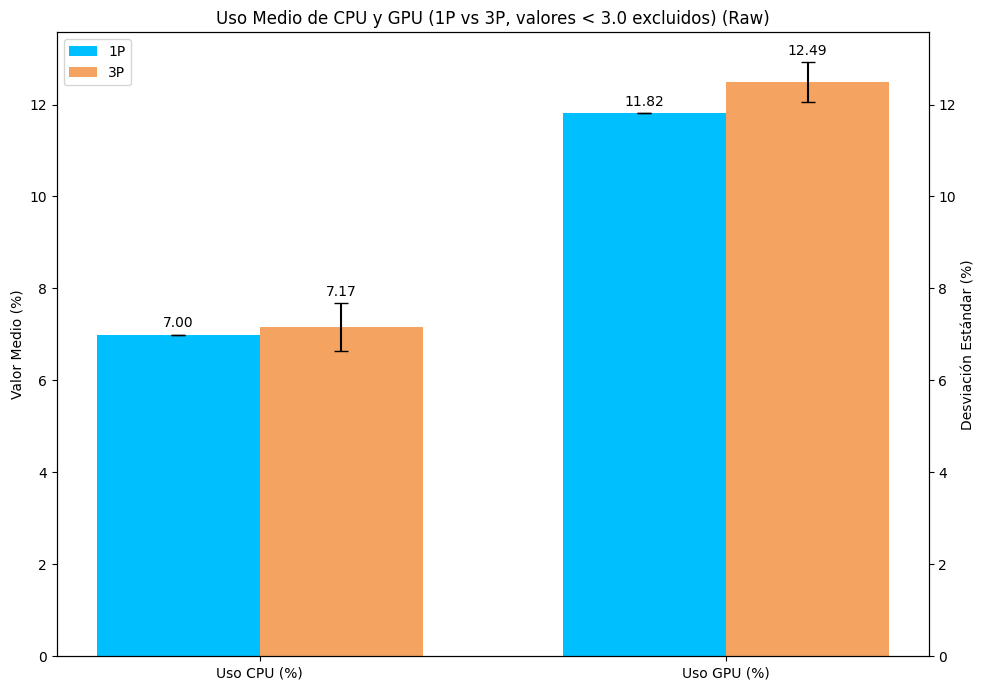

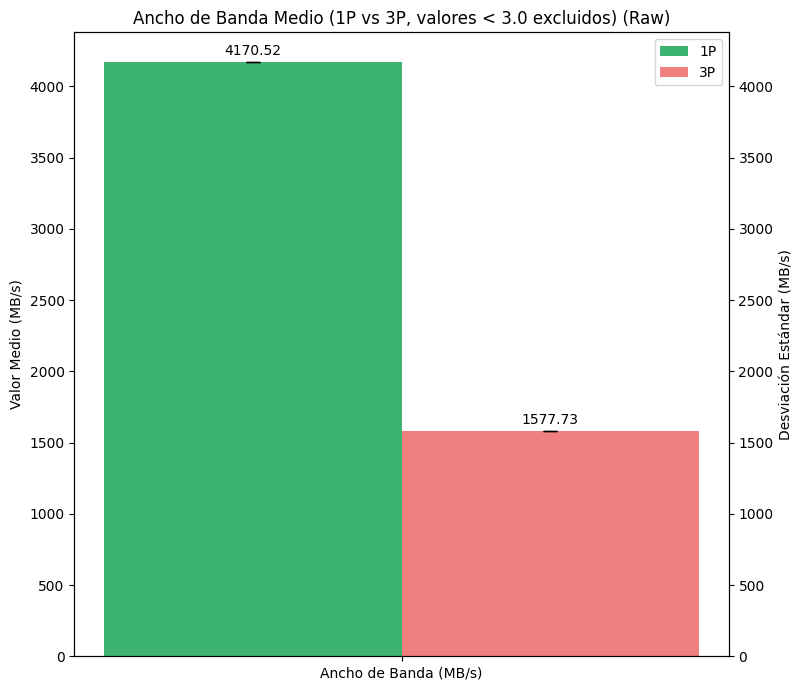

In [92]:
# --- Script Principal ---
if __name__ == "__main__":
    # Aquí debes poner las rutas a TUS archivos CSV.
    # El script intentará adivinar la configuración a partir del nombre del archivo.
    # Asegúrate de que los nombres sigan el patrón esperado.
    
    # EJEMPLO DE RUTAS DE ARCHIVO (reemplaza con las tuyas)
    # Deberías tener un conjunto de archivos para 'compressed' y otro para 'raw' si quieres comparar ambos.
    # Por ahora, el script generará gráficos para cada tipo de compresión que encuentre.
    
    mediciones_car_path = "mediciones_car"
    mediciones_local_path = "mediciones_local"

    # Lista completa de archivos de latencia a considerar
    # Principalmente de mediciones_car y que sigan el patrón *_POST.csv
    latency_files_input = [
        os.path.join(mediciones_car_path, "latency_log_car_1P_CCC_compressed_POST.csv"),
        os.path.join(mediciones_car_path, "latency_log_car_1P_FFF_compressed_POST.csv"),
        os.path.join(mediciones_car_path, "latency_log_car_3P_CCC_COMPRESSED_POST.csv"),
        os.path.join(mediciones_car_path, "latency_log_car_3P_FFF_COMPRESSED_POST.csv"),
        os.path.join(mediciones_car_path, "latency_log_car_1P_CCC_raw_POST.csv"),
        os.path.join(mediciones_car_path, "latency_log_car_1P_FFF_raw_POST.csv"),
        os.path.join(mediciones_car_path, "latency_log_car_3P_CCC_RAW_POST.csv"),
        os.path.join(mediciones_car_path, "latency_log_car_3P_FFF_RAW_POST.csv"),
        # Archivos de mediciones_car que no son _POST (probablemente no se usarán por el parser actual)
        os.path.join(mediciones_car_path, "latency_log_car_1P_CCC_compressed_2.csv"),
        os.path.join(mediciones_car_path, "latency_log_car_1P_CCC_compressed.csv"),
        os.path.join(mediciones_car_path, "latency_log_car_1P_FCC_local.csv"), # Parser actual no maneja FCC
        os.path.join(mediciones_car_path, "latency_log_car_1P_FFF_COMPRESSED_POST_not sure.csv"), # Nombre no estándar
        os.path.join(mediciones_car_path, "latency_log_car_3P_CCC_compressed.csv"),
        os.path.join(mediciones_car_path, "latency_log_car_3P_FCC_compressed.csv"), # Parser actual no maneja FCC
        # Archivos de mediciones_local que parecen de latencia pero no siguen el patrón _car_..._POST
        # El parser de latencia actual los ignorará. Si deben ser procesados como latencia,
        # el parser necesitaría ser ajustado o estos archivos renombrados.
        os.path.join(mediciones_local_path, "latency_local_car_3P_CCC_raw_.csv"), # No es _POST, nombre ligeramente diferente
        os.path.join(mediciones_local_path, "latency_log_1p_local_C_compressed_1.csv"),
        os.path.join(mediciones_local_path, "latency_log_1p_local_C_raw_1.csv"),
        os.path.join(mediciones_local_path, "latency_log_3p_local_F_compressed_2.csv"),
        os.path.join(mediciones_local_path, "latency_log_3p_local_F_compressed_3.csv"),
        os.path.join(mediciones_local_path, "latency_log_3p_local_F_compressed.csv"),
        os.path.join(mediciones_local_path, "latency_log_3p_local_F_raw_2.csv"),
        os.path.join(mediciones_local_path, "latency_log_3p_local_F_raw_3.csv"),
        os.path.join(mediciones_local_path, "latency_log_3p_local_F_raw.csv"),
        os.path.join(mediciones_local_path, "latency_log_system_3p_local_C_compressed_1.csv"), # Nombre mixto
        os.path.join(mediciones_local_path, "latency_log_system_metrics_log_3p_local_C_compressed_2.csv"), # Nombre mixto
        os.path.join(mediciones_local_path, "latency_log_system_metrics_log_3p_local_C_raw_2.csv"), # Nombre mixto
    ]

    # Lista completa de archivos de métricas de sistema a considerar
    system_files_input = [
        os.path.join(mediciones_local_path, "3p_local_c_raw.csv"),
        os.path.join(mediciones_local_path, "3p_local_F_raw.csv"),
        os.path.join(mediciones_local_path, "system_metrics_1p_local_C_compressed_2.csv"),
        os.path.join(mediciones_local_path, "system_metrics_log_1p_local_C_compressed_1.csv"),
        os.path.join(mediciones_local_path, "system_metrics_log_1p_local_C_compressed_2.csv"), # Duplicado de system_metrics_1p...?
        os.path.join(mediciones_local_path, "system_metrics_log_1p_local_C_raw_1.csv"),
        os.path.join(mediciones_local_path, "system_metrics_log_3p_local_C_compressed_1.csv"),
        os.path.join(mediciones_local_path, "system_metrics_log_3p_local_F_compressed_3.csv"),
        os.path.join(mediciones_local_path, "system_metrics_log_3p_local_F_compressed.csv"),
        os.path.join(mediciones_local_path, "system_metrics_log_3p_local_F_raw_2.csv"),
        os.path.join(mediciones_local_path, "system_metrics_log_3p_local_F_raw_3.csv"),
        os.path.join(mediciones_local_path, "system_metrics_log_system_metrics_log_3p_local_C_compressed_2.csv"),
        os.path.join(mediciones_local_path, "system_metrics_log_system_metrics_log_3p_local_C_raw_2.csv"),
        # Los archivos con "latency_log" en el nombre de mediciones_local no se listan aquí
        # ya que el parser de system_filename probablemente los ignoraría o los trataría incorrectamente.
        # Si alguno de esos debe ser tratado como system_metrics, se necesitaría ajustar el parser.
    ]

    # Filtrar archivos que no existen para evitar errores
    latency_files = [f for f in latency_files_input if os.path.exists(f)]
    system_files = [f for f in system_files_input if os.path.exists(f)]

    # Se elimina la lógica de fallback de archivos de ejemplo
    # Ahora se procesarán los archivos explícitamente listados arriba que existan
    # y puedan ser parseados.

    if not latency_files and not system_files:
        print("No se encontraron archivos CSV válidos o existentes en las listas especificadas para procesar.")
        print("Verifica las rutas y nombres en 'latency_files_input' y 'system_files_input' en el script,")
        print("y asegúrate de que los parsers pueden interpretar los nombres de archivo deseados.")
        exit()

    all_data_latency = defaultdict(dict)
    all_data_system = defaultdict(dict)
    
    processed_configs_latency = set()
    processed_configs_system = set()

    print("Procesando archivos de latencia...")
    for f_path in latency_files:
        config = parse_latency_filename(f_path)
        if config:
            key = f"{config['arch']}-{config['dds']}-{config['compression']}"
            print(f"  Archivo: {f_path} -> Config: {key}")
            data = process_latency_file(f_path)
            if data:
                all_data_latency[key] = data
                processed_configs_latency.add(config['compression'])
        else:
            print(f"  No se pudo parsear el nombre del archivo de latencia: {f_path}")

    print("\nProcesando archivos de métricas del sistema...")
    for f_path in system_files:
        config = parse_system_filename(f_path)
        if config:
            key = f"{config['arch']}-{config['dds']}-{config['compression']}" # Clave completa para almacenar
            print(f"  Archivo: {f_path} -> Config: {key}")
            data = process_system_file(f_path)
            if data:
                all_data_system[key] = data # Almacenar con clave completa
                processed_configs_system.add(config['compression'])
        else:
            print(f"  No se pudo parsear el nombre del archivo de sistema: {f_path}")

    # Generar gráficos para cada tipo de compresión encontrado
    # Primero para latencia
    unique_compressions_latency = processed_configs_latency
    
    if not all_data_latency:
        print("\nNo hay datos de latencia procesados para generar gráficos.")
    else:
        # Nuevo gráfico: Latencia a lo largo del tiempo para todas las configuraciones
        print(f"\nGenerando gráfico de latencia vs. pérdida MANUAL para TODAS las configuraciones...")
        plot_latency_vs_manual_loss_scatter(all_data_latency) # Esta es la llamada correcta para el gráfico unificado

        # Nuevo gráfico de barras comparando Raw vs Compressed para todas las configuraciones base
        print("\nGenerando gráfico de barras de latencia E2E (Raw vs. Compressed)...")
        plot_latency_bars(all_data_latency) # <--- LLAMADA UNIFICADA CORRECTA (1 argumento)

        # El bucle original para plot_latency_bars por comp_type se elimina o se ajusta.
        # Mantenemos el bucle si queremos plot_latency_vs_loss_scatter por comp_type.
        for comp_type in unique_compressions_latency:
            # print(f"\nGenerando gráficos de latencia para compresión: {comp_type}") # Mensaje original
            # Filtrar datos para el tipo de compresión actual
            current_compression_latency_data = {k: v for k, v in all_data_latency.items() if k.endswith(comp_type)}
            if current_compression_latency_data:
                # plot_latency_bars(current_compression_latency_data, comp_type) # <--- ELIMINAR ESTA LÍNEA, causa el TypeError
                
                # Generar gráfico de latencia vs. pérdida (calculada) por tipo de compresión
                print(f"\nGenerando gráfico de latencia vs. pérdida (calculada) para compresión: {comp_type}")
                plot_latency_vs_loss_scatter(current_compression_latency_data, comp_type)
                # La llamada a plot_latency_vs_manual_loss_scatter dentro del bucle ya fue eliminada correctamente.
            else:
                # Ajustar mensaje si solo se genera el scatter plot aquí
                print(f"  No hay datos de latencia para {comp_type} para el gráfico de latencia vs. pérdida (calculada).")



    # Luego para métricas de sistema
    unique_compressions_system = processed_configs_system
    if not all_data_system:
        print("\nNo hay datos de métricas de sistema procesados para generar gráficos.")
    else:
        # Nuevos gráficos agregados para métricas de sistema
        print("\nGenerando gráfico agregado de métricas de CPU/GPU...")
        plot_aggregated_cpu_gpu_metrics(all_data_system)
        
        print("\nGenerando gráfico agregado de métricas de Ancho de Banda...")
        plot_aggregated_bandwidth_metrics(all_data_system)

        for comp_type in unique_compressions_system:
            print(f"\nGenerando gráficos de métricas de sistema para compresión: {comp_type}")
            # Filtrar datos para el tipo de compresión actual
            current_compression_system_data = {k: v for k, v in all_data_system.items() if k.endswith(comp_type)}
            if current_compression_system_data:
                 plot_cpu_gpu_usage_bars(current_compression_system_data, comp_type) # Reemplazado
                 plot_bandwidth_usage_bars(current_compression_system_data, comp_type) # Añadido
            else:
                print(f"  No hay datos de sistema para {comp_type}.")

In [3]:
import subprocess
import os

def stitch_videos(video_files, output_filename):
    """
    Stitches a list of video files horizontally using ffmpeg.

    Args:
        video_files (list): A list of paths to the input video files.
                            The order in the list determines the stitching order (left to right).
        output_filename (str): The name of the output stitched video file.
    """
    if not video_files or len(video_files) < 2:
        print("Error: At least two video files are required for stitching.")
        return

    # Check if all input files exist
    for f in video_files:
        if not os.path.exists(f):
            print(f"Error: Input file {f} not found.")
            return

    # Construct the ffmpeg command
    inputs_cmd = []
    for f in video_files:
        inputs_cmd.extend(["-i", f])

    filter_complex_str = ""
    for i in range(len(video_files)):
        filter_complex_str += f"[{i}:v]"
    filter_complex_str += f"hstack=inputs={len(video_files)}[v]"

    command = [
        "ffmpeg",
        *inputs_cmd,
        "-filter_complex", filter_complex_str,
        "-map", "[v]",
        "-c:v", "libx264",  # Encoder, can be changed
        "-crf", "23",       # Constant Rate Factor (quality, lower is better)
        "-preset", "veryfast", # Encoding speed
        output_filename
    ]

    print(f"Attempting to stitch: {' '.join(video_files)} -> {output_filename}")
    print(f"Executing command: {' '.join(command)}")

    try:
        process = subprocess.run(command, check=True, capture_output=True, text=True)
        print(f"Successfully created {output_filename}")
        if process.stdout:
            print("ffmpeg stdout:\n", process.stdout)
        if process.stderr:
            print("ffmpeg stderr:\n", process.stderr) # ffmpeg often prints info to stderr
    except subprocess.CalledProcessError as e:
        print(f"Error stitching videos for {output_filename}.")
        print("ffmpeg command failed.")
        print("Return code:", e.returncode)
        print("stdout:\n", e.stdout)
        print("stderr:\n", e.stderr)
    except FileNotFoundError:
        print("Error: ffmpeg command not found. Please ensure ffmpeg is installed and in your PATH.")

if __name__ == "__main__":
    # Define input video files based on your naming convention
    # Assumes the script is run in the directory containing the videos
    # or that full paths are provided.
    
    base_path = "/home/david/ros_videos/segment_node_3P_out/" # Current directory. Change if your videos are elsewhere.

    inferred_files = [
        os.path.join(base_path, "inferred_left.avi"),
        os.path.join(base_path, "inferred_front.avi"),
        os.path.join(base_path, "inferred_right.avi")
    ]
    mask_files = [
        os.path.join(base_path, "mask_left.avi"),
        os.path.join(base_path, "mask_front.avi"),
        os.path.join(base_path, "mask_right.avi")
    ]

    # Define output video files
    output_inferred_stitched = os.path.join(base_path, "stitched_inferred.mp4")
    output_mask_stitched = os.path.join(base_path, "stitched_mask.mp4")

    print("Starting video stitching process...")

    # Stitch inferred videos
    print("\nProcessing inferred videos...")
    stitch_videos(inferred_files, output_inferred_stitched)

    # Stitch mask videos
    print("\nProcessing mask videos...")
    stitch_videos(mask_files, output_mask_stitched)

    print("\nScript finished.")

Starting video stitching process...

Processing inferred videos...
Error: Input file /home/david/ros_videos/segment_node_3P_out/inferred_left.avi not found.

Processing mask videos...
Error: Input file /home/david/ros_videos/segment_node_3P_out/mask_left.avi not found.

Script finished.


/home/david/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


--- Procesando archivos de latencia ---
  Archivo: /home/david/yolocpp_ws/tests/latency_640_416_1B_Large_Data_raw.csv -> Config: {'resolution': '640x416', 'comm_method': 'Default', 'compression': 'raw', 'arch': '1B', 'type': 'latency', 'test_type': 'standard'}
  Archivo: /home/david/yolocpp_ws/tests/latency_640_416_1B_SHM_raw.csv -> Config: {'resolution': '640x416', 'comm_method': 'SHM', 'compression': 'raw', 'arch': '1B', 'type': 'latency', 'test_type': 'standard'}
  Archivo: /home/david/yolocpp_ws/tests/latency_640_416_1B_udpv4_3p_compressed_command.csv -> Config: {'resolution': '640x416', 'comm_method': 'UDPV4', 'compression': 'compressed', 'arch': '3P', 'type': 'latency', 'test_type': 'standard'}
  Archivo: /home/david/yolocpp_ws/tests/latency_640_416_1B_udpv4_3p_raw_command.csv -> Config: {'resolution': '640x416', 'comm_method': 'UDPV4', 'compression': 'raw', 'arch': '3P', 'type': 'latency', 'test_type': 'standard'}
  Archivo: /home/david/yolocpp_ws/tests/latency_640_416_1B_udpv4_

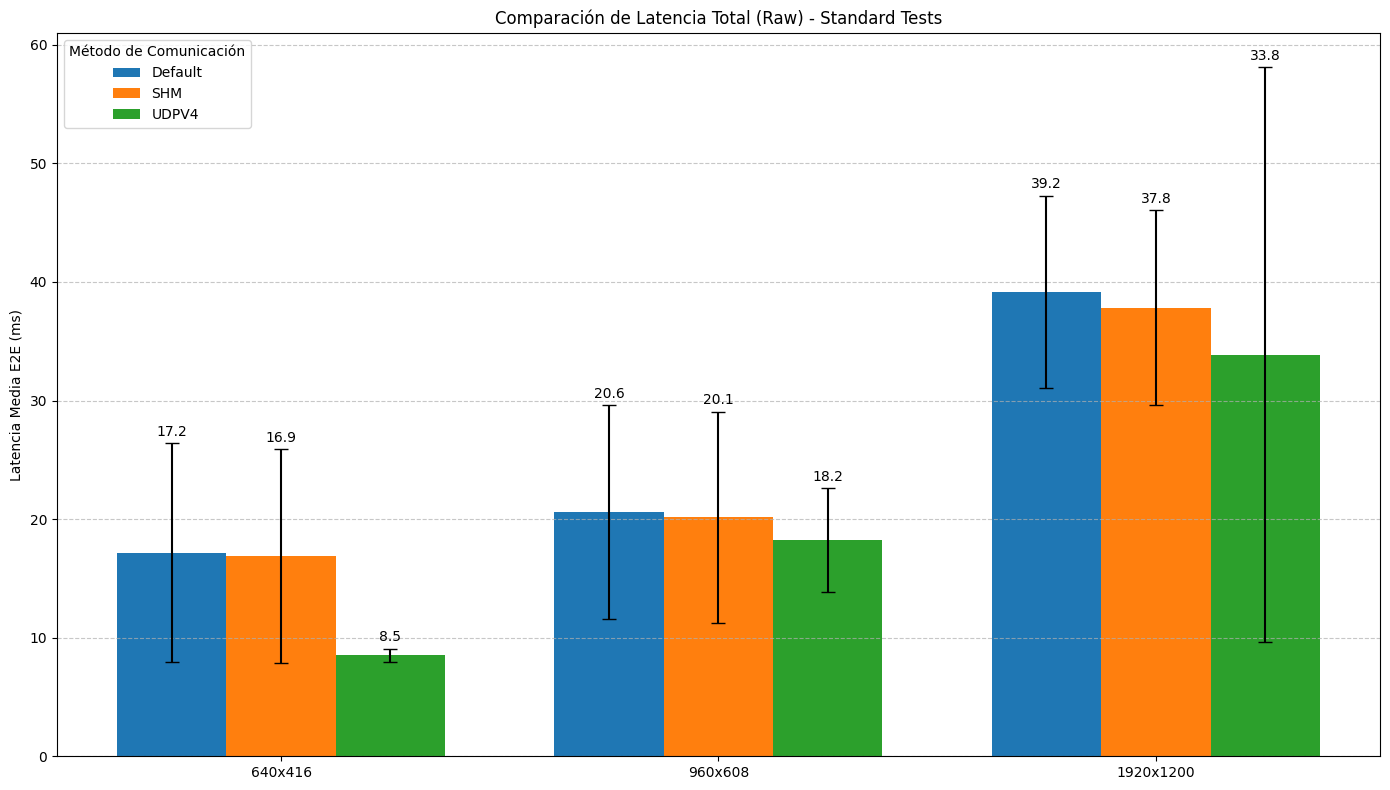


--- Generando Gráfico de Latencia Total (Compressed) - Standard Tests ---


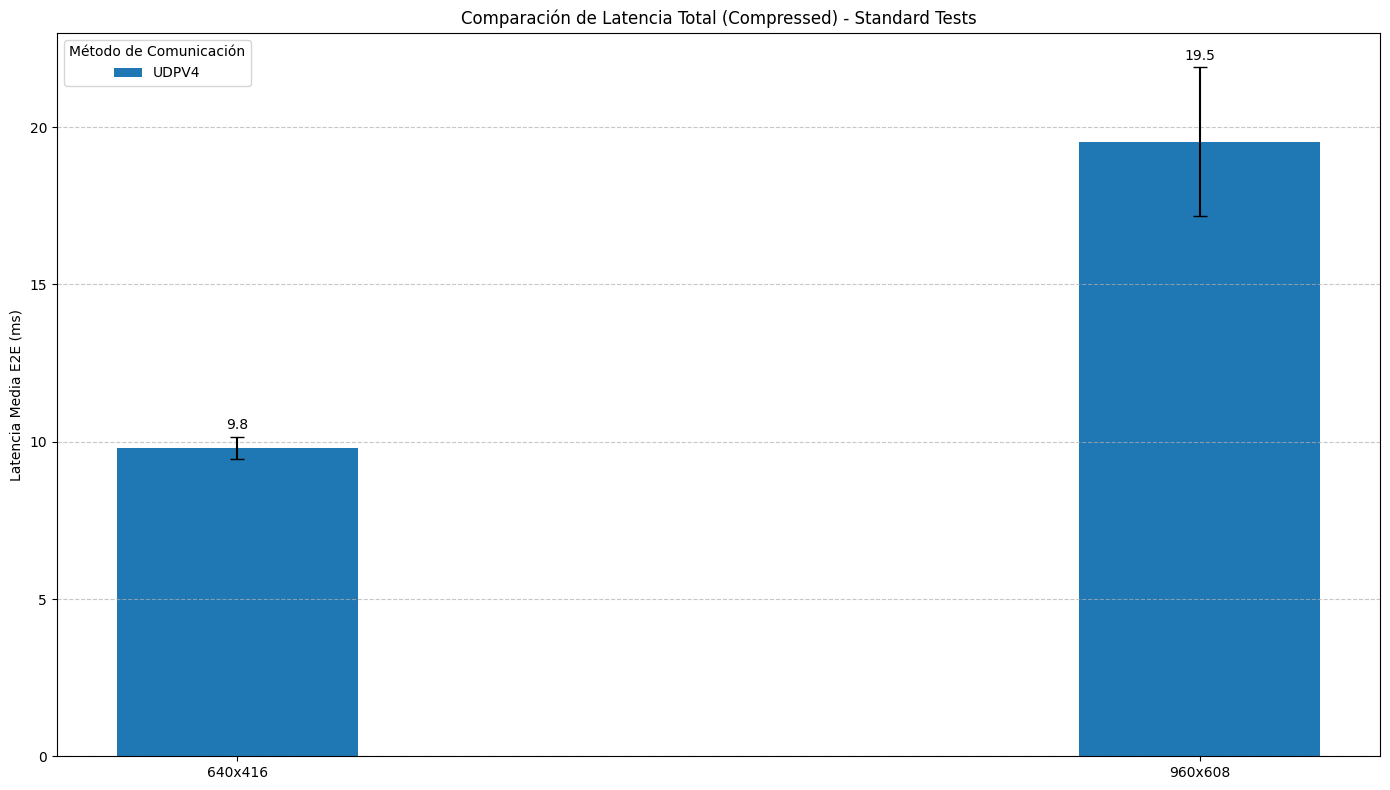


--- Generando Gráfico de Latencia de Red (Raw) - Standard Tests ---
Interpolando para 'Default' en resoluciones: ['960x608']
Interpolando para 'SHM' en resoluciones: ['960x608']


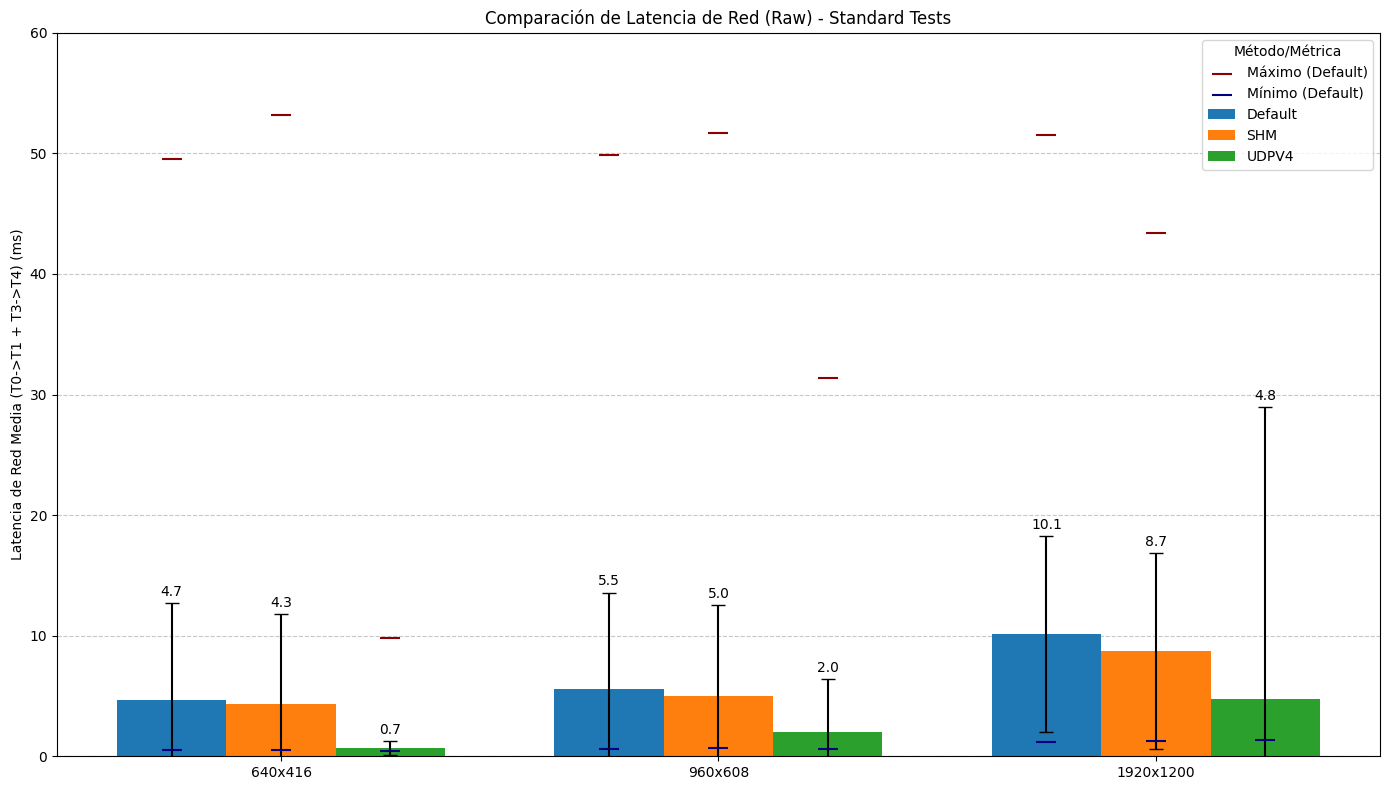


--- Generando Gráfico de Latencia de Red (Compressed) - Standard Tests ---


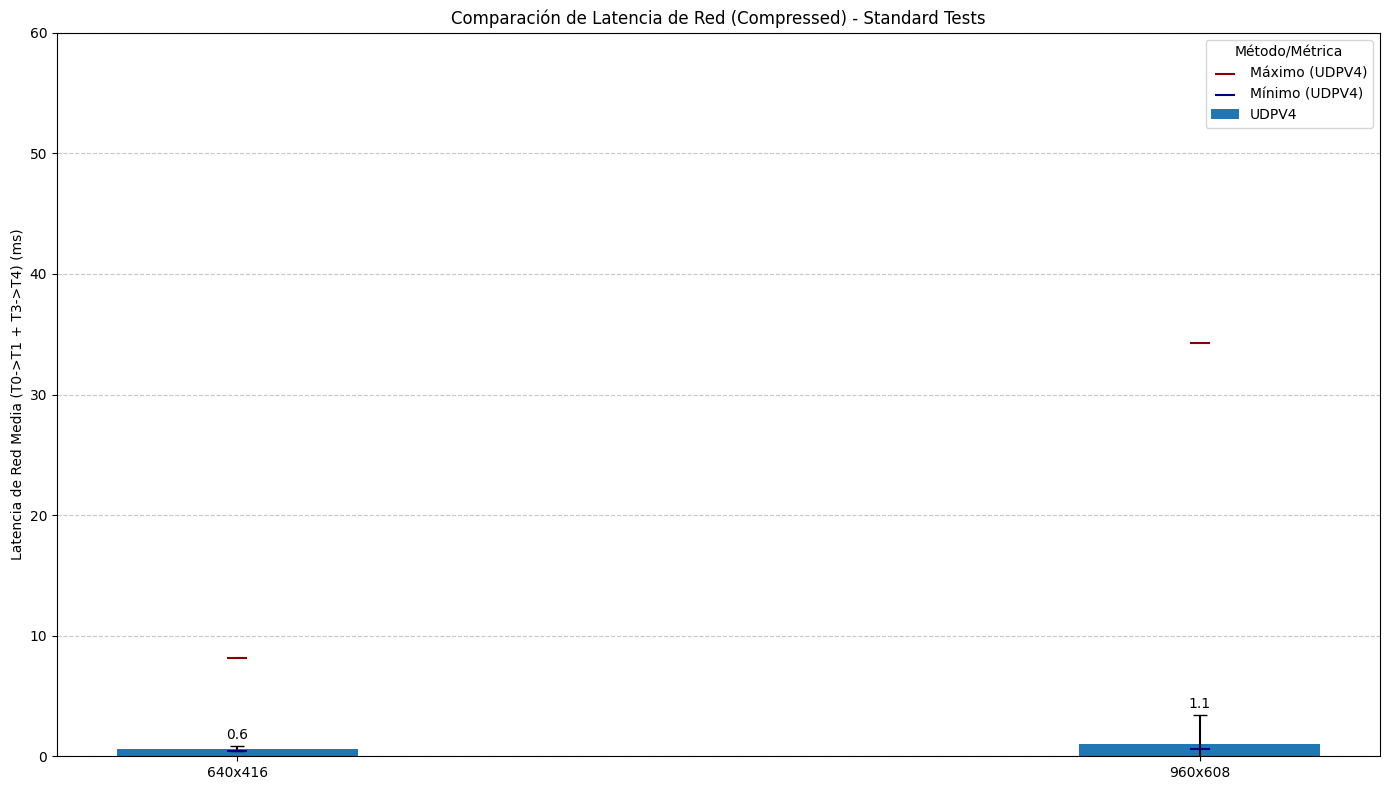


--- Generando Gráfico de Componentes de Latencia - Standard Tests ---


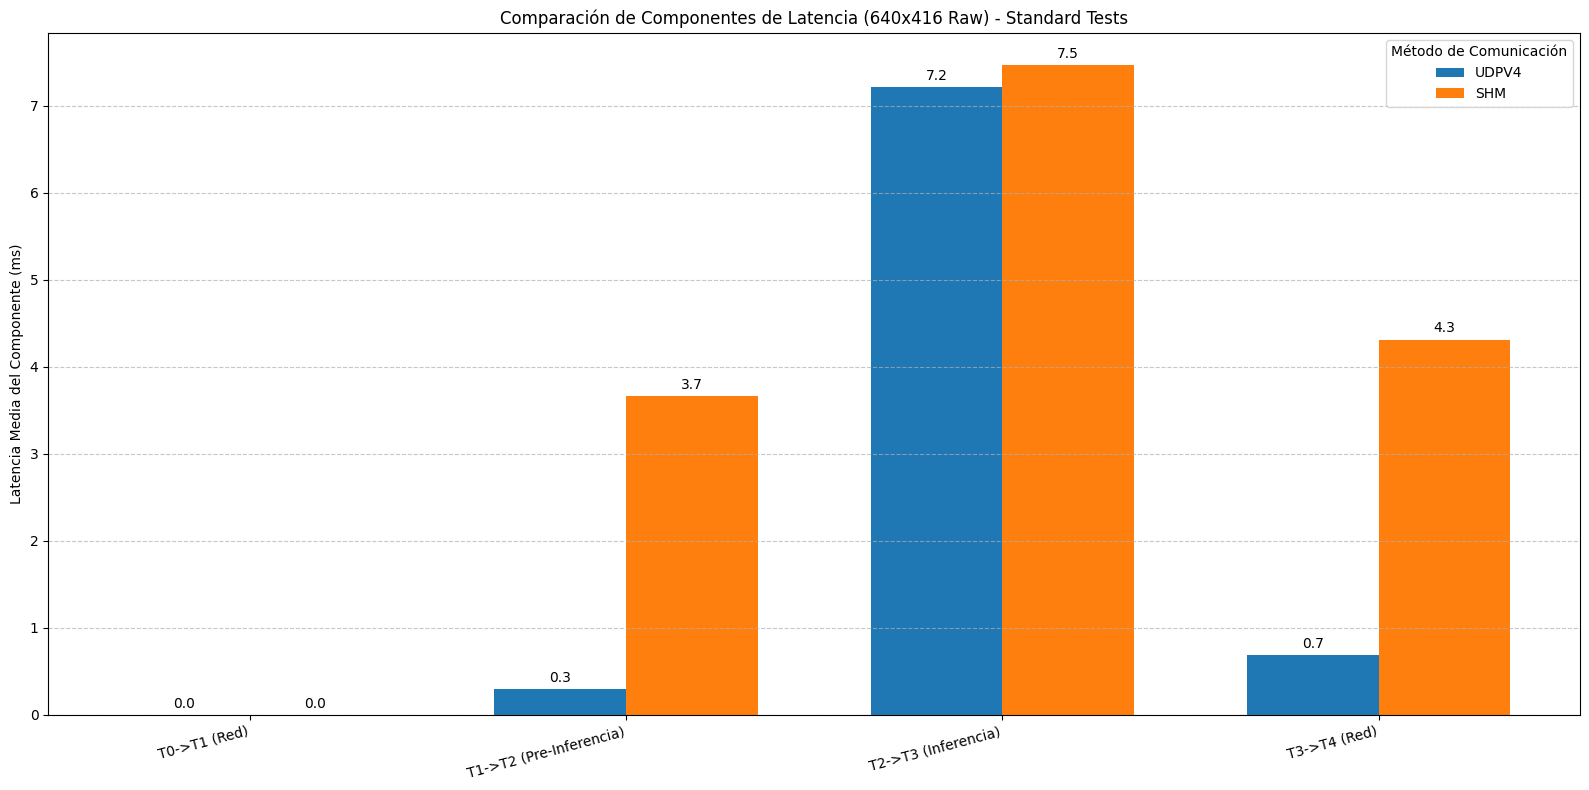


--- Generando Gráfico de Latencia en el Tiempo (Comparativa UDPV4) - Standard Tests ---
  Generando gráfico de latencia en el tiempo (0-7000 iteraciones)...


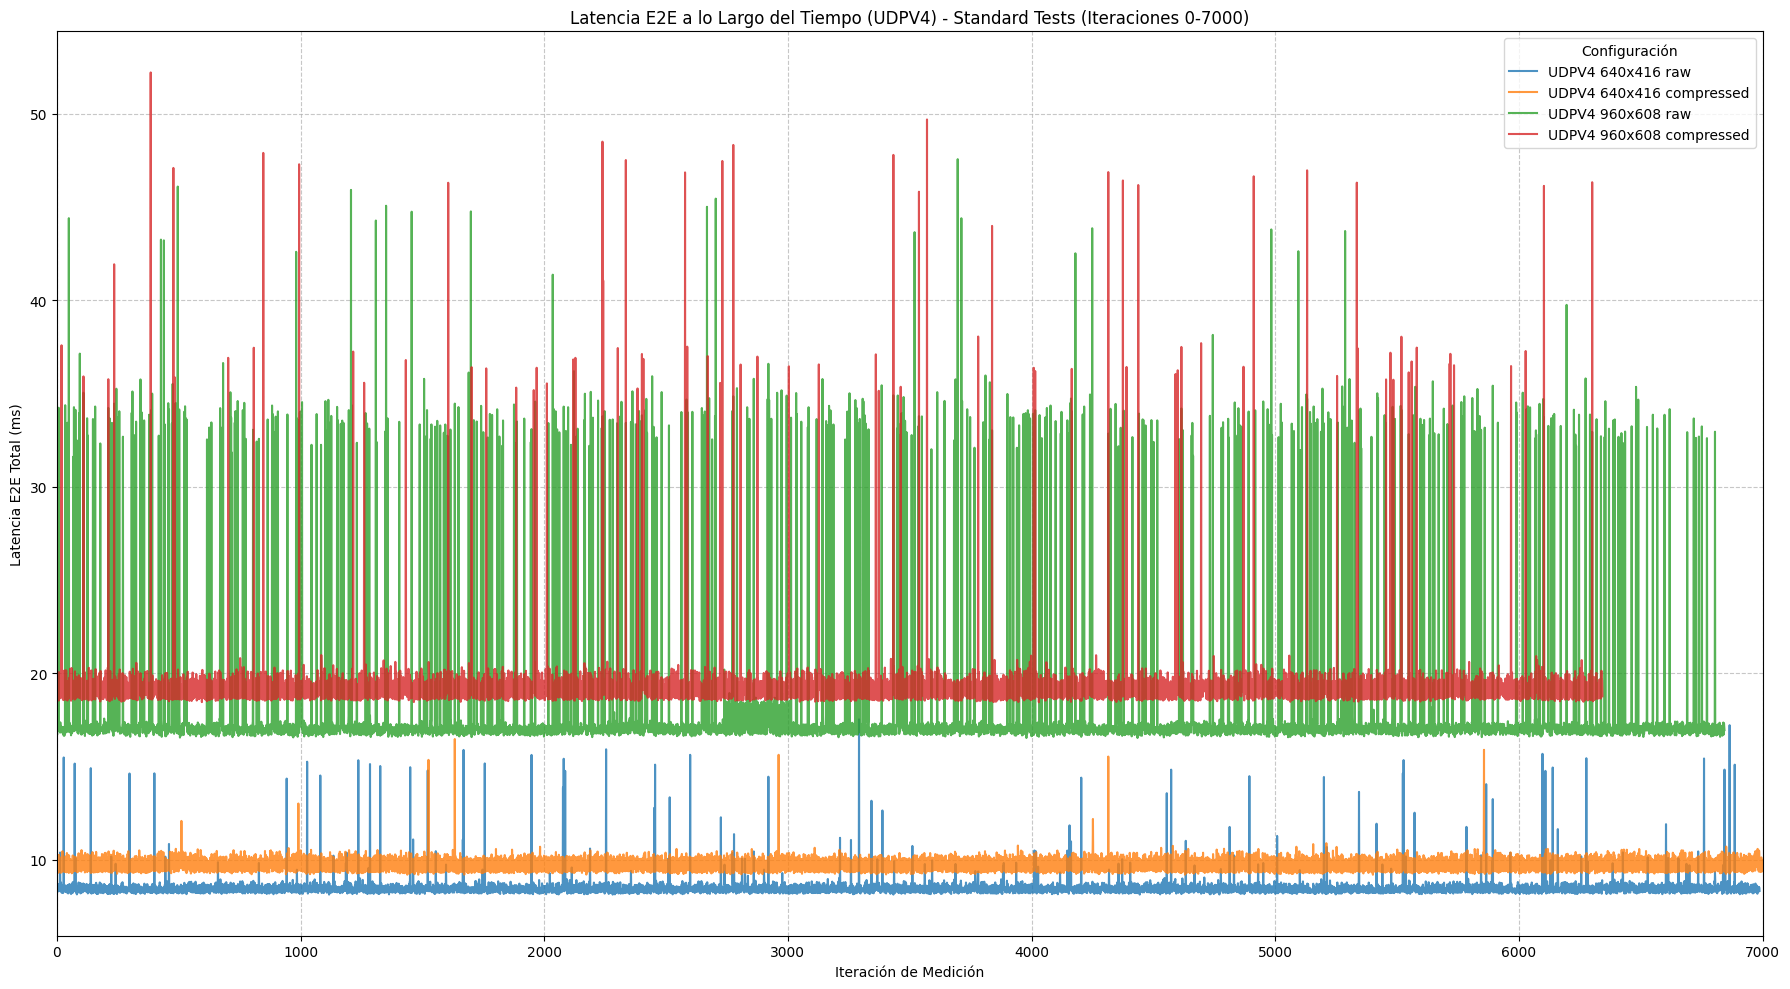

  Generando gráfico de latencia en el tiempo (0-500 iteraciones)...


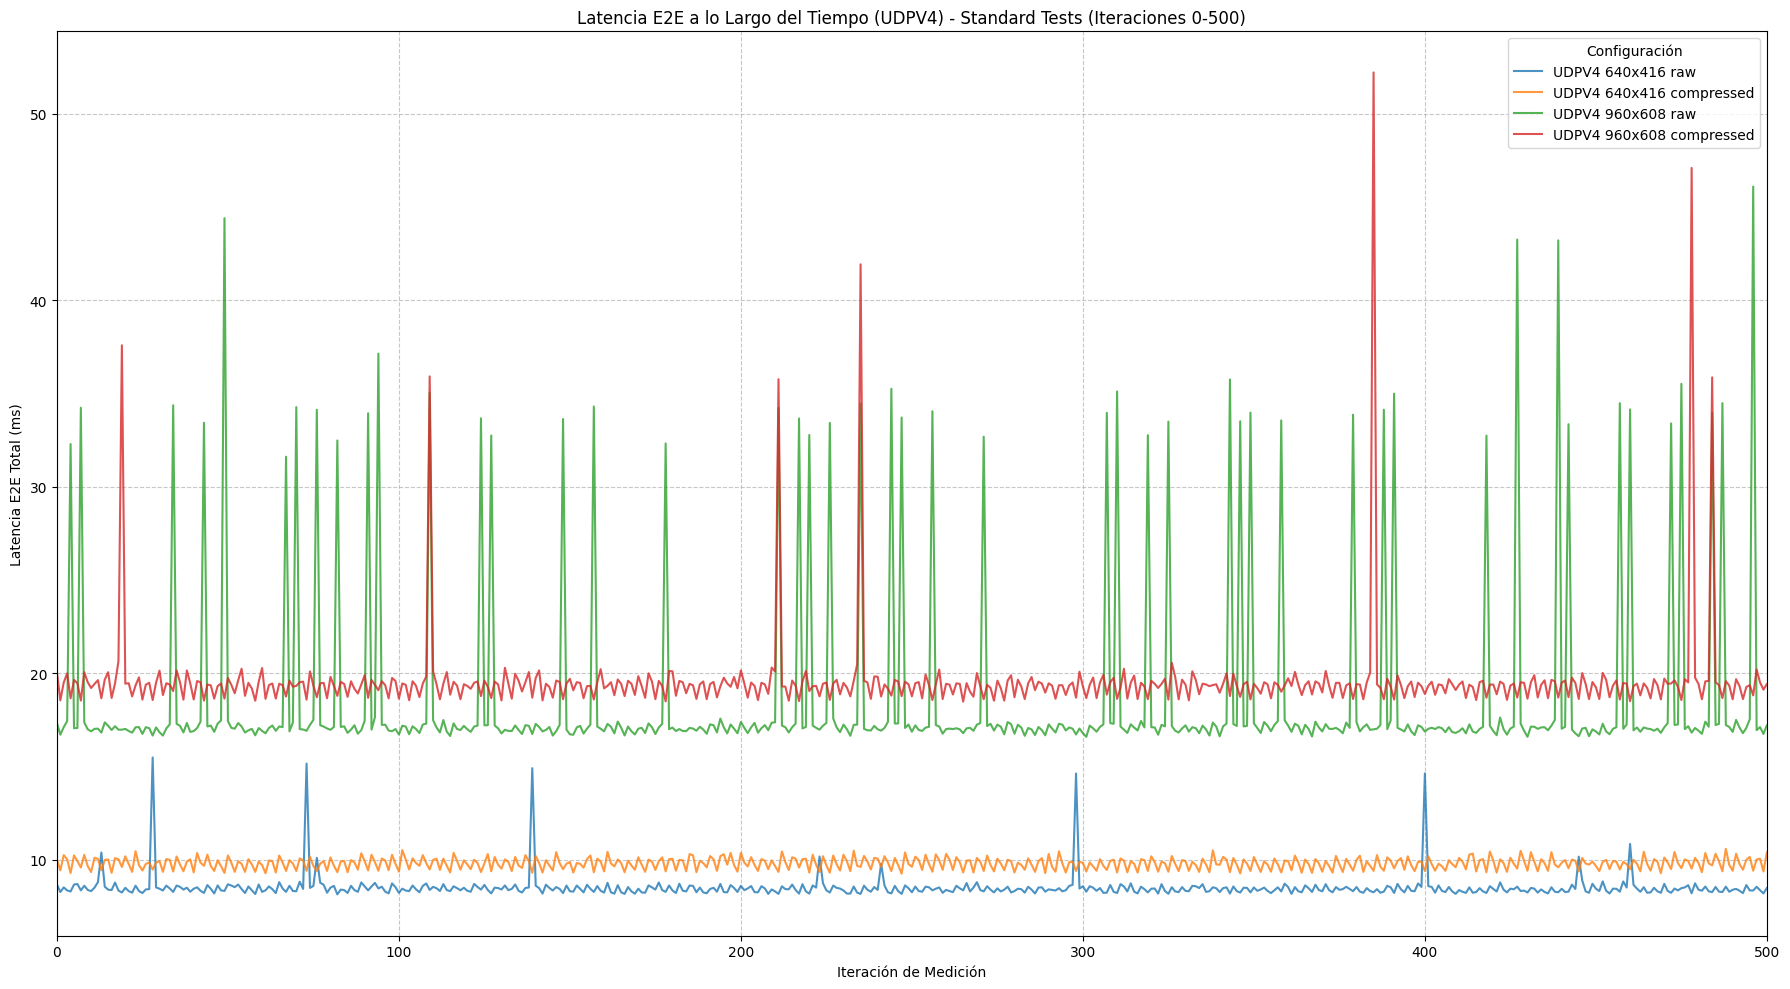


--- Generando Gráfico de Latencia Total (Raw) - Same-Topic Tests ---


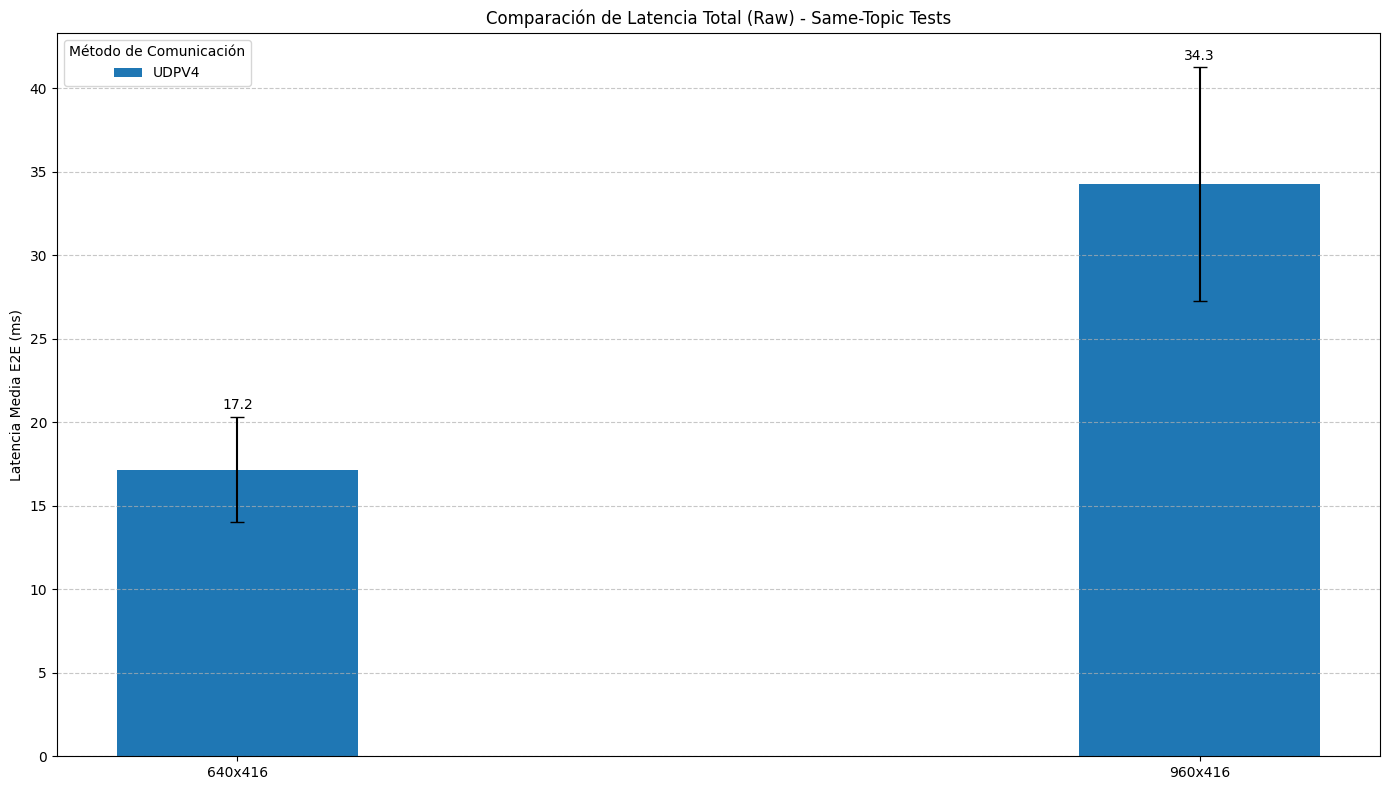


--- Generando Gráfico de Latencia Total (Compressed) - Same-Topic Tests ---
No se encontraron datos para 'compressed'.

--- Generando Gráfico de Latencia de Red (Raw) - Same-Topic Tests ---


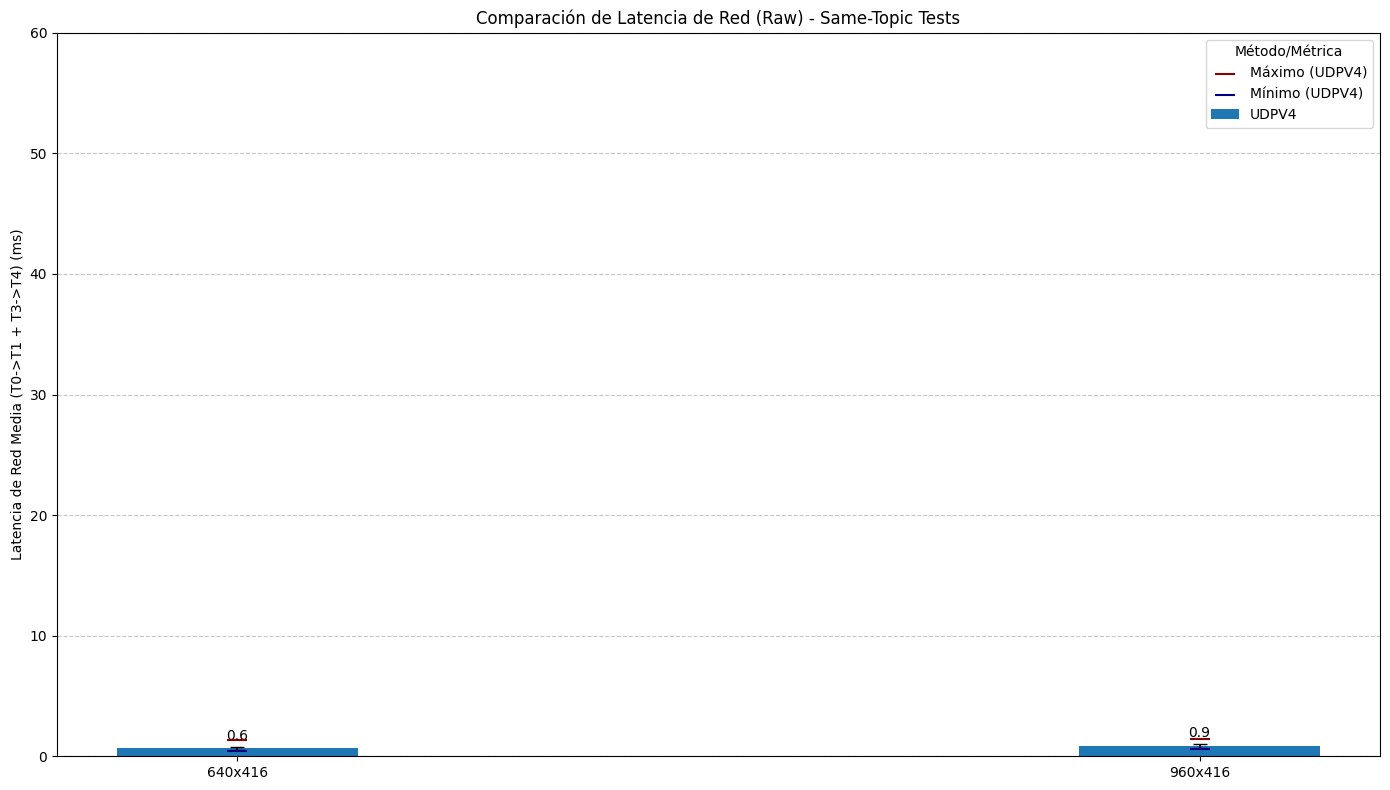


--- Generando Gráfico de Latencia de Red (Compressed) - Same-Topic Tests ---
No se encontraron datos para 'compressed' para el gráfico de latencia de red.

--- Generando Gráfico de Componentes de Latencia - Same-Topic Tests ---


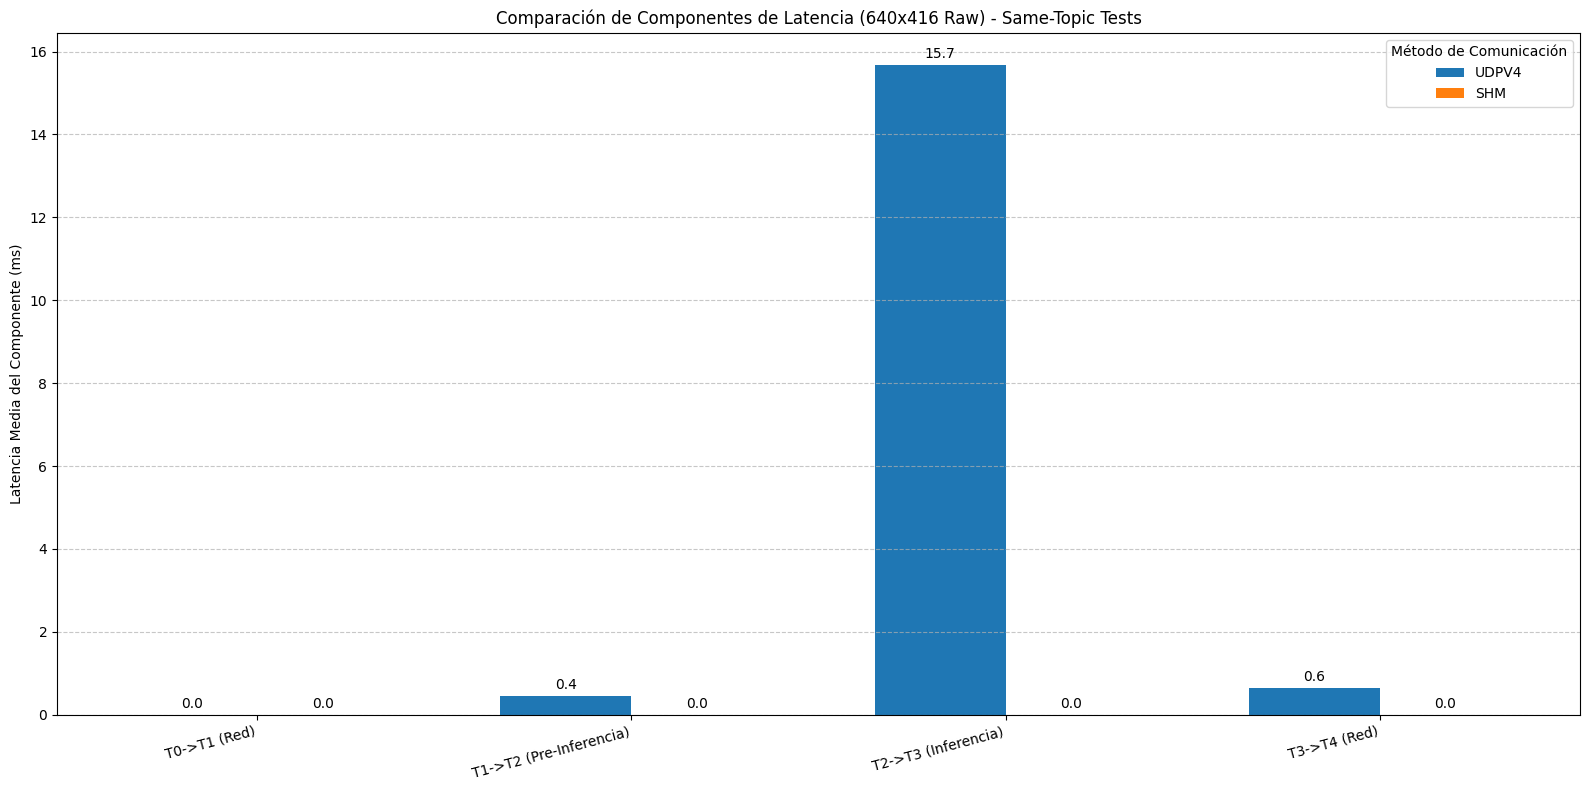


--- Generando Gráfico de Latencia en el Tiempo (Comparativa UDPV4) - Same-Topic Tests ---
  Generando gráfico de latencia en el tiempo (0-7000 iteraciones)...
Advertencia: No se encontraron datos para la configuración '640x416-compressed' en Same-Topic Tests.
Advertencia: No se encontraron datos para la configuración '960x608-raw' en Same-Topic Tests.
Advertencia: No se encontraron datos para la configuración '960x608-compressed' en Same-Topic Tests.


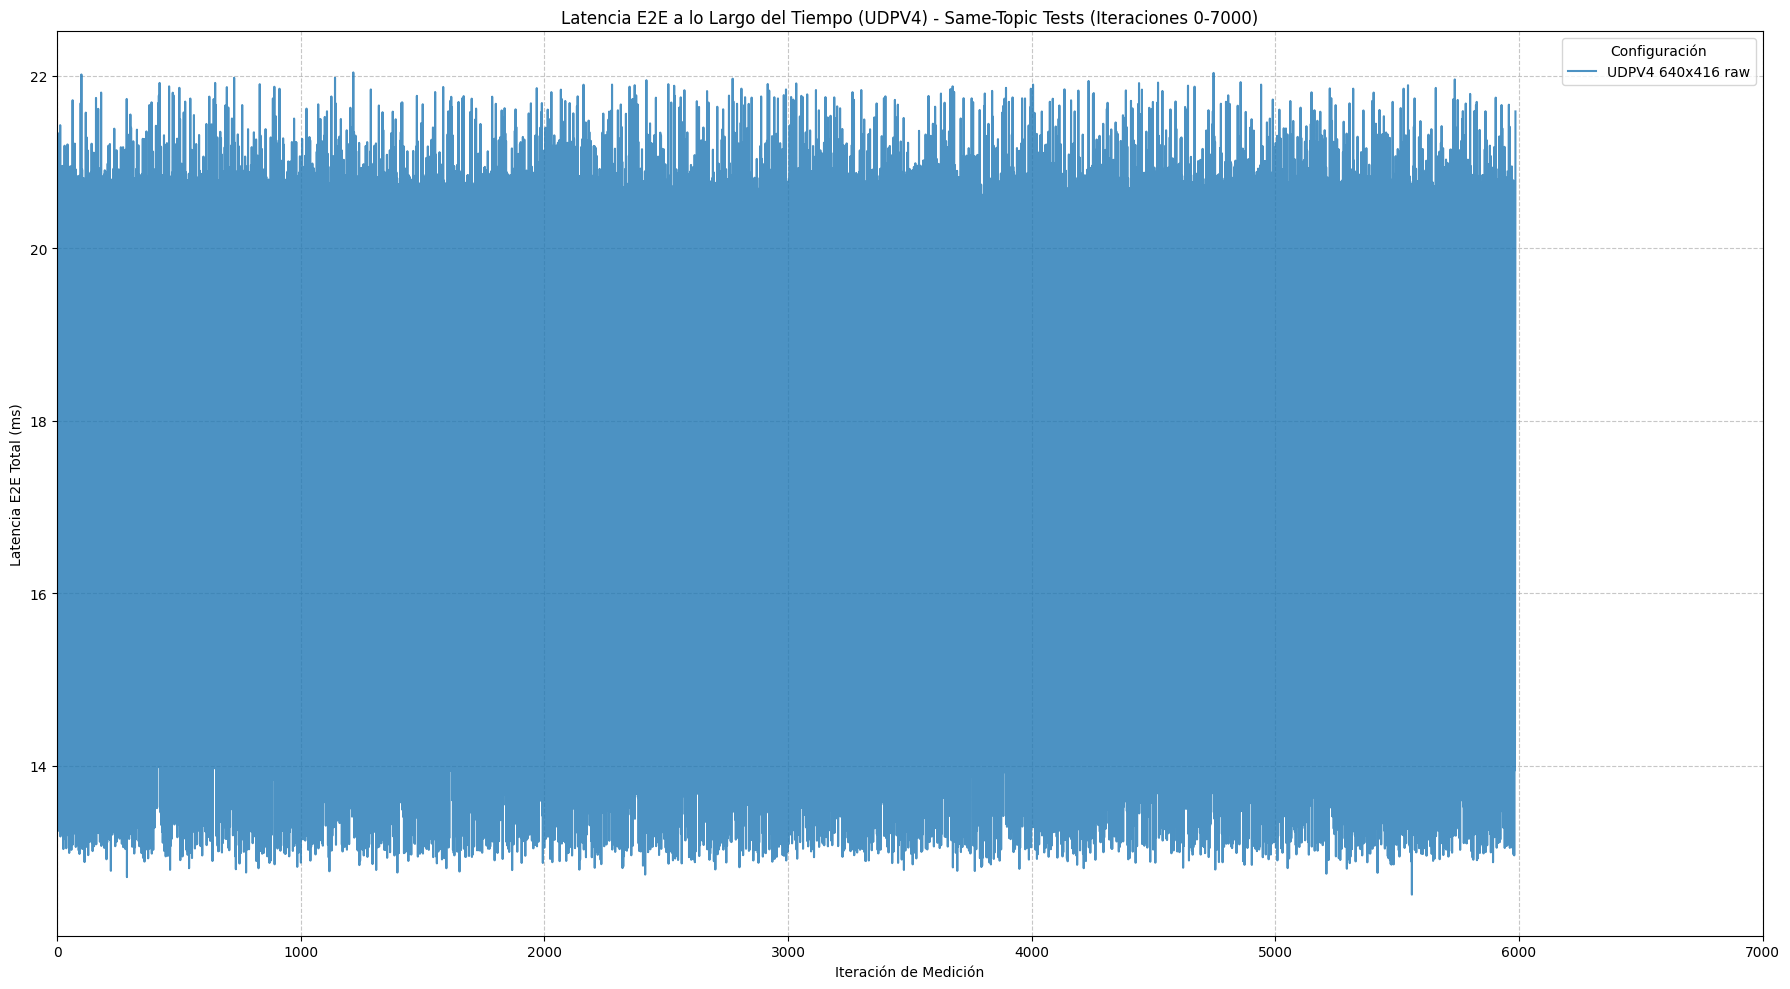

  Generando gráfico de latencia en el tiempo (0-500 iteraciones)...
Advertencia: No se encontraron datos para la configuración '640x416-compressed' en Same-Topic Tests.
Advertencia: No se encontraron datos para la configuración '960x608-raw' en Same-Topic Tests.
Advertencia: No se encontraron datos para la configuración '960x608-compressed' en Same-Topic Tests.


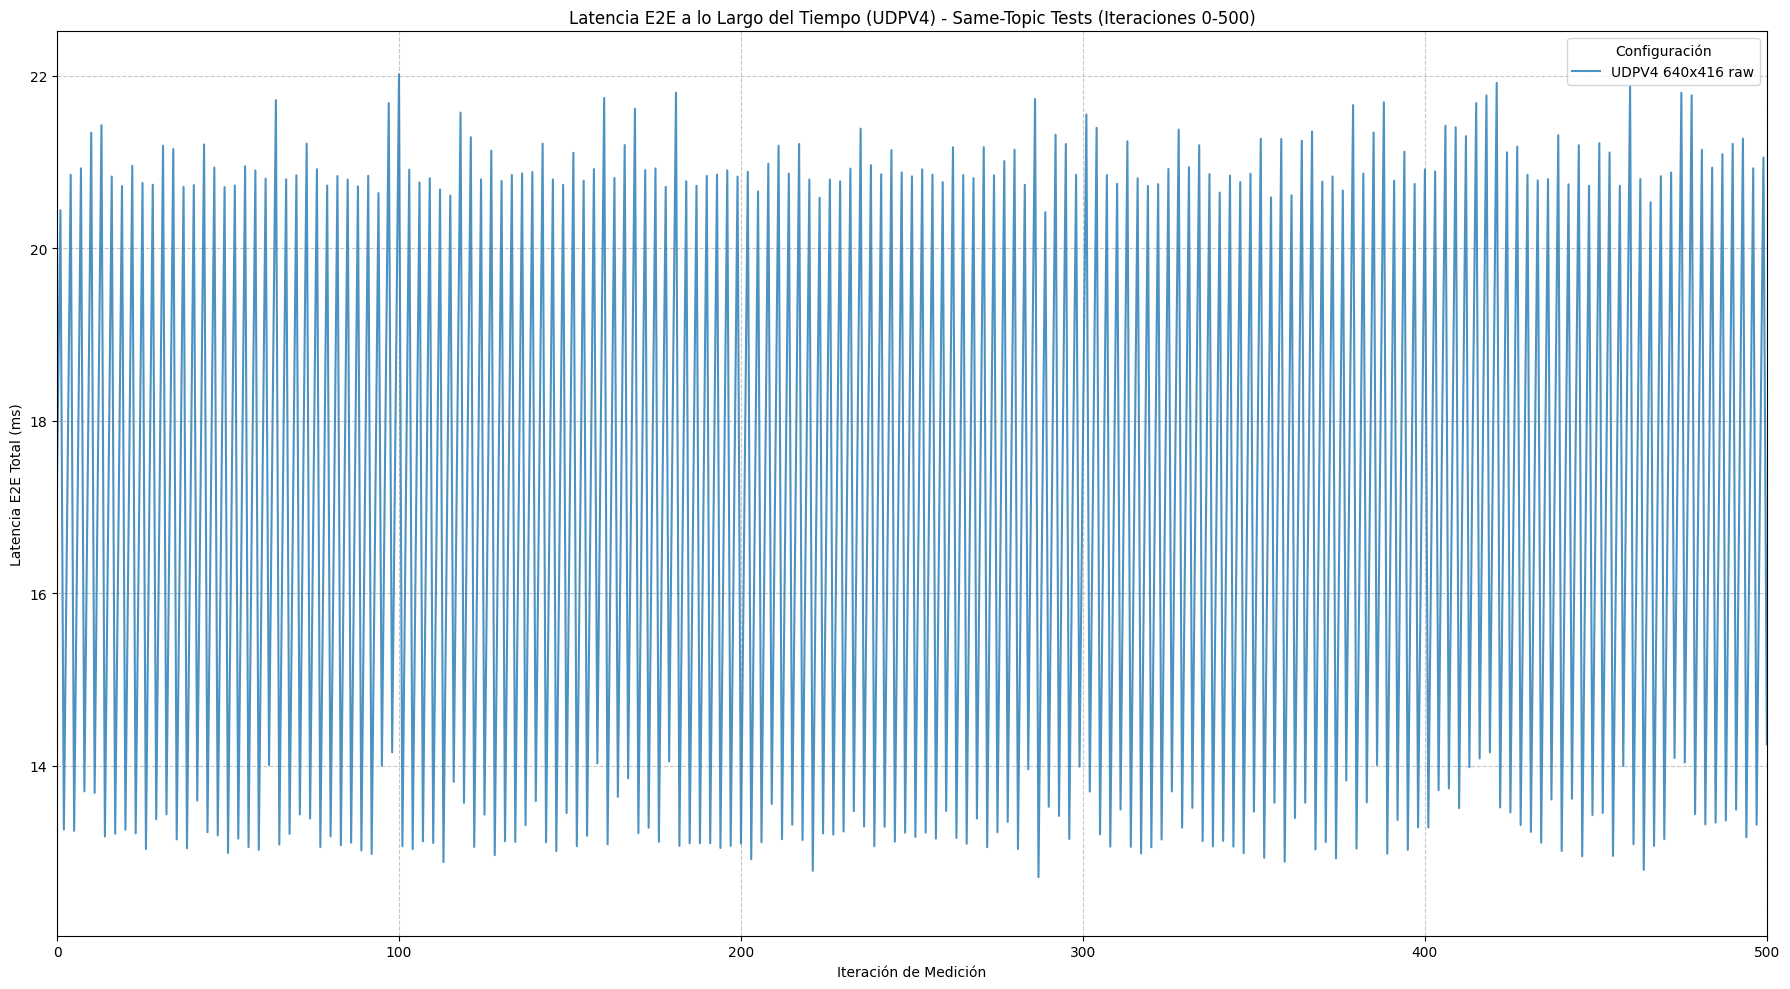

--- Procesando archivos de latencia ---
  Archivo: /home/david/yolocpp_ws/tests/latency_640_416_1B_Large_Data_raw.csv -> Config: {'resolution': '640x416', 'comm_method': 'Default', 'compression': 'raw', 'arch': '1B', 'type': 'latency', 'test_type': 'standard'}
  Archivo: /home/david/yolocpp_ws/tests/latency_640_416_1B_SHM_raw.csv -> Config: {'resolution': '640x416', 'comm_method': 'SHM', 'compression': 'raw', 'arch': '1B', 'type': 'latency', 'test_type': 'standard'}
  Archivo: /home/david/yolocpp_ws/tests/latency_640_416_1B_udpv4_3p_compressed_command.csv -> Config: {'resolution': '640x416', 'comm_method': 'UDPV4', 'compression': 'compressed', 'arch': '3P', 'type': 'latency', 'test_type': 'standard'}
  Archivo: /home/david/yolocpp_ws/tests/latency_640_416_1B_udpv4_3p_raw_command.csv -> Config: {'resolution': '640x416', 'comm_method': 'UDPV4', 'compression': 'raw', 'arch': '3P', 'type': 'latency', 'test_type': 'standard'}
  Archivo: /home/david/yolocpp_ws/tests/latency_640_416_1B_udpv4_

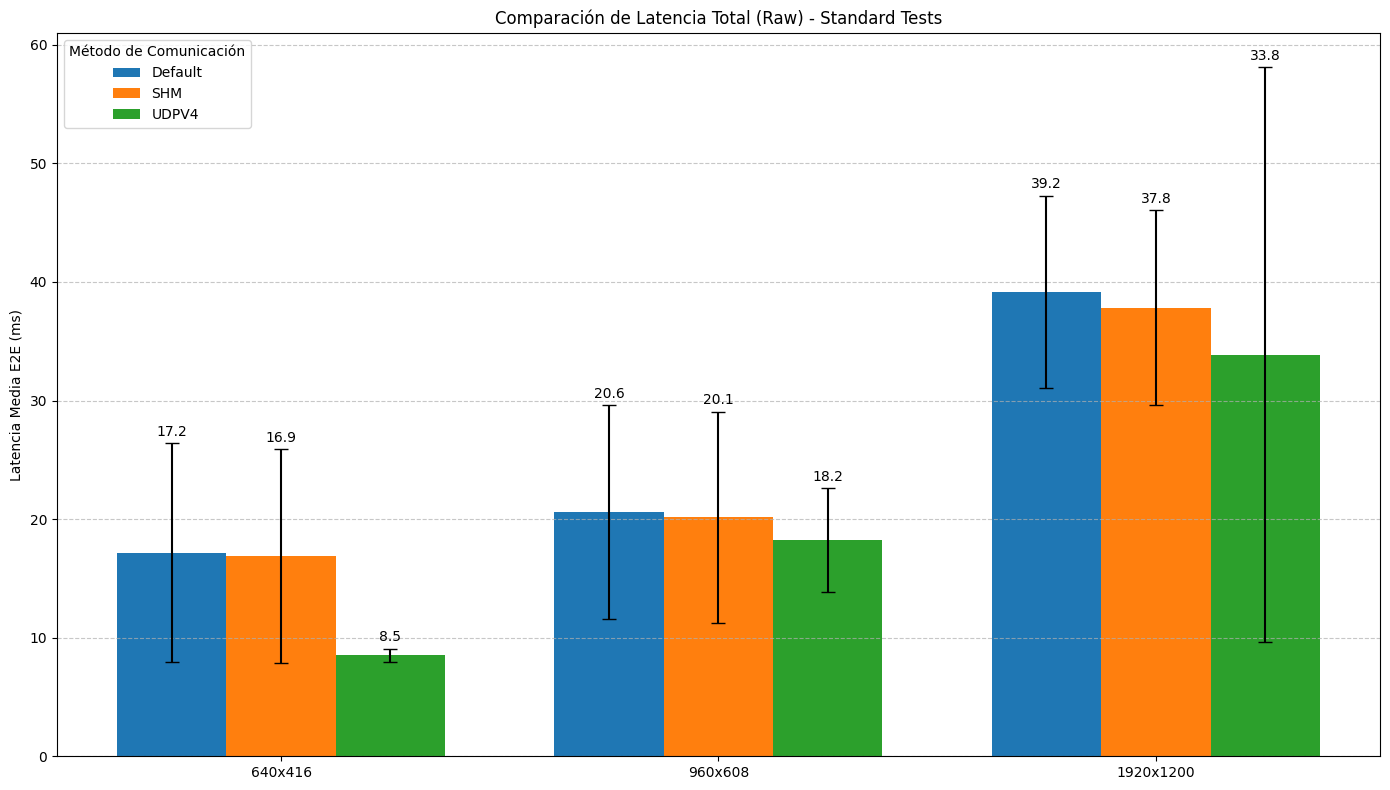


--- Generando Gráfico de Latencia Total (Compressed) - Standard Tests ---


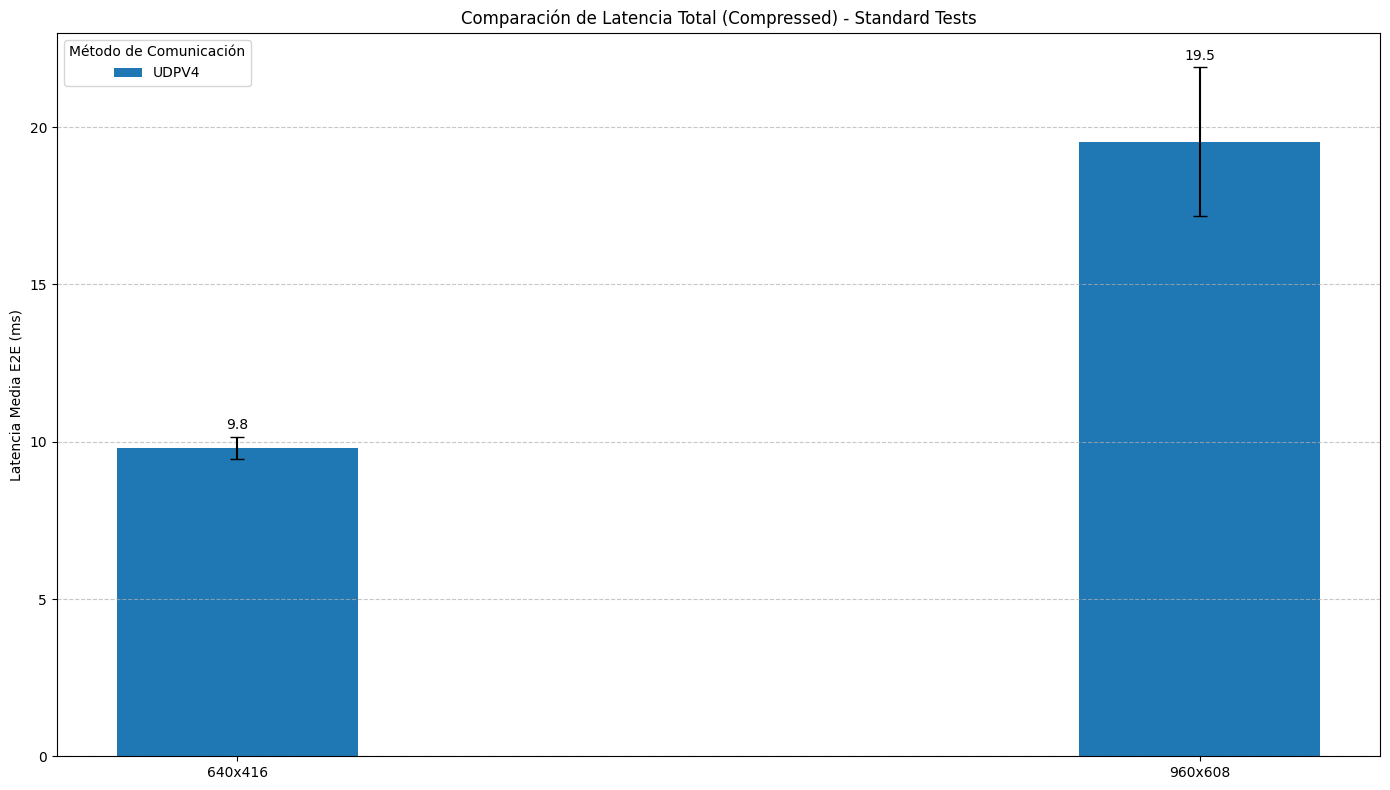


--- Generando Gráfico de Latencia de Red (Raw) - Standard Tests ---
Interpolando para 'Default' en resoluciones: ['960x608']
Interpolando para 'SHM' en resoluciones: ['960x608']


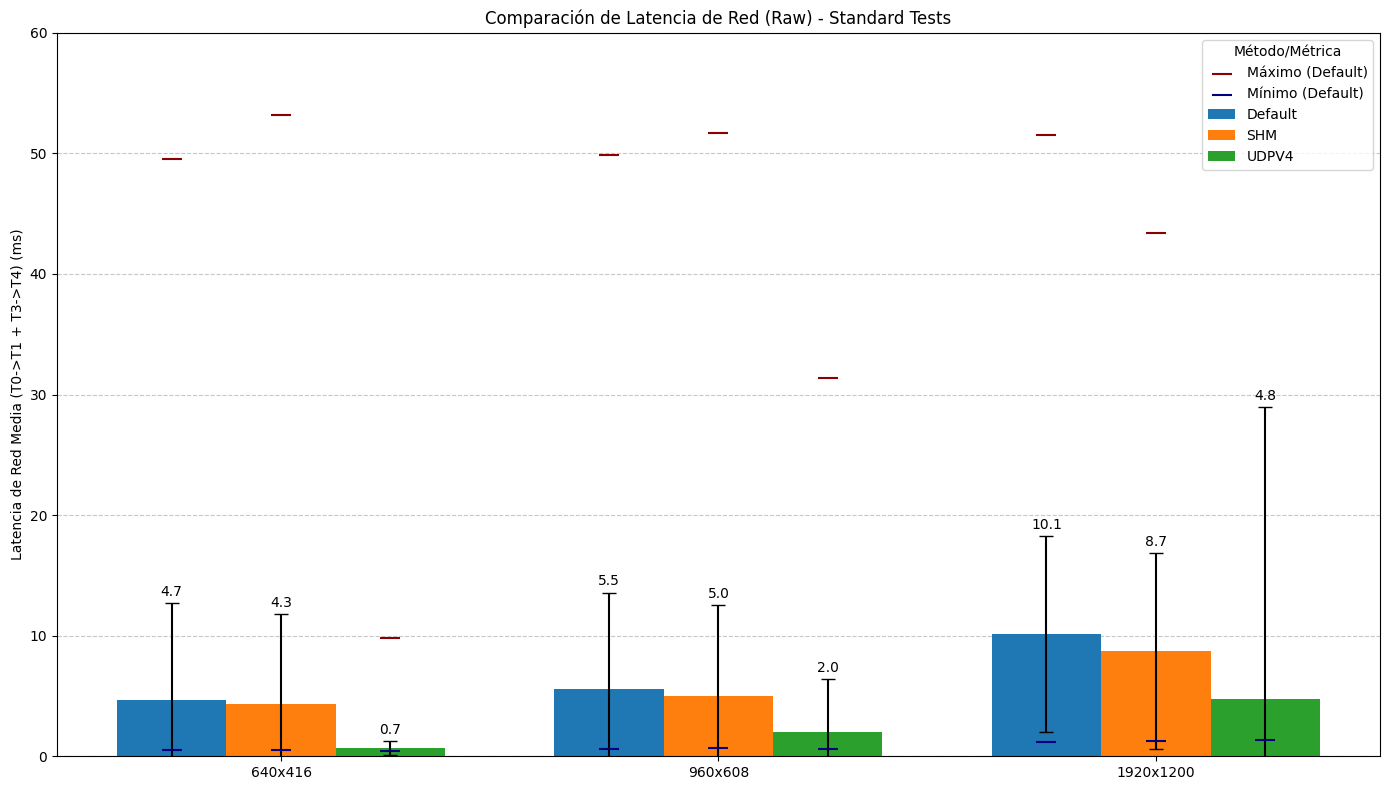


--- Generando Gráfico de Latencia de Red (Compressed) - Standard Tests ---


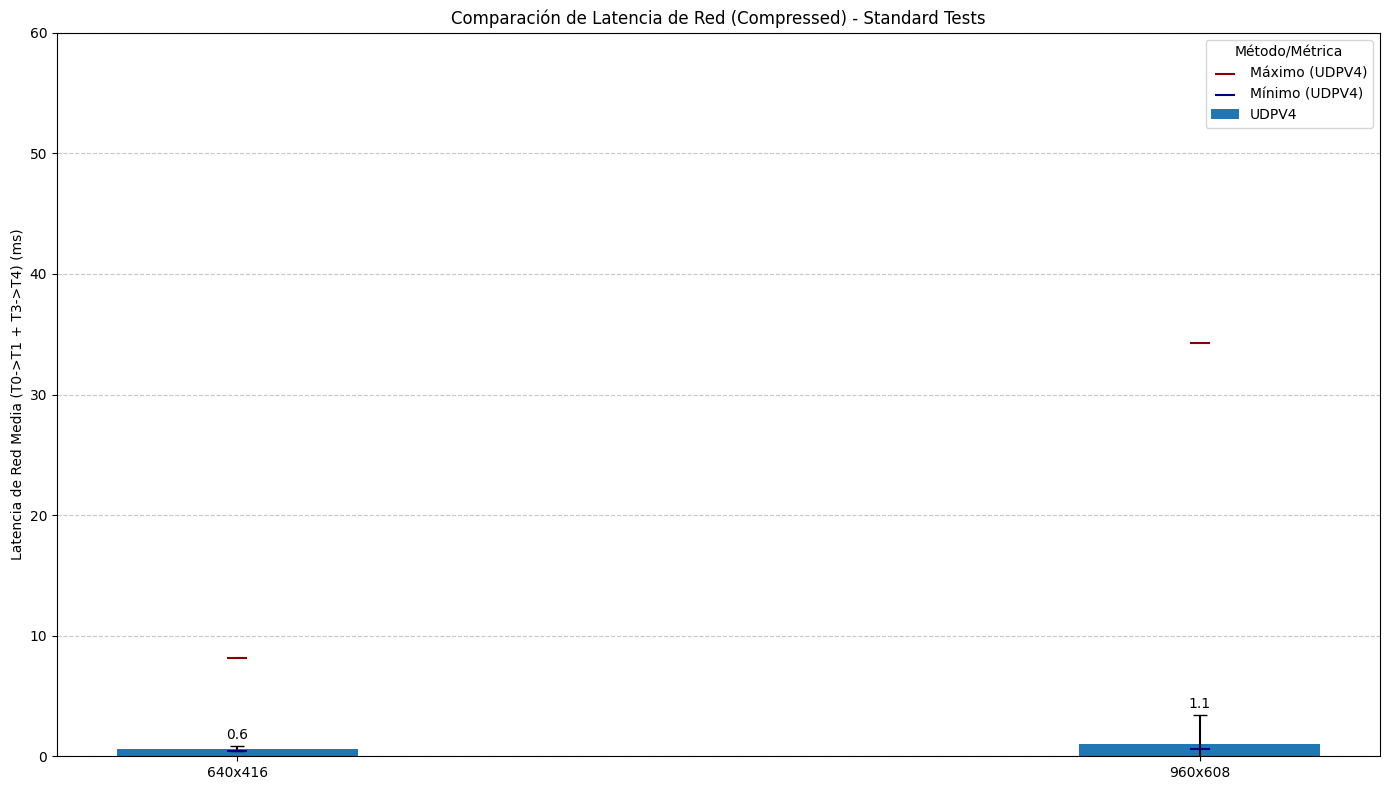


--- Generando Gráfico de Componentes de Latencia - Standard Tests ---


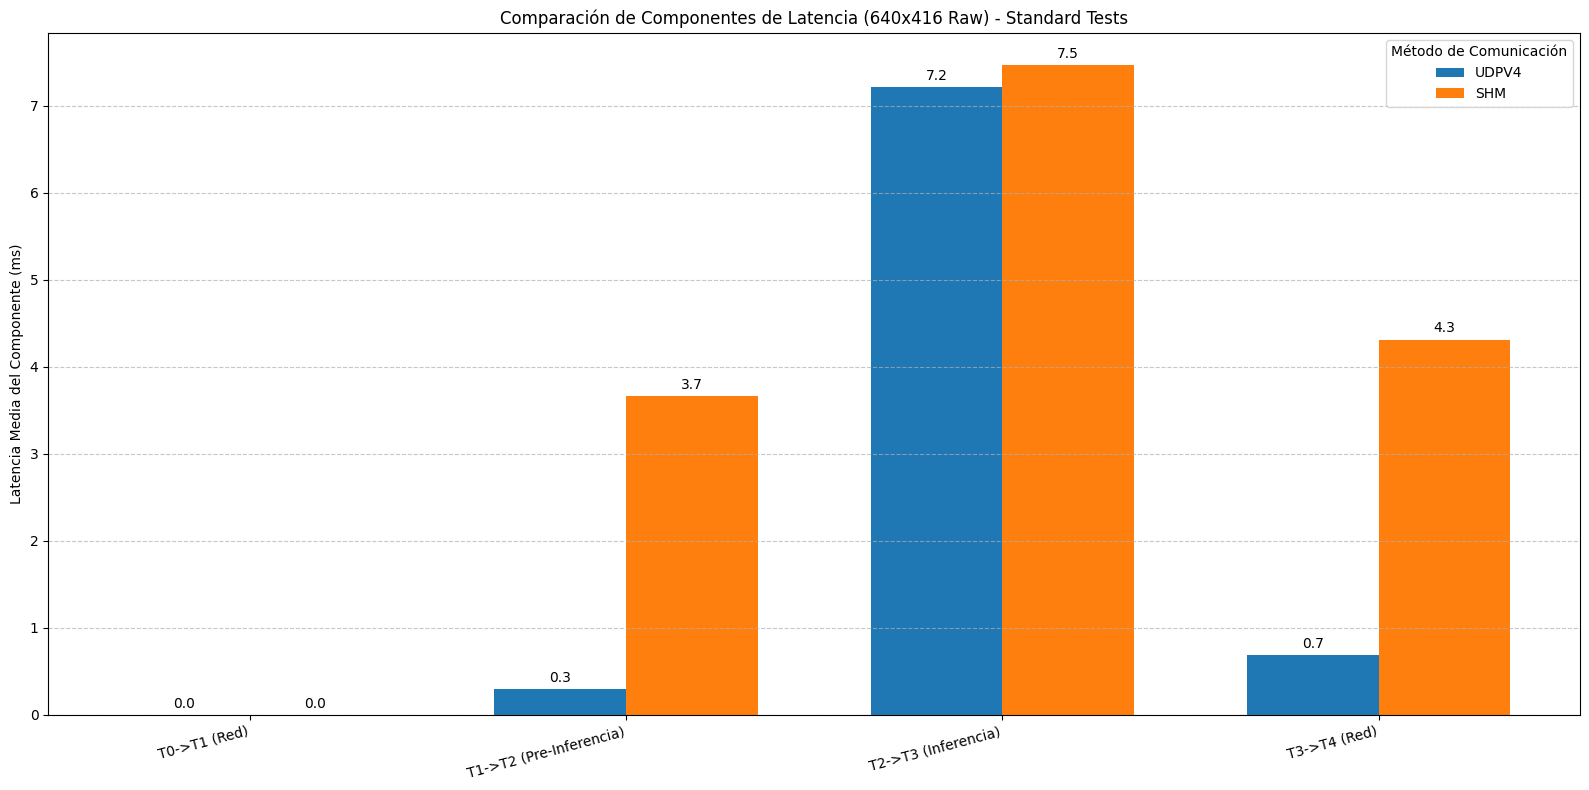


--- Generando Gráfico de Latencia en el Tiempo (Comparativa UDPV4) - Standard Tests ---
  Generando gráfico de latencia en el tiempo (0-7000 iteraciones)...


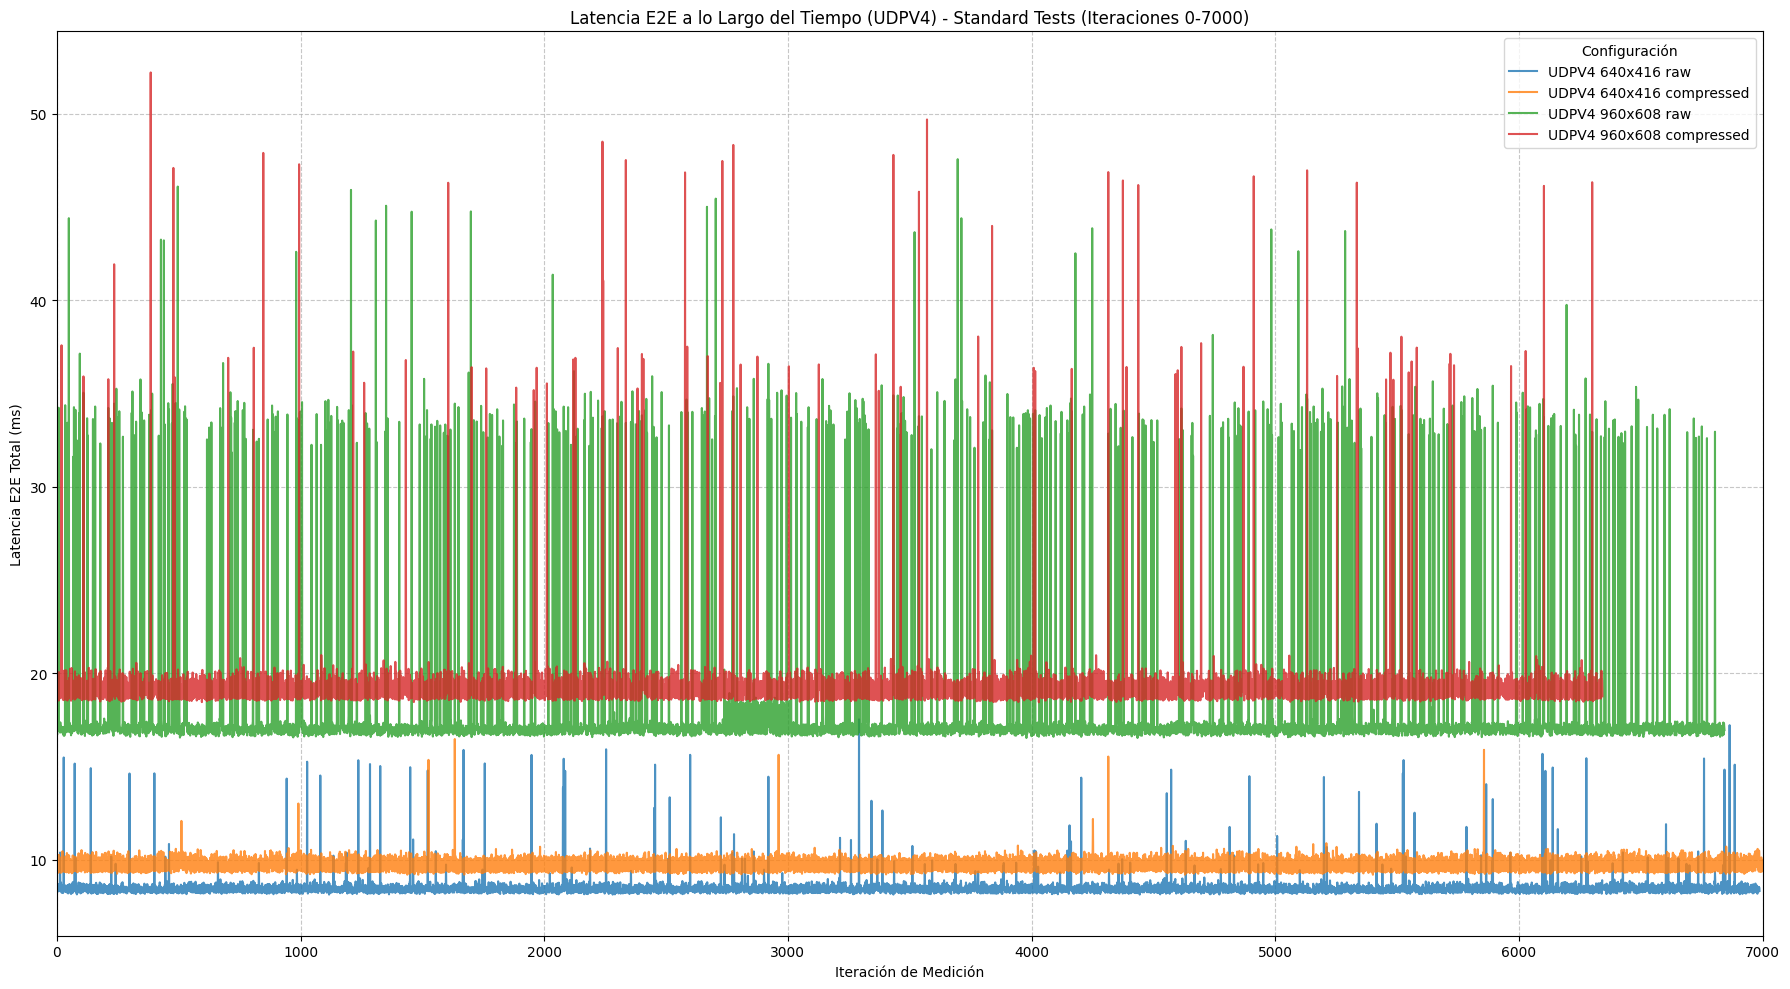

  Generando gráfico de latencia en el tiempo (0-500 iteraciones)...


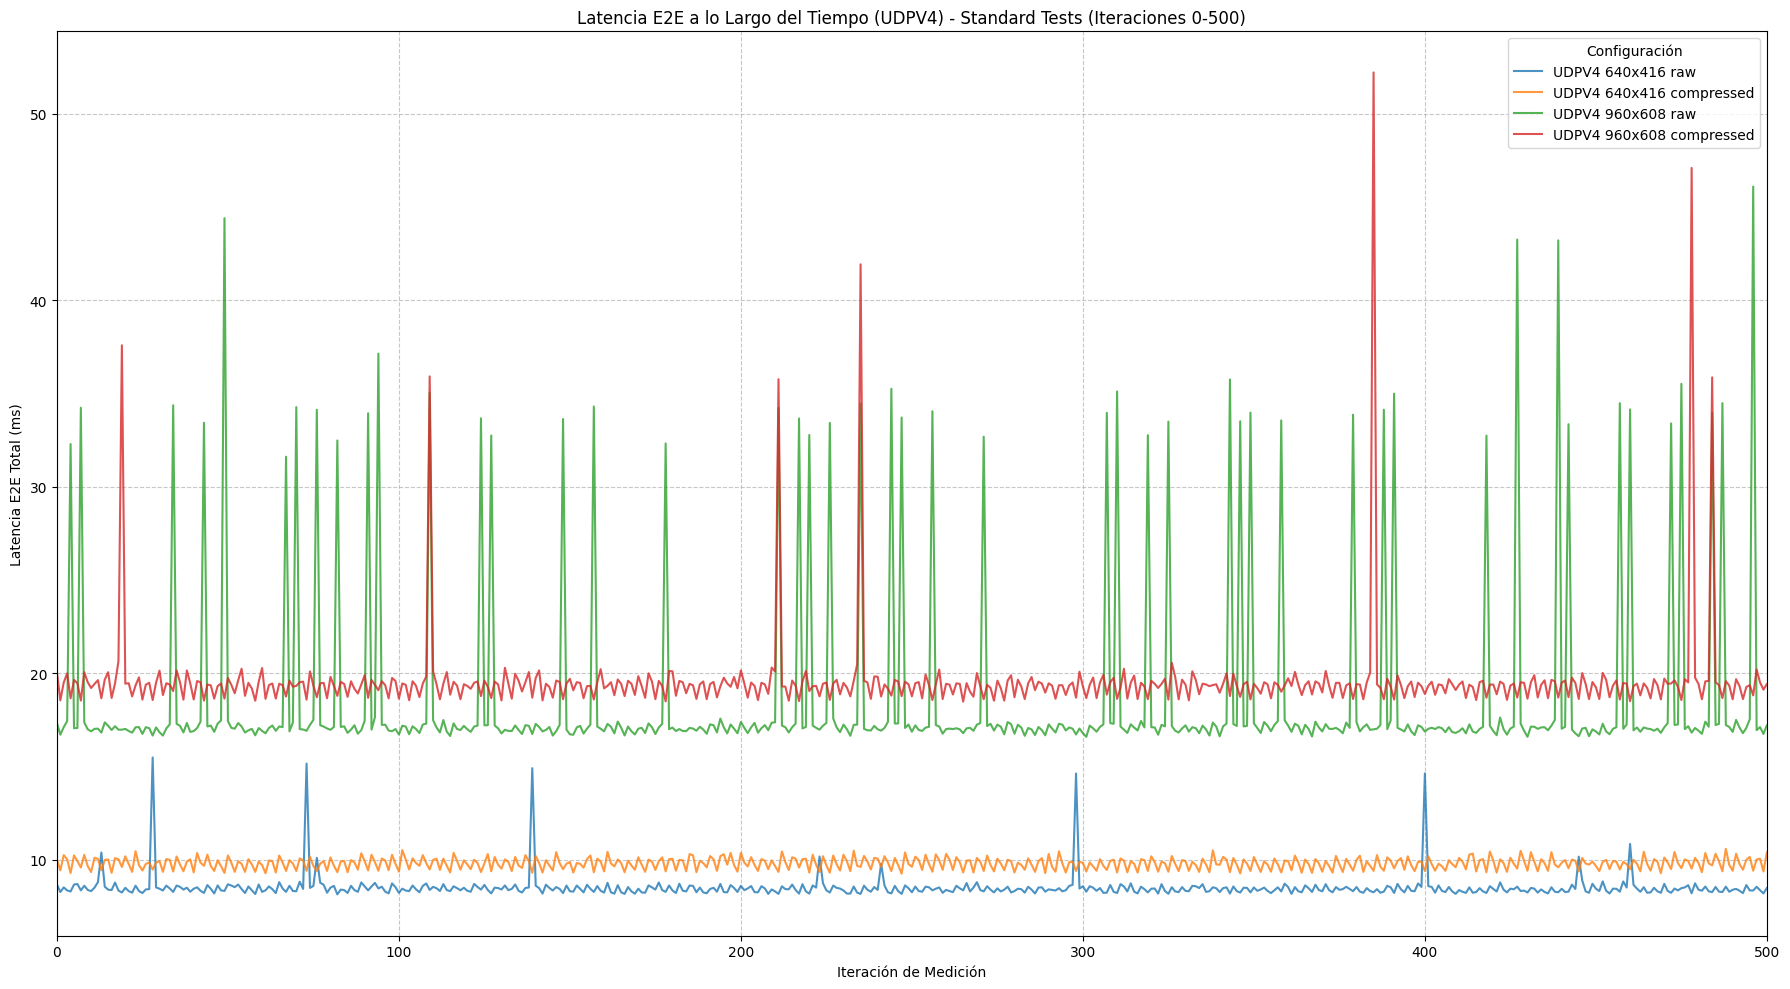


--- Generando Gráfico de Latencia Total (Raw) - Same-Topic Tests ---


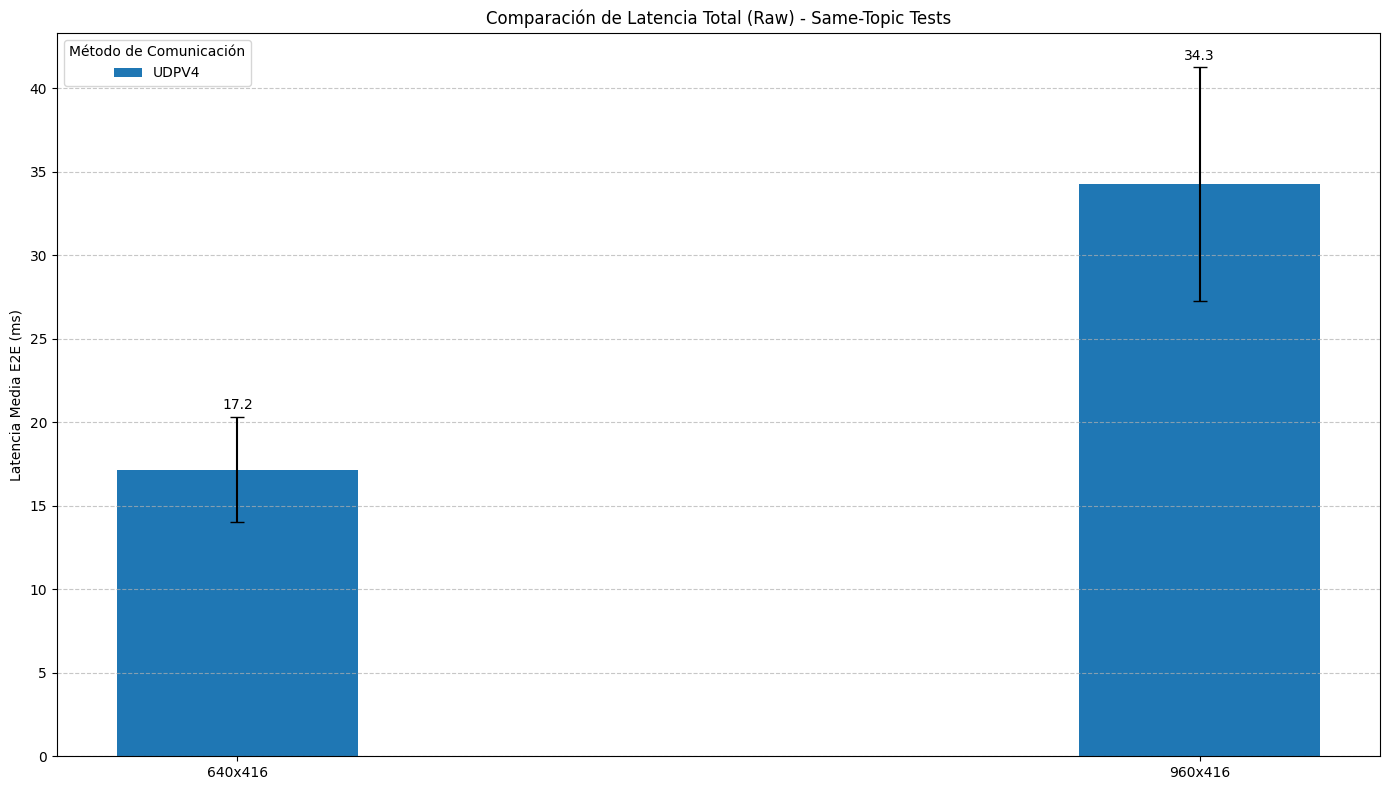


--- Generando Gráfico de Latencia Total (Compressed) - Same-Topic Tests ---
No se encontraron datos para 'compressed'.

--- Generando Gráfico de Latencia de Red (Raw) - Same-Topic Tests ---


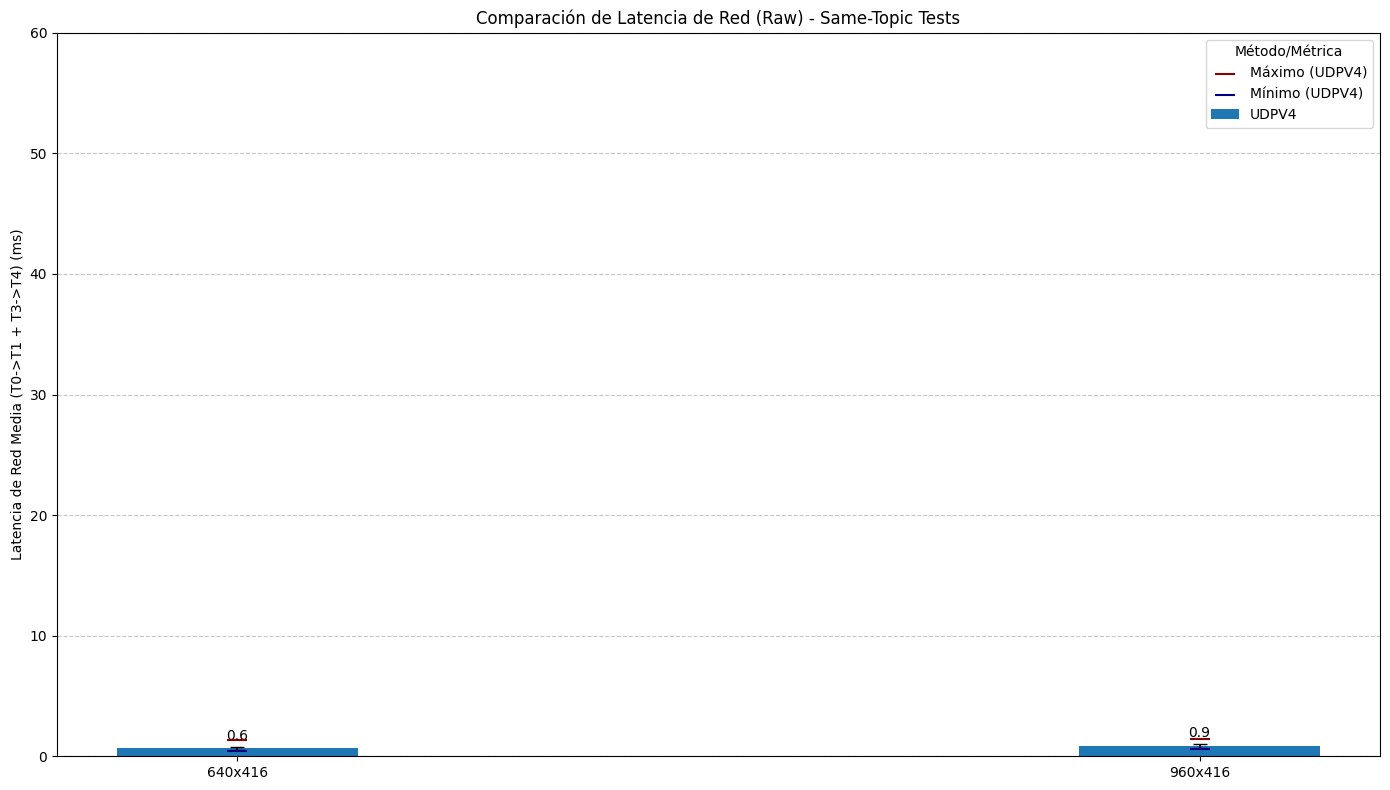


--- Generando Gráfico de Latencia de Red (Compressed) - Same-Topic Tests ---
No se encontraron datos para 'compressed' para el gráfico de latencia de red.

--- Generando Gráfico de Componentes de Latencia - Same-Topic Tests ---


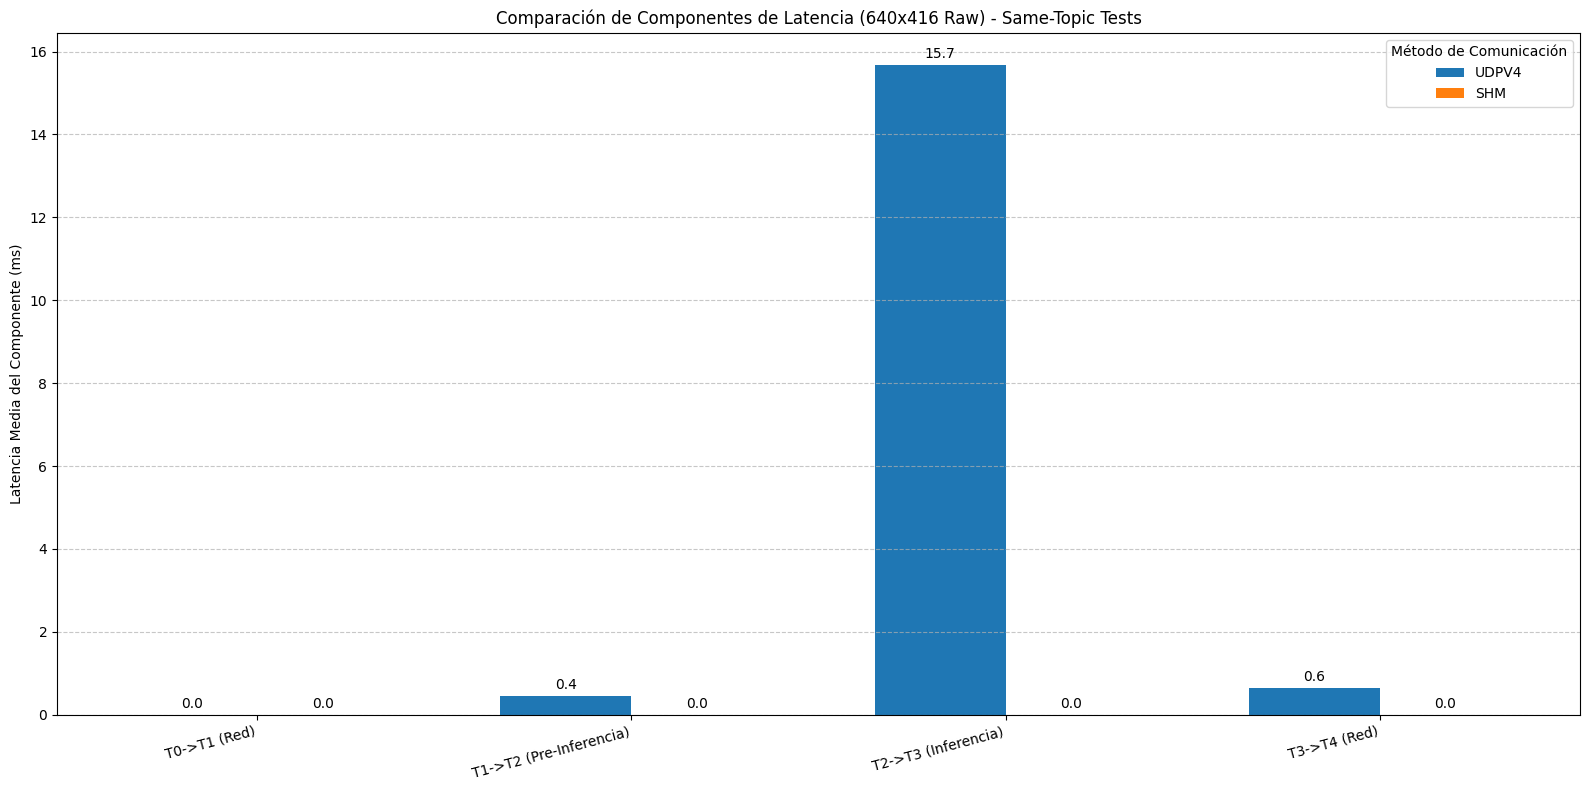


--- Generando Gráfico de Latencia en el Tiempo (Comparativa UDPV4) - Same-Topic Tests ---
  Generando gráfico de latencia en el tiempo (0-7000 iteraciones)...
Advertencia: No se encontraron datos para la configuración '640x416-compressed' en Same-Topic Tests.
Advertencia: No se encontraron datos para la configuración '960x608-raw' en Same-Topic Tests.
Advertencia: No se encontraron datos para la configuración '960x608-compressed' en Same-Topic Tests.


KeyboardInterrupt: 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from collections import defaultdict

# --- Funciones de Procesamiento ---

# CORRECCIÓN: Revertido al mapeo de columnas original que coincide con tus archivos CSV.
# Este diccionario ahora usa los nombres de columna correctos como 'lat_imgpub_to_cb_ms'.
LATENCY_COMPONENTS = {
    "lat_imgpub_to_cb_ms": "T0->T1 (Red)",
    "lat_cb_to_batch_start_ms": "T1->T2 (Pre-Inferencia)",
    "lat_inf_duration_ms": "T2->T3 (Inferencia)", # Usando lat_inf_duration_ms para el tiempo de inferencia.
    "lat_res_pub_to_res_recv_ms": "T3->T4 (Red)",
}


def parse_latency_filename(filename):
    """
    Extrae la configuración (resolución, método de comunicación, compresión, tipo de test)
    del nuevo formato de nombres de archivo.
    """
    basename = os.path.basename(filename).lower()
    
    test_type = "sametopic" if "sametopic" in basename else "standard"

    match1 = re.search(r'latency_(\d+)_(\d+)_.*?_(udpv4|shm)_(3p)_(compressed|raw)_command', basename)
    if match1:
        width, height, comm, arch, comp = match1.groups()
        return {
            "resolution": f"{width}x{height}",
            "comm_method": comm.upper(),
            "compression": comp,
            "arch": arch.upper(),
            "type": "latency",
            "test_type": test_type
        }

    match2 = re.search(r'latency_(\d+)_(\d+)_.*?_(shm|large_data)_raw.csv', basename)
    if match2:
        width, height, comm = match2.groups()
        comm_method = "SHM" if comm == "shm" else "Default"
        return {
            "resolution": f"{width}x{height}",
            "comm_method": comm_method,
            "compression": "raw",
            "arch": "1B",
            "type": "latency",
            "test_type": test_type
        }

    match3 = re.search(r'latency_(\d+p)_(default|shm|udp)_(command|xml).csv', basename)
    if match3:
        arch, comm, _ = match3.groups()
        if comm == 'udp':
            comm_method = 'UDPV4'
        elif comm == 'default':
            comm_method = 'Default'
        else:
            comm_method = comm.upper()
            
        return {
            "resolution": "1920x1200",
            "comm_method": comm_method,
            "compression": "raw",
            "arch": arch.upper(),
            "type": "latency",
            "test_type": test_type
        }

    return None

def process_latency_file(filepath):
    """Procesa un archivo CSV de latencia y devuelve métricas clave, incluyendo componentes."""
    try:
        df = pd.read_csv(filepath)
    except Exception as e:
        print(f"Error leyendo {filepath}: {e}")
        return None

    processed_data = {}
    
    # Procesar latencia total
    latency_col_name = next((col for col in ['lat_total_e2e_ms', 'total_latency_e2e_ms', 'total_latency'] if col in df.columns), None)
    if latency_col_name:
        latencies = df[latency_col_name]
        processed_data["mean_latency"] = latencies.mean()
        processed_data["std_latency"] = latencies.std()
        processed_data["raw_latency_series"] = latencies.copy() # Guardar la serie completa
    else:
        print(f"Error: No se encontró una columna de latencia E2E en {filepath}")
        processed_data["raw_latency_series"] = None
        return None

    # CORRECCIÓN: Procesar componentes de latencia individuales usando el diccionario con los nombres correctos.
    for col, name in LATENCY_COMPONENTS.items():
        if col in df.columns:
            processed_data[f"mean_{col}"] = df[col].mean()
        else:
            # Se imprime una advertencia si una columna esperada no se encuentra
            print(f"Advertencia: Columna de componente '{col}' no encontrada en {filepath}. Se usará NaN.")
            processed_data[f"mean_{col}"] = np.nan

    # Calcular estadísticas de latencia de red combinada (T0->T1 + T3->T4)
    net_lat_col1 = 'lat_imgpub_to_cb_ms'
    net_lat_col2 = 'lat_res_pub_to_res_recv_ms'
    if net_lat_col1 in df.columns and net_lat_col2 in df.columns:
        network_latency_series = df[net_lat_col1] + df[net_lat_col2]
        processed_data['mean_network_latency'] = network_latency_series.mean()
        processed_data['std_network_latency'] = network_latency_series.std()
        processed_data['min_network_latency'] = network_latency_series.min()
        processed_data['max_network_latency'] = network_latency_series.max()
    else:
        processed_data['mean_network_latency'] = np.nan
        processed_data['std_network_latency'] = np.nan
        processed_data['min_network_latency'] = np.nan
        processed_data['max_network_latency'] = np.nan

    return processed_data
# --- Funciones de Ploteo ---

def _generate_latency_bar_chart(data, compression_title, test_type_title):
    """
    Función auxiliar para generar un gráfico de barras agrupado, con interpolación.
    """
    resolutions = sorted(list(set(d['config']['resolution'] for d in data.values())), key=lambda x: int(x.split('x')[0]))
    comm_methods = sorted(list(set(d['config']['comm_method'] for d in data.values())))
    
    plot_data = {res: {comm: np.nan for comm in comm_methods} for res in resolutions}
    plot_errors = {res: {comm: np.nan for comm in comm_methods} for res in resolutions}

    for values in data.values():
        config = values['config']
        res = config['resolution']
        comm = config['comm_method']
        plot_data[res][comm] = values.get('mean_latency', np.nan)
        plot_errors[res][comm] = values.get('std_latency', np.nan)

    # --- Lógica de Interpolación ---
    for comm in comm_methods:
        known_points_x, known_points_y_mean, known_points_y_std = [], [], []
        missing_points_x, missing_resolutions = [], []

        for res in resolutions:
            pixels = int(res.split('x')[0]) * int(res.split('x')[1])
            if not np.isnan(plot_data[res][comm]):
                known_points_x.append(pixels)
                known_points_y_mean.append(plot_data[res][comm])
                known_points_y_std.append(plot_errors[res][comm])
            else:
                missing_points_x.append(pixels)
                missing_resolutions.append(res)
        
        if len(known_points_x) >= 2 and missing_points_x:
            print(f"Interpolando para '{comm}' en resoluciones: {missing_resolutions}")
            sorted_indices = np.argsort(known_points_x)
            xp, fp_mean, fp_std = np.array(known_points_x)[sorted_indices], np.array(known_points_y_mean)[sorted_indices], np.array(known_points_y_std)[sorted_indices]
            
            interpolated_y_mean = np.interp(missing_points_x, xp, fp_mean)
            interpolated_y_std = np.interp(missing_points_x, xp, fp_std)
            
            for i, res in enumerate(missing_resolutions):
                plot_data[res][comm] = interpolated_y_mean[i]
                plot_errors[res][comm] = interpolated_y_std[i]

    # --- Lógica de Ploteo ---
    x = np.arange(len(resolutions))
    width, num_comms = 0.25, len(comm_methods)
    fig, ax = plt.subplots(figsize=(14, 8))

    for i, comm in enumerate(comm_methods):
        means = [plot_data[res][comm] for res in resolutions]
        errors = [plot_errors[res][comm] for res in resolutions]
        offset = (i - (num_comms - 1) / 2.0) * width
        rects = ax.bar(x + offset, means, width, label=comm, yerr=errors, capsize=5)
        ax.bar_label(rects, padding=3, fmt='%.1f')

    ax.set_ylabel('Latencia Media E2E (ms)')
    ax.set_title(f'Comparación de Latencia Total ({compression_title}) - {test_type_title}')
    ax.set_xticks(x)
    ax.set_xticklabels(resolutions)
    ax.legend(title="Método de Comunicación")
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    fig.tight_layout()
    plt.savefig(f"latency_comparison_{test_type_title.replace(' ', '_').lower()}_{compression_title.lower()}.png")
    plt.show()

def plot_latency_over_time_comparison(all_data, test_type_title):
    """
    Gráfico de líneas para latencia E2E a lo largo del tiempo para UDPV4
    en resoluciones 640x416 y 960x608, comparando Raw vs Compressed.
    Genera dos gráficos: uno completo y otro con zoom en las primeras 500 iteraciones.
    """
    target_configs = {
        "640x416-raw": None,
        "640x416-compressed": None,
        "960x608-raw": None,
        "960x608-compressed": None,
    }

    # 1. Encontrar los datos para las configuraciones de interés
    for key, values in all_data.items():
        cfg = values['config']
        if cfg['comm_method'] == 'UDPV4':
            config_key = f"{cfg['resolution']}-{cfg['compression']}"
            if config_key in target_configs:
                target_configs[config_key] = values.get('raw_latency_series')

    # Función auxiliar para crear cada gráfico
    def _create_plot(x_limit=None, title_suffix="", filename_suffix=""):
        plt.figure(figsize=(18, 10))
        plotted_anything = False

        for config_key, series in target_configs.items():
            if series is not None and not series.empty:
                label = f"UDPV4 {config_key.replace('-', ' ')}"
                plt.plot(series.index, series, label=label, alpha=0.8, linewidth=1.5)
                plotted_anything = True
            else:
                print(f"Advertencia: No se encontraron datos para la configuración '{config_key}' en {test_type_title}.")

        if not plotted_anything:
            print(f"No hay datos para generar el gráfico de latencia en el tiempo para {test_type_title}.")
            plt.close()
            return

        plt.xlabel('Iteración de Medición')
        plt.ylabel('Latencia E2E Total (ms)')
        plt.title(f'Latencia E2E a lo Largo del Tiempo (UDPV4) - {test_type_title} {title_suffix}')
        plt.legend(title="Configuración")
        plt.grid(True, linestyle='--', alpha=0.7)
        
        if x_limit:
            plt.xlim(0, x_limit)

        plt.tight_layout()
        plt.savefig(f"latency_over_time_udpv4_comparison_{test_type_title.replace(' ', '_').lower()}{filename_suffix}.png")
        plt.show()

    # 2. Generar los dos gráficos
    # Gráfico con límite de 7000 iteraciones
    print("  Generando gráfico de latencia en el tiempo (0-7000 iteraciones)...")
    _create_plot(x_limit=7000, title_suffix="(Iteraciones 0-7000)", filename_suffix="_0_7000")
    
    # Gráfico con límite de 500 iteraciones
    print("  Generando gráfico de latencia en el tiempo (0-500 iteraciones)...")
    _create_plot(x_limit=500, title_suffix="(Iteraciones 0-500)", filename_suffix="_0_500")

def plot_latency_components_barchart(all_data, test_type_title):
    """
    Genera un gráfico de barras comparando los componentes de latencia
    para 640x416 raw UDPV4 vs SHM.
    """
    target_resolution = "640x416"
    target_compression = "raw"
    comm_methods_to_compare = ["UDPV4", "SHM"]
    
    # 1. Filtrar los datos para encontrar las dos configuraciones de interés
    data_to_plot = {}
    for key, values in all_data.items():
        cfg = values['config']
        if (cfg['resolution'] == target_resolution and
            cfg['compression'] == target_compression and
            cfg['comm_method'] in comm_methods_to_compare):
            
            comm_method = cfg['comm_method']
            
            # CORRECCIÓN: Extraer los componentes de latencia usando el diccionario correcto.
            components = {}
            for col, name in LATENCY_COMPONENTS.items():
                # Se busca la media pre-calculada 'mean_{col}'
                components[name] = values.get(f"mean_{col}", 0) # Usar 0 si falta
            data_to_plot[comm_method] = components

    if len(data_to_plot) < 1:
        print(f"No se encontraron datos para la comparación de componentes en {test_type_title} "
              f"(640x416, raw, UDPV4/SHM).")
        return

    # 2. Preparar datos para el gráfico
    # CORRECCIÓN: Usar las etiquetas del diccionario correcto.
    component_labels = list(LATENCY_COMPONENTS.values())
    x = np.arange(len(component_labels))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(16, 8))

    # Barra para UDPV4
    udpv4_means = [data_to_plot.get("UDPV4", {}).get(label, 0) for label in component_labels]
    rects1 = ax.bar(x - width/2, udpv4_means, width, label='UDPV4')
    
    # Barra para SHM
    shm_means = [data_to_plot.get("SHM", {}).get(label, 0) for label in component_labels]
    rects2 = ax.bar(x + width/2, shm_means, width, label='SHM')

    # 3. Añadir etiquetas y títulos
    ax.set_ylabel('Latencia Media del Componente (ms)')
    ax.set_title(f'Comparación de Componentes de Latencia (640x416 Raw) - {test_type_title}')
    ax.set_xticks(x)
    ax.set_xticklabels(component_labels, rotation=15, ha="right")
    ax.legend(title="Método de Comunicación")
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    ax.bar_label(rects1, padding=3, fmt='%.1f')
    ax.bar_label(rects2, padding=3, fmt='%.1f')

    fig.tight_layout()
    plt.savefig(f"latency_components_comparison_{test_type_title.replace(' ', '_').lower()}.png")
    plt.show()

def plot_network_latency_barchart(data, compression_title, test_type_title):
    """
    NUEVA FUNCIÓN: Genera un gráfico de barras mostrando solo la latencia de red combinada
    (T0->T1 + T3->T4), con interpolación para datos faltantes y marcadores de min/max.
    """
    resolutions = sorted(list(set(d['config']['resolution'] for d in data.values())), key=lambda x: int(x.split('x')[0]))
    comm_methods = sorted(list(set(d['config']['comm_method'] for d in data.values())))
    
    plot_data = {res: {comm: {} for comm in comm_methods} for res in resolutions}

    for values in data.values():
        config = values['config']
        res = config['resolution']
        comm = config['comm_method']
        
        plot_data[res][comm] = {
            'mean': values.get('mean_network_latency', np.nan),
            'std': values.get('std_network_latency', np.nan),
            'min': values.get('min_network_latency', np.nan),
            'max': values.get('max_network_latency', np.nan)
        }

    # --- Lógica de Interpolación ---
    for comm in comm_methods:
        known_points_x, known_points_y = [], { 'mean': [], 'std': [], 'min': [], 'max': [] }
        missing_points_x, missing_resolutions = [], []

        for res in resolutions:
            pixels = int(res.split('x')[0]) * int(res.split('x')[1])
            if plot_data[res][comm] and not np.isnan(plot_data[res][comm]['mean']):
                known_points_x.append(pixels)
                for metric in known_points_y.keys():
                    known_points_y[metric].append(plot_data[res][comm][metric])
            else:
                missing_points_x.append(pixels)
                missing_resolutions.append(res)
        
        if len(known_points_x) >= 2 and missing_points_x:
            print(f"Interpolando para '{comm}' en resoluciones: {missing_resolutions}")
            sorted_indices = np.argsort(known_points_x)
            xp = np.array(known_points_x)[sorted_indices]
            
            for metric in known_points_y.keys():
                fp = np.array(known_points_y[metric])[sorted_indices]
                interpolated_y = np.interp(missing_points_x, xp, fp)
                for i, res in enumerate(missing_resolutions):
                    plot_data[res][comm][metric] = interpolated_y[i]

    # --- Lógica de Ploteo ---
    x = np.arange(len(resolutions))
    width, num_comms = 0.25, len(comm_methods)
    fig, ax = plt.subplots(figsize=(14, 8))

    for i, comm in enumerate(comm_methods):
        means = [plot_data[res][comm].get('mean', np.nan) for res in resolutions]
        errors = [plot_data[res][comm].get('std', np.nan) for res in resolutions]
        mins = [plot_data[res][comm].get('min', np.nan) for res in resolutions]
        maxs = [plot_data[res][comm].get('max', np.nan) for res in resolutions]
        
        offset = (i - (num_comms - 1) / 2.0) * width
        bar_positions = x + offset
        
        rects = ax.bar(bar_positions, means, width, label=comm, yerr=errors, capsize=5, zorder=2)
        ax.bar_label(rects, padding=3, fmt='%.1f')

        # Añadir marcadores de mínimo y máximo
        ax.scatter(bar_positions, maxs, color='darkred', marker='_', s=200, linewidths=1.5, label=f'Máximo ({comm})' if i == 0 else "", zorder=3)
        ax.scatter(bar_positions, mins, color='navy', marker='_', s=200, linewidths=1.5, label=f'Mínimo ({comm})' if i == 0 else "", zorder=3)

    ax.set_ylabel('Latencia de Red Media (T0->T1 + T3->T4) (ms)')
    ax.set_title(f'Comparación de Latencia de Red ({compression_title}) - {test_type_title}')
    ax.set_xticks(x)
    ax.set_xticklabels(resolutions)
    ax.set_ylim(0, 60)
    
    # Crear leyenda combinada
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    ax.legend(unique_labels.values(), unique_labels.keys(), title="Método/Métrica")
    
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    fig.tight_layout()
    plt.savefig(f"network_latency_comparison_{test_type_title.replace(' ', '_').lower()}_{compression_title.lower()}.png")
    plt.show()




def run_plots(all_data_latency, test_type_title=""):
    """
    Función principal para generar todos los gráficos para un tipo de test.
    """
    if not all_data_latency:
        print(f"\nNo se procesaron datos de latencia para {test_type_title}.")
        return

    # Gráficos de latencia total (Raw vs Compressed)
    data_raw = {k: v for k, v in all_data_latency.items() if v['config']['compression'] == 'raw'}
    data_compressed = {k: v for k, v in all_data_latency.items() if v['config']['compression'] == 'compressed'}

    print(f"\n--- Generando Gráfico de Latencia Total (Raw) - {test_type_title} ---")
    if data_raw:
        _generate_latency_bar_chart(data_raw, "Raw", test_type_title)
    else:
        print("No se encontraron datos para 'raw'.")

    print(f"\n--- Generando Gráfico de Latencia Total (Compressed) - {test_type_title} ---")
    if data_compressed:
        _generate_latency_bar_chart(data_compressed, "Compressed", test_type_title)
    else:
        print("No se encontraron datos para 'compressed'.")
        
    # NUEVO GRÁFICO: Latencia de Red
    print(f"\n--- Generando Gráfico de Latencia de Red (Raw) - {test_type_title} ---")
    if data_raw:
        plot_network_latency_barchart(data_raw, "Raw", test_type_title)
    else:
        print("No se encontraron datos para 'raw' para el gráfico de latencia de red.")

    print(f"\n--- Generando Gráfico de Latencia de Red (Compressed) - {test_type_title} ---")
    if data_compressed:
        plot_network_latency_barchart(data_compressed, "Compressed", test_type_title)
    else:
        print("No se encontraron datos para 'compressed' para el gráfico de latencia de red.")

    print(f"\n--- Generando Gráfico de Componentes de Latencia - {test_type_title} ---")
    plot_latency_components_barchart(all_data_latency, test_type_title)

    # Nuevo gráfico de latencia en el tiempo
    print(f"\n--- Generando Gráfico de Latencia en el Tiempo (Comparativa UDPV4) - {test_type_title} ---")
    plot_latency_over_time_comparison(all_data_latency, test_type_title)


# --- Script Principal ---
if __name__ == "__main__":
    base_path = "/home/david/yolocpp_ws/tests"
    original_size_path = os.path.join(base_path, "ORGINAL_SIZE_TEST")

    files_to_process_input = [
        os.path.join(base_path, "latency_640_416_1B_Large_Data_raw.csv"),
        os.path.join(base_path, "latency_640_416_1B_SHM_raw.csv"),
        os.path.join(base_path, "latency_640_416_1B_udpv4_3p_compressed_command.csv"),
        os.path.join(base_path, "latency_640_416_1B_udpv4_3p_raw_command.csv"),
        os.path.join(base_path, "latency_640_416_1B_udpv4_3p_raw_command_sametopic.csv"),
        os.path.join(base_path, "latency_960_416_1B_udpv4_3p_raw_command_sametopic.csv"),
        os.path.join(base_path, "latency_960_608_1B_udpv4_3p_compressed_command.csv"),
        os.path.join(base_path, "latency_960_608_1B_udpv4_3p_raw_command.csv"),
        os.path.join(original_size_path, "Latency_3P_DEFAULT_command.csv"),
        os.path.join(original_size_path, "Latency_3P_SHM_command.csv"),
        os.path.join(original_size_path, "Latency_3P_SHM_xml.csv"),
        os.path.join(original_size_path, "Latency_3P_UDP_command.csv"),
        os.path.join(original_size_path, "Latency_3P_UDP_xml.csv"),
    ]

    latency_files = [f for f in files_to_process_input if os.path.exists(f)]
    if not latency_files:
        print("No se encontraron archivos CSV válidos en las rutas especificadas.")
        exit()

    all_data_latency_standard = {}
    all_data_latency_sametopic = {}

    print("--- Procesando archivos de latencia ---")
    for f_path in latency_files:
        config = parse_latency_filename(f_path)
        if config:
            key = os.path.basename(f_path)
            print(f"  Archivo: {f_path} -> Config: {config}")
            data = process_latency_file(f_path)
            if data:
                entry = {"config": config, **data}
                if config.get("test_type") == "sametopic":
                    all_data_latency_sametopic[key] = entry
                else:
                    all_data_latency_standard[key] = entry
        else:
            print(f"  ADVERTENCIA: No se pudo parsear el nombre del archivo: {f_path}")

    # Generar todos los gráficos para tests estándar
    run_plots(all_data_latency_standard, "Standard Tests")

    # Generar todos los gráficos para tests "sametopic"
    run_plots(all_data_latency_sametopic, "Same-Topic Tests")

# --- Script Principal ---
if __name__ == "__main__":
    base_path = "/home/david/yolocpp_ws/tests"
    original_size_path = os.path.join(base_path, "ORGINAL_SIZE_TEST")

    files_to_process_input = [
        os.path.join(base_path, "latency_640_416_1B_Large_Data_raw.csv"),
        os.path.join(base_path, "latency_640_416_1B_SHM_raw.csv"),
        os.path.join(base_path, "latency_640_416_1B_udpv4_3p_compressed_command.csv"),
        os.path.join(base_path, "latency_640_416_1B_udpv4_3p_raw_command.csv"),
        os.path.join(base_path, "latency_640_416_1B_udpv4_3p_raw_command_sametopic.csv"),
        os.path.join(base_path, "latency_960_416_1B_udpv4_3p_raw_command_sametopic.csv"),
        os.path.join(base_path, "latency_960_608_1B_udpv4_3p_compressed_command.csv"),
        os.path.join(base_path, "latency_960_608_1B_udpv4_3p_raw_command.csv"),
        os.path.join(original_size_path, "Latency_3P_DEFAULT_command.csv"),
        os.path.join(original_size_path, "Latency_3P_SHM_command.csv"),
        os.path.join(original_size_path, "Latency_3P_SHM_xml.csv"),
        os.path.join(original_size_path, "Latency_3P_UDP_command.csv"),
        os.path.join(original_size_path, "Latency_3P_UDP_xml.csv"),
    ]

    latency_files = [f for f in files_to_process_input if os.path.exists(f)]
    if not latency_files:
        print("No se encontraron archivos CSV válidos en las rutas especificadas.")
        exit()

    all_data_latency_standard = {}
    all_data_latency_sametopic = {}

    print("--- Procesando archivos de latencia ---")
    for f_path in latency_files:
        config = parse_latency_filename(f_path)
        if config:
            key = os.path.basename(f_path)
            print(f"  Archivo: {f_path} -> Config: {config}")
            data = process_latency_file(f_path)
            if data:
                entry = {"config": config, **data}
                if config.get("test_type") == "sametopic":
                    all_data_latency_sametopic[key] = entry
                else:
                    all_data_latency_standard[key] = entry
        else:
            print(f"  ADVERTENCIA: No se pudo parsear el nombre del archivo: {f_path}")

    # Generar todos los gráficos para tests estándar
    run_plots(all_data_latency_standard, "Standard Tests")

    # Generar todos los gráficos para tests "sametopic"
    run_plots(all_data_latency_sametopic, "Same-Topic Tests")